In [1]:

import sys
sys.path.append('../../')

import os
os.environ['PYTHONPATH'] = '../..'


In [2]:
global_params = {'base_url' :'D:\\ESI\\3CS\\PFE\\last_year\\Code\\MEDfl' } 

In [3]:
import mysql.connector
import pandas as pd
from sqlalchemy import create_engine,text
import subprocess


# Torch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


## MEDfl Imports 
## Network Manager Imports 
from MEDfl.NetManager.node import Node
from MEDfl.NetManager.network import Network
from MEDfl.NetManager.dataset import DataSet
from MEDfl.NetManager.flsetup import FLsetup

# flower imports 
import flwr as fl

## Learning Manager imports 
from MEDfl.LearningManager.dynamicModal import DynamicModel
from MEDfl.LearningManager.model import Model
from MEDfl.LearningManager.strategy import Strategy
from MEDfl.LearningManager.server import *
from MEDfl.LearningManager.flpipeline import *
from MEDfl.LearningManager.plot import AccuracyLossPlotter




# Utils
from MEDfl.LearningManager.utils import *


C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-07-24 21:40:16,180	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [4]:
import torch.nn.functional as F

class BinaryClassifier(nn.Module):
    def __init__(self, input_size, num_layers, layer_size):
        super(BinaryClassifier, self).__init__()

        # Input layer
        self.layers = [nn.Linear(input_size, layer_size)]
        
        # Hidden layers
        for _ in range(num_layers - 1):
            self.layers.append(nn.Linear(layer_size, layer_size))
        
        # Output layer
        self.layers.append(nn.Linear(layer_size, 1))
        
        # ModuleList to handle dynamic number of layers
        self.layers = nn.ModuleList(self.layers)

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))
        x = torch.sigmoid(self.layers[-1](x))  # Appliquer la fonction sigmoïde
        return x


In [5]:
centralized_score = 0.7774

In [6]:
centralized_score = 0.976

In [7]:
# Best HyperParams using optuna optimisation 
best_hyperparams = {'batch_size': 32, 'num_layers': 4, 'hidden_size': 64,
                    'optimizer': 'Adam', 'learning_rate': 0.001, 'num_epochs': 50}

In [8]:
#  Best threshold
best_th = 0.4

In [9]:
# The number of server rounds
n_rounds = [15]

In [10]:
benchmarks_config = {
    # * 1 . Differential Privacy
    # *******************************************
    # "diff_privacy": [
    #     {
    #         # DP config
    #         "dp_activate": False,

    #         # The rest of the config
    #         "n_clients": 10,
    #         "train_test": True,
    #         "train_portion": 0.5,
    #         "aggreg_algo": "FedAvg",
    #         "Tl": True,
    #     },
    #     {
    #         # DP config
    #         "dp_activate": True,
    #         "DELTA": 1e-5,
    #         "EPSILON": 5.0,

    #         # The rest of the config
    #         "n_clients": 10,
    #         "train_test": True,
    #         "train_portion": 0.5,
    #         "aggreg_algo": "FedAvg",
    #         "Tl": True,
    #     },
    #     {
    #         # DP config
    #         "dp_activate": True,
    #         "DELTA": 1e-5,
    #         "EPSILON": 10.0,

    #         # The rest of the config
    #         "n_clients": 10,
    #         "train_test": True,
    #         "train_portion": 0.5,
    #         "aggreg_algo": "FedAvg",
    #         "Tl": True,
    #     },
    #     {
    #         # DP config
    #         "dp_activate": True,
    #         "DELTA": 1e-5,
    #         "EPSILON": 0.5,

    #         # The rest of the config
    #         "n_clients": 10,
    #         "train_test": True,
    #         "train_portion": 0.5,
    #         "aggreg_algo": "FedAvg",
    #         "Tl": True,
    #     },
    #     {
    #         # DP config
    #         "dp_activate": True,
    #         "DELTA": 0,
    #         "EPSILON": 0.5,

    #         # The rest of the config
    #         "n_clients": 10,
    #         "train_test": True,
    #         "train_portion": 0.5,
    #         "aggreg_algo": "FedAvg",
    #         "Tl": True,
    #     },
    #           {
    #         # DP config
    #         "dp_activate": True,
    #         "DELTA": 0,
    #         "EPSILON": 5.0,

    #         # The rest of the config
    #         "n_clients": 10,
    #         "train_test": True,
    #         "train_portion": 0.5,
    #         "aggreg_algo": "FedAvg",
    #         "Tl": True,
    #     }
    # ],
    # # * 2 . Nodes Config
    # *******************************************
    "nodes_config": [
        {
            # nodes config
            "train_test": True,
            "train_portion": 0.5,

            # The rest of the config
            "n_clients": 5,
            "dp_activate": False,
            "aggreg_algo": "FedAvg",
            "Tl": True,
        },
        {
            # nodes config
            "train_test": True,
            "train_portion": 0.8,

            # The rest of the config
            "n_clients": 5,
            "dp_activate": False,
            "aggreg_algo": "FedAvg",
            "Tl": True,
        },
        {
            # nodes config
            "train_test": False,
            "train_portion": 0.5,

            # The rest of the config
            "n_clients": 5,
            "dp_activate": False,
            "aggreg_algo": "FedAvg",
            "Tl": True,
        },
        {
            # nodes config
            "train_test": False,
            "train_portion": 0.8,

            # The rest of the config
            "n_clients": 5,
            "dp_activate": False,
            "aggreg_algo": "FedAvg",
            "Tl": True,
        },
    ],
    # * 3 . Aggregation Algorithm
    # *******************************************
#     "Aggreg_algo": [
#             {
#             # Aggregation alrogithm
#             "aggreg_algo": "FedYogi",

#             # The rest of the config
#             "train_test": True,
#             "train_portion": 0.7,
#             "n_clients": 5,
#             "dp_activate": False,
#             "Tl": True,
#         },
# {
#             # Aggregation alrogithm
#             "aggreg_algo": "FedOpt",

#             # The rest of the config
#             "train_test": True,
#             "train_portion": 0.7,
#             "n_clients": 5,
#             "dp_activate": False,
#             "Tl": True,
#         },
    
#         {
#             # Aggregation alro100githm
#             "aggreg_algo": "FedMedian",

#             # The rest of the config
#             "train_test": True,
#             "train_portion": 0.7,
#             "n_clients": 5,
#             "dp_activate": False,
#             "Tl": True,
#         },
#         {
#             # Aggregation alrogithm
#             "aggreg_algo": "FedAvg",

#             # The rest of the config
#             "train_test": True,
#             "train_portion": 0.7,
#             "n_clients": 5,
#             "dp_activate": False,
#             "Tl": True,
#         }
    
#     ],
    # * 4 . Aggregation Algorithm
    # *******************************************
    # "n_clients": [
    #     {
    #         # Number of clients
    #         "n_clients": 5,

    #         # The rest of the config
    #         "train_test": True,
    #         "train_portion": 0.5,
    #         "aggreg_algo": "FedAvg",
    #         "dp_activate": False,
    #         "Tl": False,
    #     },
    #     {
    #         # Number of clients
    #         "n_clients": 10,

    #         # The rest of the config
    #         "train_test": True,
    #         "train_portion": 0.5,
    #         "aggreg_algo": "FedAvg",
    #         "dp_activate": False,
    #         "Tl": False,
    #     },
    #     {
    #         # Number of clients
    #         "n_clients": 30,

    #         # The rest of the config
    #         "train_test": True,
    #         "train_portion": 0.5,
    #         "aggreg_algo": "FedAvg",
    #         "dp_activate": False,
    #         "Tl": False,
    #     },

    # ],
    # * 5 . Combine the configurations 
    # *******************************************
    # "combined_config": []
}

In [11]:
# Benchmarks_result stors the result of each configuration in the benchmark 
benchmarks_results = []

In [12]:
# a fuction to test if the config is already tested
def is_config_tested(config , n_rounds):
    for result in benchmarks_results:
        if result['config'] == config and n_rounds == result['n_rounds'] : return True
    
    return False 

In [13]:
import flwr

flwr.server.strategy.FedAdagrad

flwr.server.strategy.fedadagrad.FedAdagrad

In [14]:
# Benchmarks_result stors the result of each configuration in the benchmark 
benchmarks_results = []

In [15]:
# a fuction to test if the config is already tested
def is_config_tested(config , n_rounds):
    for result in benchmarks_results:
        if result['config'] == config and n_rounds == result['n_rounds'] : return True
    
    return False 

In [16]:
import pandas as pd
import os

def split_csv(input_file, output_directory, n):
    """
  
    """
    # Create output directory if it doesn't exist
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    else:
        # Clean the output directory by removing existing files
        for file in os.listdir(output_directory):
            file_path = os.path.join(output_directory, file)
            if os.path.isfile(file_path):
                os.remove(file_path)

    # Read the CSV file into a DataFrame
    df = pd.read_csv(input_file)

    # Calculate the number of rows in each part
    rows_per_part = len(df) // n

    # Split the DataFrame into n parts
    split_dataframes = [df.iloc[i*rows_per_part:(i+1)*rows_per_part] for i in range(n-1)]
    split_dataframes.append(df.iloc[(n-1)*rows_per_part:])

    # Save each part to a separate CSV file
    output_files = []
    for i, split_df in enumerate(split_dataframes):
        output_file = os.path.join(output_directory, f"output_{i+1}.csv")
        split_df.to_csv(output_file, index=False)
        output_files.append(output_file)

    return output_files

# Example usage:
input_csv = '../data/masterDataSet/second_half_diabetes.csv'
output_dir = '../data/nodesData'

In [17]:
import yaml

def update_yaml_file(file_path, param_name, new_value):
    """
    Update a parameter in a YAML file.
    
    Args:
        file_path (str): Path to the YAML file.
        param_name (str): Name of the parameter to update.
        new_value: New value for the parameter.
    """
    # Load YAML file into a dictionary
    with open(file_path, 'r') as file:
        yaml_data = yaml.safe_load(file)
    
    # Update the parameter value
    if param_name in yaml_data:
        yaml_data[param_name] = new_value
    else:
        print(f"Parameter '{param_name}' not found in the YAML file.")
        return
    
    # Save the updated dictionary back to the YAML file
    with open(file_path, 'w') as file:
        yaml.dump(yaml_data, file)





In [18]:
import os

def count_files_in_directory(directory):
    """
    Count the number of files in a directory.
    
    Args:
        directory (str): Path to the directory.
    
    Returns:
        int: Number of files in the directory.
    """
    # Initialize count
    file_count = 0
    
    # Iterate over files in the directory
    for _, _, files in os.walk(directory):
        file_count += len(files)
    
    return file_count



In [19]:
device = torch.device(
            f"cuda" if torch.cuda.is_available() else "cpu"
        )

device 

device(type='cpu')

In [20]:
# Loop Over the benchmark configs
for key in benchmarks_config.keys():
    print("Executing the: " + key + " configurations")
    for config in benchmarks_config[key]:
        print("Executing th confuguration")
        print(config)
        for server_rounds in n_rounds:
            if(is_config_tested(config=config , n_rounds=server_rounds)):
                break
            # Create the MEDfl pipeline for each config
            
            # if the differential privac is activated change the epsilon and delta on the params file 
            if(config["dp_activate"]):
                update_yaml_file(global_params['base_url'] + "/MEDfl/LearningManager/params.yaml", "EPSILON", config['EPSILON'])
                update_yaml_file(global_params['base_url'] + "/MEDfl/LearningManager/params.yaml", "DELTA", config['DELTA'])
 
            # DB Creation
            # subprocess.run(['python3', '../../scripts/create_db.py'])
            set_db_config('./medfl_database.db')

            db_manager = DatabaseManager()
            db_manager.connect()
            db_manager.get_connection()

            db_manager.create_MEDfl_db(path_to_csv="../data/masterDataSet/second_half_diabetes.csv")




            # Create a nest work "Net_1"
            Net_1 = Network(name="manual_network_2")
            Net_1.create_network()

            # Create a MasterDataSet from Net_1
            Net_1.create_master_dataset("../data/masterDataSet/second_half_diabetes.csv")

            # auto FLsetup creation
            autoFl = FLsetup(name="Flsetup_2",
                             description="The second fl setup", network=Net_1)
            autoFl.create()

            # Spilt master Dataset on n part (n number of clients )
            if(count_files_in_directory(output_dir) != config['n_clients']):
                split_files = split_csv(input_csv, output_dir, config['n_clients'])

            # Create Nodes
            if (config['train_test']):
                n_train = int(config['n_clients']*config['train_portion']) + 1

                #  Create the Train nodes
                for i in range(1, 1 + n_train):
                    hospital = Node(name="hospital_"+str(i), train=1)
                    Net_1.add_node(hospital)
                    hospital.upload_dataset(
                        "hospital_"+str(i)+'_dataset', global_params['base_url'] + '/notebooks/data/nodesData/output_'+str(i)+'.csv')

                #  Create the test nodes
                for i in range(1 + n_train, config['n_clients'] + 1):
                    hospital = Node(name="hospital_"+str(40+i), train=0)
                    Net_1.add_node(hospital)
                    hospital.upload_dataset("hospital_"+str(40+i)+'_dataset',
                                            global_params['base_url'] + '/notebooks/data/nodesData/output_'+str(i)+'.csv')

            #  Create a test+train nodes
            else:
                for i in range(1, config['n_clients'] + 1):
                    hospital = Node(name="hospital_"+str(i), train=1)
                    Net_1.add_node(hospital)
                    hospital.upload_dataset(
                        "hospital_"+str(i)+'_dataset', global_params['base_url'] + '/notebooks/data/nodesData/output_'+str(i)+'.csv')

            # Create FLDataSet
            fl_dataset = autoFl.create_federated_dataset(
                test_frac= 0.2 if config['train_test'] else 1-config ['train_portion'],
                output="diabetes",
                fit_encode=[],
                to_drop=["diabetes"]
            )

            if (config['Tl']):
                # Load the pretrained model
                model = Model.load_model(
                    "../../notebooks/.ipynb_checkpoints/trainedModels/diabetes_model2.pth")
            else:
                # Create the model with the suggested hyperparameters
                model = BinaryClassifier(input_size=fl_dataset.size,
                                         num_layers=best_hyperparams['num_layers'],
                                         layer_size=best_hyperparams['hidden_size'],)
           

            # Pass the specific_model to the Model class
            if best_hyperparams['optimizer'] == 'Adam':
                optimizer = optim.Adam(
                    model.parameters(), lr=best_hyperparams['learning_rate'])
            elif best_hyperparams['optimizer'] == 'SGD':
                optimizer = optim.SGD(model.parameters(),
                                      lr=best_hyperparams['learning_rate'])
            elif best_hyperparams['optimizer'] == 'RMSprop':
                optimizer = optim.RMSprop(
                    model.parameters(), lr=best_hyperparams['learning_rate'])

            # Define loss function and optimizer

            pos_weight = torch.tensor([(1 - best_th) / best_th])
            criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

            # Creating a new Model instance using the specific model created by DynamicModel
            global_model = Model(model, optimizer, criterion)

            # Get the initial params of the model
            init_params = global_model.get_parameters()

            # Create the strategy
            aggreg_algo = Strategy(config['aggreg_algo'],
                                   fraction_fit=1.0,
                                   fraction_evaluate=1.0,
                                   min_fit_clients=2,
                                   min_evaluate_clients=2,
                                   min_available_clients=2,
                                   initial_parameters=global_model.get_parameters())
            aggreg_algo.create_strategy()

            # Create The server
            server = FlowerServer(global_model,
                                  strategy=aggreg_algo,
                                  num_rounds=server_rounds,
                                  num_clients=len(fl_dataset.trainloaders),
                                  fed_dataset=fl_dataset,
                                  diff_privacy=config['dp_activate'],
                                  # You can change the resources alocated for each client based on your machine
                                  client_resources={
                                      'num_cpus': 1.0, 'num_gpus': 0.0}
                                  )
            # Create the pipeline
            ppl_1 = FLpipeline(name="the second fl_pipeline",
                               description="this is our first FL pipeline",
                               server=server)
            
            # Run the Traning of the model
            history = ppl_1.server.run()

            # Test the model 
            report = ppl_1.auto_test()
            
            #  Print the results of the config 
            print('\n\n--------------------------------------------------- \n\n')
            print(config)
            print(server_rounds)
            print(server.auc)
            print(report)
            print('\n\n --------------------------------------------------- \n\n')

            # Save the results in a txt file 
            with open('benchmarks_results.txt', 'a') as file:
                # Write the results in the txt file
                file.write('\n\n---------------------------------------------------\n\n')
                file.write(str(config) + '\n')
                file.write(str(server_rounds) + '\n')
                file.write(str(server.auc) + '\n')
                file.write('\n\n---------------------------------------------------\n\n')

            
            # store the results 
            benchmarks_results.append({
                'n_rounds' : server_rounds,
                'config' : config , 
                'results' : server.auc,
                'test_results' : report
            })

Executing the: nodes_config configurations
Executing th confuguration
{'train_test': True, 'train_portion': 0.5, 'n_clients': 5, 'dp_activate': False, 'aggreg_algo': 'FedAvg', 'Tl': True}


manual_network_2
../data/masterDataSet/second_half_diabetes.csv


c:\Python39\lib\site-packages\MEDfl\NetManager\network.py:51: RemovedIn20Warning: Deprecated API features detected! These feature(s) are not compatible with SQLAlchemy 2.0. To prevent incompatible upgrades prior to updating applications, ensure requirements files are pinned to "sqlalchemy<2.0". Set environment variable SQLALCHEMY_WARN_20=1 to show all deprecation warnings.  Set environment variable SQLALCHEMY_SILENCE_UBER_WARNING=1 to silence this message. (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  self.eng.execute(text(INSERT_NETWORK_QUERY), {"name": self.name})
INFO flwr 2024-07-24 21:40:35,785 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=15, round_timeout=None)
07/24/2024 21:40:35:INFO:Starting Flower simulation, config: ServerConfig(num_rounds=15, round_timeout=None)
2024-07-24 21:40:41,428	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-07-24 21:40:48,778 | app.py:213 | Flower VCE: Ray initialized with resource

(DefaultActor pid=20624) 
(DefaultActor pid=20624)  -------------------------------- 
(DefaultActor pid=20624)   this is the config of the client
(DefaultActor pid=20624) [Client 1] fit, config: {}
(DefaultActor pid=20624) 
(DefaultActor pid=20624)  -------------------------------- 
(DefaultActor pid=20624)   
(DefaultActor pid=20624) 	Train Epoch: 0 	Loss: 0.707680 Acc@1: 0.625000
(DefaultActor pid=472)    [repeated 6x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(DefaultActor pid=472)  --------------------------------  [repeated 4x across cluster]
(DefaultActor pid=472)   this is the config of the client [repeated 2x across cluster]
(DefaultActor pid=472) [Client 2] fit, config: {} [repeated 2x across cluster]
(DefaultActor pid=20624) 	Train Epoch: 5 	Loss: 0.700369 Acc@1: 4.531250 [repeated 331x across cluster]
(Default

DEBUG flwr 2024-07-24 21:41:26,652 | server.py:236 | fit_round 1 received 3 results and 0 failures
07/24/2024 21:41:26:DEBUG:fit_round 1 received 3 results and 0 failures
WARNING flwr 2024-07-24 21:41:26,660 | fedavg.py:250 | No fit_metrics_aggregation_fn provided
07/24/2024 21:41:26:WARNING:No fit_metrics_aggregation_fn provided
INFO flwr 2024-07-24 21:41:26,757 | server.py:125 | fit progress: (1, 0.022716483548283577, {'accuracy': 0.9025}, 35.479554)
07/24/2024 21:41:26:INFO:fit progress: (1, 0.022716483548283577, {'accuracy': 0.9025}, 35.479554)
DEBUG flwr 2024-07-24 21:41:26,759 | server.py:173 | evaluate_round 1: strategy sampled 3 clients (out of 3)
07/24/2024 21:41:26:DEBUG:evaluate_round 1: strategy sampled 3 clients (out of 3)
DEBUG flwr 2024-07-24 21:41:26,992 | server.py:187 | evaluate_round 1 received 3 results and 0 failures
07/24/2024 21:41:26:DEBUG:evaluate_round 1 received 3 results and 0 failures
WARNING flwr 2024-07-24 21:41:26,994 | fedavg.py:281 | No evaluate_metric

(DefaultActor pid=20624) [Client 1] evaluate, config: {}
(DefaultActor pid=24868) 
(DefaultActor pid=24868)  -------------------------------- 
(DefaultActor pid=24868)   this is the config of the client
(DefaultActor pid=24868) [Client 2] fit, config: {}
(DefaultActor pid=24868) 
(DefaultActor pid=24868)  -------------------------------- 
(DefaultActor pid=24868)   


(DefaultActor pid=24868) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 3x across cluster]
(DefaultActor pid=24868)   warnings.warn( [repeated 3x across cluster]
(DefaultActor pid=24868) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower. [repeated 3x across cluster]
(DefaultActor pid=24868)   client = check_clientfn_returns_client

(DefaultActor pid=24868) 	Train Epoch: 3 	Loss: 0.704161 Acc@1: 1.666667 [repeated 256x across cluster]
(DefaultActor pid=20624) epsilon of client 1 : eps = 0 [repeated 2x across cluster]
(DefaultActor pid=472) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(DefaultActor pid=472)    [repeated 6x across cluster]
(DefaultActor pid=472)  --------------------------------  [repeated 4x across cluster]
(DefaultActor pid=472)   this is the config of the client [repeated 2x across cluster]
(DefaultActor pid=472) [Client 1] fit, config: {} [repeated 2x across cluster]
(DefaultActor pid=20624) 	Train Epoch: 5 	Loss: 0.698498 Acc@1: 8.750000 [repeated 116x across cluster]
(DefaultActor pid=20624) 	Train Epoch: 7 	Loss: 0.702962 Acc@1: 1.875000 [repeated 150x across cluster]
(DefaultActor pid=472) 	Train Epoch: 9 	Loss: 0.701991 Acc@1: 3.828125 [repeated 171x across cluster]
(DefaultActor pid=24868) 	Train Epoch: 12 	Loss: 0.701932 Acc@1: 2.281250 [repeated 154x across cluster]
(Defa

DEBUG flwr 2024-07-24 21:42:04,024 | server.py:236 | fit_round 2 received 3 results and 0 failures
07/24/2024 21:42:04:DEBUG:fit_round 2 received 3 results and 0 failures
INFO flwr 2024-07-24 21:42:04,163 | server.py:125 | fit progress: (2, 0.022716716527938843, {'accuracy': 0.9025}, 72.8850717)
07/24/2024 21:42:04:INFO:fit progress: (2, 0.022716716527938843, {'accuracy': 0.9025}, 72.8850717)
DEBUG flwr 2024-07-24 21:42:04,166 | server.py:173 | evaluate_round 2: strategy sampled 3 clients (out of 3)
07/24/2024 21:42:04:DEBUG:evaluate_round 2: strategy sampled 3 clients (out of 3)


(DefaultActor pid=20624) epsilon of client 0 : eps = 0


DEBUG flwr 2024-07-24 21:42:04,384 | server.py:187 | evaluate_round 2 received 3 results and 0 failures
07/24/2024 21:42:04:DEBUG:evaluate_round 2 received 3 results and 0 failures
DEBUG flwr 2024-07-24 21:42:04,386 | server.py:222 | fit_round 3: strategy sampled 3 clients (out of 3)
07/24/2024 21:42:04:DEBUG:fit_round 3: strategy sampled 3 clients (out of 3)


(DefaultActor pid=20624) [Client 2] evaluate, config: {}
(DefaultActor pid=472) 
(DefaultActor pid=472)  -------------------------------- 
(DefaultActor pid=472)   this is the config of the client
(DefaultActor pid=472) [Client 2] fit, config: {}
(DefaultActor pid=472) 
(DefaultActor pid=472)  -------------------------------- 
(DefaultActor pid=472)   


(DefaultActor pid=472) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 3x across cluster]
(DefaultActor pid=472)   warnings.warn( [repeated 3x across cluster]
(DefaultActor pid=472) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower. [repeated 3x across cluster]
(DefaultActor pid=472)   client = check_clientfn_returns_client(client_

(DefaultActor pid=20624) 	Train Epoch: 2 	Loss: 0.702572 Acc@1: 2.901786 [repeated 289x across cluster]
(DefaultActor pid=24868) epsilon of client 2 : eps = 0 [repeated 2x across cluster]
(DefaultActor pid=472) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(DefaultActor pid=24868)    [repeated 6x across cluster]
(DefaultActor pid=24868)  --------------------------------  [repeated 4x across cluster]
(DefaultActor pid=24868)   this is the config of the client [repeated 2x across cluster]
(DefaultActor pid=24868) [Client 1] fit, config: {} [repeated 2x across cluster]
(DefaultActor pid=20624) 	Train Epoch: 6 	Loss: 0.700075 Acc@1: 0.000000 [repeated 249x across cluster]
(DefaultActor pid=20624) 	Train Epoch: 9 	Loss: 0.700501 Acc@1: 5.000000 [repeated 197x across cluster]
(DefaultActor pid=20624) 	Train Epoch: 12 	Loss: 0.702184 Acc@1: 1.666667 [repeated 253x across cluster]
(DefaultActor pid=20624) 	Train Epoch: 15 	Loss: 0.702322 Acc@1: 4.781250 [repeated 168x across clu

DEBUG flwr 2024-07-24 21:42:32,753 | server.py:236 | fit_round 3 received 3 results and 0 failures
07/24/2024 21:42:32:DEBUG:fit_round 3 received 3 results and 0 failures
INFO flwr 2024-07-24 21:42:32,870 | server.py:125 | fit progress: (3, 0.022716806679964067, {'accuracy': 0.9025}, 101.59221450000001)
07/24/2024 21:42:32:INFO:fit progress: (3, 0.022716806679964067, {'accuracy': 0.9025}, 101.59221450000001)


(DefaultActor pid=20624) epsilon of client 0 : eps = 0


DEBUG flwr 2024-07-24 21:42:32,879 | server.py:173 | evaluate_round 3: strategy sampled 3 clients (out of 3)
07/24/2024 21:42:32:DEBUG:evaluate_round 3: strategy sampled 3 clients (out of 3)
DEBUG flwr 2024-07-24 21:42:33,168 | server.py:187 | evaluate_round 3 received 3 results and 0 failures


(DefaultActor pid=24868) [Client 1] evaluate, config: {}


07/24/2024 21:42:33:DEBUG:evaluate_round 3 received 3 results and 0 failures
DEBUG flwr 2024-07-24 21:42:33,182 | server.py:222 | fit_round 4: strategy sampled 3 clients (out of 3)
07/24/2024 21:42:33:DEBUG:fit_round 4: strategy sampled 3 clients (out of 3)
(DefaultActor pid=20624) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 3x across cluster]
(DefaultActor pid=20624)   warnings.warn( [repeated 3x across cluster]
(DefaultActor pid=20624) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `clien

(DefaultActor pid=20624) 
(DefaultActor pid=20624)  -------------------------------- 
(DefaultActor pid=20624)   this is the config of the client
(DefaultActor pid=20624) [Client 0] fit, config: {}
(DefaultActor pid=20624) 
(DefaultActor pid=20624)  -------------------------------- 
(DefaultActor pid=20624)   
(DefaultActor pid=20624) 	Train Epoch: 2 	Loss: 0.702260 Acc@1: 2.663690 [repeated 246x across cluster]
(DefaultActor pid=472) epsilon of client 2 : eps = 0 [repeated 2x across cluster]
(DefaultActor pid=20624) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(DefaultActor pid=20624)  [repeated 7x across cluster]
(DefaultActor pid=472)  --------------------------------  [repeated 4x across cluster]
(DefaultActor pid=472)   this is the config of the client [repeated 2x across cluster]
(DefaultActor pid=472) [Client 1] fit, config: {} [repeated 2x across cluster]
(DefaultActor pid=20624) 	Train Epoch: 7 	Loss: 0.701391 Acc@1: 3.671875 [repeated 285x across cluster]
(Def

DEBUG flwr 2024-07-24 21:43:01,537 | server.py:236 | fit_round 4 received 3 results and 0 failures
07/24/2024 21:43:01:DEBUG:fit_round 4 received 3 results and 0 failures
INFO flwr 2024-07-24 21:43:01,661 | server.py:125 | fit progress: (4, 0.02271681301295757, {'accuracy': 0.9025}, 130.3837695)
07/24/2024 21:43:01:INFO:fit progress: (4, 0.02271681301295757, {'accuracy': 0.9025}, 130.3837695)
DEBUG flwr 2024-07-24 21:43:01,668 | server.py:173 | evaluate_round 4: strategy sampled 3 clients (out of 3)
07/24/2024 21:43:01:DEBUG:evaluate_round 4: strategy sampled 3 clients (out of 3)


(DefaultActor pid=20624) epsilon of client 0 : eps = 0


DEBUG flwr 2024-07-24 21:43:01,990 | server.py:187 | evaluate_round 4 received 3 results and 0 failures
07/24/2024 21:43:01:DEBUG:evaluate_round 4 received 3 results and 0 failures
DEBUG flwr 2024-07-24 21:43:01,994 | server.py:222 | fit_round 5: strategy sampled 3 clients (out of 3)
07/24/2024 21:43:01:DEBUG:fit_round 5: strategy sampled 3 clients (out of 3)


(DefaultActor pid=24868) [Client 0] evaluate, config: {}


(DefaultActor pid=20624) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 3x across cluster]
(DefaultActor pid=20624)   warnings.warn( [repeated 3x across cluster]
(DefaultActor pid=20624) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower. [repeated 3x across cluster]
(DefaultActor pid=20624)   client = check_clientfn_returns_client

(DefaultActor pid=20624) 
(DefaultActor pid=20624)  -------------------------------- 
(DefaultActor pid=20624)   this is the config of the client
(DefaultActor pid=20624) [Client 1] fit, config: {}
(DefaultActor pid=20624) 
(DefaultActor pid=20624)  -------------------------------- 
(DefaultActor pid=20624)   
(DefaultActor pid=20624) 	Train Epoch: 0 	Loss: 0.693681 Acc@1: 0.000000 [repeated 260x across cluster]
(DefaultActor pid=472) epsilon of client 1 : eps = 0 [repeated 2x across cluster]
(DefaultActor pid=20624) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(DefaultActor pid=472)    [repeated 6x across cluster]
(DefaultActor pid=472)  --------------------------------  [repeated 4x across cluster]
(DefaultActor pid=472)   this is the config of the client [repeated 2x across cluster]
(DefaultActor pid=472) [Client 2] fit, config: {} [repeated 2x across cluster]
(DefaultActor pid=20624) 	Train Epoch: 4 	Loss: 0.701298 Acc@1: 4.625000 [repeated 303x across cluster]
(Def

DEBUG flwr 2024-07-24 21:43:25,940 | server.py:236 | fit_round 5 received 3 results and 0 failures
07/24/2024 21:43:25:DEBUG:fit_round 5 received 3 results and 0 failures
INFO flwr 2024-07-24 21:43:26,061 | server.py:125 | fit progress: (5, 0.0227168145775795, {'accuracy': 0.9025}, 154.7833683)
07/24/2024 21:43:26:INFO:fit progress: (5, 0.0227168145775795, {'accuracy': 0.9025}, 154.7833683)
DEBUG flwr 2024-07-24 21:43:26,063 | server.py:173 | evaluate_round 5: strategy sampled 3 clients (out of 3)
07/24/2024 21:43:26:DEBUG:evaluate_round 5: strategy sampled 3 clients (out of 3)
DEBUG flwr 2024-07-24 21:43:26,266 | server.py:187 | evaluate_round 5 received 3 results and 0 failures
07/24/2024 21:43:26:DEBUG:evaluate_round 5 received 3 results and 0 failures
DEBUG flwr 2024-07-24 21:43:26,268 | server.py:222 | fit_round 6: strategy sampled 3 clients (out of 3)
07/24/2024 21:43:26:DEBUG:fit_round 6: strategy sampled 3 clients (out of 3)


(DefaultActor pid=20624) [Client 0] evaluate, config: {}


(DefaultActor pid=20624) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 3x across cluster]
(DefaultActor pid=20624)   warnings.warn( [repeated 3x across cluster]
(DefaultActor pid=20624) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower. [repeated 3x across cluster]
(DefaultActor pid=20624)   client = check_clientfn_returns_client

(DefaultActor pid=20624) 
(DefaultActor pid=20624)  -------------------------------- 
(DefaultActor pid=20624)   this is the config of the client
(DefaultActor pid=20624) [Client 0] fit, config: {}
(DefaultActor pid=20624) 
(DefaultActor pid=20624)  -------------------------------- 
(DefaultActor pid=20624)   
(DefaultActor pid=472)    [repeated 6x across cluster]
(DefaultActor pid=472) 	Train Epoch: 1 	Loss: 0.703112 Acc@1: 4.187500 [repeated 249x across cluster]
(DefaultActor pid=24868) epsilon of client 0 : eps = 0 [repeated 2x across cluster]
(DefaultActor pid=472) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(DefaultActor pid=472)  --------------------------------  [repeated 4x across cluster]
(DefaultActor pid=472)   this is the config of the client [repeated 2x across cluster]
(DefaultActor pid=472) [Client 2] fit, config: {} [repeated 2x across cluster]
(DefaultActor pid=20624) 
(DefaultActor pid=20624) 	Train Epoch: 5 	Loss: 0.700439 Acc@1: 2.055921 [repeated 3

DEBUG flwr 2024-07-24 21:43:49,305 | server.py:236 | fit_round 6 received 3 results and 0 failures
07/24/2024 21:43:49:DEBUG:fit_round 6 received 3 results and 0 failures
INFO flwr 2024-07-24 21:43:49,428 | server.py:125 | fit progress: (6, 0.02271681435406208, {'accuracy': 0.9025}, 178.1510012)
07/24/2024 21:43:49:INFO:fit progress: (6, 0.02271681435406208, {'accuracy': 0.9025}, 178.1510012)
DEBUG flwr 2024-07-24 21:43:49,431 | server.py:173 | evaluate_round 6: strategy sampled 3 clients (out of 3)
07/24/2024 21:43:49:DEBUG:evaluate_round 6: strategy sampled 3 clients (out of 3)
DEBUG flwr 2024-07-24 21:43:49,686 | server.py:187 | evaluate_round 6 received 3 results and 0 failures
07/24/2024 21:43:49:DEBUG:evaluate_round 6 received 3 results and 0 failures
DEBUG flwr 2024-07-24 21:43:49,687 | server.py:222 | fit_round 7: strategy sampled 3 clients (out of 3)
07/24/2024 21:43:49:DEBUG:fit_round 7: strategy sampled 3 clients (out of 3)


(DefaultActor pid=20624) [Client 2] evaluate, config: {}


(DefaultActor pid=20624) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 3x across cluster]
(DefaultActor pid=20624)   warnings.warn( [repeated 3x across cluster]
(DefaultActor pid=20624) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower. [repeated 3x across cluster]
(DefaultActor pid=20624)   client = check_clientfn_returns_client

(DefaultActor pid=20624) 
(DefaultActor pid=20624)  -------------------------------- 
(DefaultActor pid=20624)   this is the config of the client
(DefaultActor pid=20624) [Client 0] fit, config: {}
(DefaultActor pid=20624) 
(DefaultActor pid=20624)  -------------------------------- 
(DefaultActor pid=20624)   
(DefaultActor pid=20624) 	Train Epoch: 2 	Loss: 0.700755 Acc@1: 2.585227 [repeated 287x across cluster]
(DefaultActor pid=24868) epsilon of client 1 : eps = 0 [repeated 2x across cluster]
(DefaultActor pid=472) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(DefaultActor pid=472)    [repeated 6x across cluster]
(DefaultActor pid=472)  --------------------------------  [repeated 4x across cluster]
(DefaultActor pid=472)   this is the config of the client [repeated 2x across cluster]
(DefaultActor pid=472) [Client 1] fit, config: {} [repeated 2x across cluster]
(DefaultActor pid=24868) 	Train Epoch: 7 	Loss: 0.702550 Acc@1: 2.500000 [repeated 310x across cluster]
(Def

DEBUG flwr 2024-07-24 21:44:11,650 | server.py:236 | fit_round 7 received 3 results and 0 failures
07/24/2024 21:44:11:DEBUG:fit_round 7 received 3 results and 0 failures


(DefaultActor pid=20624) epsilon of client 0 : eps = 0


INFO flwr 2024-07-24 21:44:11,783 | server.py:125 | fit progress: (7, 0.022716783210635184, {'accuracy': 0.9025}, 200.5050402)
07/24/2024 21:44:11:INFO:fit progress: (7, 0.022716783210635184, {'accuracy': 0.9025}, 200.5050402)
DEBUG flwr 2024-07-24 21:44:11,785 | server.py:173 | evaluate_round 7: strategy sampled 3 clients (out of 3)
07/24/2024 21:44:11:DEBUG:evaluate_round 7: strategy sampled 3 clients (out of 3)
DEBUG flwr 2024-07-24 21:44:12,043 | server.py:187 | evaluate_round 7 received 3 results and 0 failures
07/24/2024 21:44:12:DEBUG:evaluate_round 7 received 3 results and 0 failures
DEBUG flwr 2024-07-24 21:44:12,048 | server.py:222 | fit_round 8: strategy sampled 3 clients (out of 3)


(DefaultActor pid=24868) [Client 2] evaluate, config: {}


07/24/2024 21:44:12:DEBUG:fit_round 8: strategy sampled 3 clients (out of 3)
(DefaultActor pid=472) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 3x across cluster]
(DefaultActor pid=472)   warnings.warn( [repeated 3x across cluster]
(DefaultActor pid=472) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower. [repeated 3x across clu

(DefaultActor pid=472)  -------------------------------- 
(DefaultActor pid=472)   this is the config of the client
(DefaultActor pid=472) [Client 2] fit, config: {}
(DefaultActor pid=472)  -------------------------------- 
(DefaultActor pid=24868) 	Train Epoch: 0 	Loss: 0.702630 Acc@1: 3.916667 [repeated 285x across cluster]
(DefaultActor pid=24868)    [repeated 9x across cluster]
(DefaultActor pid=24868) epsilon of client 2 : eps = 0 [repeated 2x across cluster]
(DefaultActor pid=472) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(DefaultActor pid=24868)  --------------------------------  [repeated 4x across cluster]
(DefaultActor pid=24868)   this is the config of the client [repeated 2x across cluster]
(DefaultActor pid=24868) [Client 0] fit, config: {} [repeated 2x across cluster]
(DefaultActor pid=20624) 	Train Epoch: 5 	Loss: 0.701857 Acc@1: 4.285714 [repeated 322x across cluster]
(DefaultActor pid=20624) 	Train Epoch: 10 	Loss: 0.698388 Acc@1: 9.739583 [repeated 

DEBUG flwr 2024-07-24 21:44:32,843 | server.py:236 | fit_round 8 received 3 results and 0 failures
07/24/2024 21:44:32:DEBUG:fit_round 8 received 3 results and 0 failures
INFO flwr 2024-07-24 21:44:32,950 | server.py:125 | fit progress: (8, 0.022716815248131753, {'accuracy': 0.9025}, 221.67230260000002)
07/24/2024 21:44:32:INFO:fit progress: (8, 0.022716815248131753, {'accuracy': 0.9025}, 221.67230260000002)
DEBUG flwr 2024-07-24 21:44:32,951 | server.py:173 | evaluate_round 8: strategy sampled 3 clients (out of 3)
07/24/2024 21:44:32:DEBUG:evaluate_round 8: strategy sampled 3 clients (out of 3)
DEBUG flwr 2024-07-24 21:44:36,326 | server.py:187 | evaluate_round 8 received 3 results and 0 failures
07/24/2024 21:44:36:DEBUG:evaluate_round 8 received 3 results and 0 failures
DEBUG flwr 2024-07-24 21:44:36,328 | server.py:222 | fit_round 9: strategy sampled 3 clients (out of 3)
07/24/2024 21:44:36:DEBUG:fit_round 9: strategy sampled 3 clients (out of 3)


(DefaultActor pid=24868) [Client 0] evaluate, config: {}
(DefaultActor pid=472) 	Train Epoch: 19 	Loss: 0.701935 Acc@1: 2.485795 [repeated 318x across cluster]


(DefaultActor pid=20624) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 3x across cluster]
(DefaultActor pid=20624)   warnings.warn( [repeated 3x across cluster]
(DefaultActor pid=20624) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower. [repeated 3x across cluster]
(DefaultActor pid=20624)   client = check_clientfn_returns_client

(DefaultActor pid=20624) 
(DefaultActor pid=20624)  -------------------------------- 
(DefaultActor pid=20624)   this is the config of the client
(DefaultActor pid=20624) [Client 0] fit, config: {}
(DefaultActor pid=20624) 
(DefaultActor pid=20624)  -------------------------------- 
(DefaultActor pid=20624)   
(DefaultActor pid=472) epsilon of client 2 : eps = 0 [repeated 2x across cluster]
(DefaultActor pid=20624) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(DefaultActor pid=20624) 	Train Epoch: 4 	Loss: 0.698287 Acc@1: 2.857143 [repeated 279x across cluster]
(DefaultActor pid=472)  [repeated 8x across cluster]
(DefaultActor pid=472)  --------------------------------  [repeated 4x across cluster]
(DefaultActor pid=472)   this is the config of the client [repeated 2x across cluster]
(DefaultActor pid=472) [Client 2] fit, config: {} [repeated 2x across cluster]
(DefaultActor pid=24868) 	Train Epoch: 9 	Loss: 0.701374 Acc@1: 6.074219 [repeated 362x across cluster]
(Defau

DEBUG flwr 2024-07-24 21:44:56,194 | server.py:236 | fit_round 9 received 3 results and 0 failures
07/24/2024 21:44:56:DEBUG:fit_round 9 received 3 results and 0 failures
INFO flwr 2024-07-24 21:44:56,335 | server.py:125 | fit progress: (9, 0.02271681562066078, {'accuracy': 0.9025}, 245.05713609999998)
07/24/2024 21:44:56:INFO:fit progress: (9, 0.02271681562066078, {'accuracy': 0.9025}, 245.05713609999998)
DEBUG flwr 2024-07-24 21:44:56,338 | server.py:173 | evaluate_round 9: strategy sampled 3 clients (out of 3)
07/24/2024 21:44:56:DEBUG:evaluate_round 9: strategy sampled 3 clients (out of 3)


(DefaultActor pid=20624) epsilon of client 0 : eps = 0


DEBUG flwr 2024-07-24 21:44:56,620 | server.py:187 | evaluate_round 9 received 3 results and 0 failures
07/24/2024 21:44:56:DEBUG:evaluate_round 9 received 3 results and 0 failures
DEBUG flwr 2024-07-24 21:44:56,623 | server.py:222 | fit_round 10: strategy sampled 3 clients (out of 3)
07/24/2024 21:44:56:DEBUG:fit_round 10: strategy sampled 3 clients (out of 3)


(DefaultActor pid=20624) [Client 1] evaluate, config: {}
(DefaultActor pid=472) 	Train Epoch: 19 	Loss: 0.699040 Acc@1: 3.309659 [repeated 311x across cluster]


(DefaultActor pid=20624) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 3x across cluster]
(DefaultActor pid=20624)   warnings.warn( [repeated 3x across cluster]
(DefaultActor pid=20624) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower. [repeated 3x across cluster]
(DefaultActor pid=20624)   client = check_clientfn_returns_client

(DefaultActor pid=20624) 
(DefaultActor pid=20624)  -------------------------------- 
(DefaultActor pid=20624)   this is the config of the client
(DefaultActor pid=20624) [Client 0] fit, config: {}
(DefaultActor pid=20624) 
(DefaultActor pid=20624)  -------------------------------- 
(DefaultActor pid=20624)   
(DefaultActor pid=472) epsilon of client 2 : eps = 0 [repeated 2x across cluster]
(DefaultActor pid=472) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(DefaultActor pid=20624) 	Train Epoch: 4 	Loss: 0.703736 Acc@1: 2.830882 [repeated 308x across cluster]
(DefaultActor pid=472)    [repeated 6x across cluster]
(DefaultActor pid=472)  --------------------------------  [repeated 4x across cluster]
(DefaultActor pid=472)   this is the config of the client [repeated 2x across cluster]
(DefaultActor pid=472) [Client 2] fit, config: {} [repeated 2x across cluster]
(DefaultActor pid=20624) 	Train Epoch: 9 	Loss: 0.700640 Acc@1: 3.242188 [repeated 330x across cluster]
(Defau

DEBUG flwr 2024-07-24 21:45:19,325 | server.py:236 | fit_round 10 received 3 results and 0 failures
07/24/2024 21:45:19:DEBUG:fit_round 10 received 3 results and 0 failures


(DefaultActor pid=20624) epsilon of client 0 : eps = 0


INFO flwr 2024-07-24 21:45:19,465 | server.py:125 | fit progress: (10, 0.022716815546154977, {'accuracy': 0.9025}, 268.1878737)
07/24/2024 21:45:19:INFO:fit progress: (10, 0.022716815546154977, {'accuracy': 0.9025}, 268.1878737)
DEBUG flwr 2024-07-24 21:45:19,468 | server.py:173 | evaluate_round 10: strategy sampled 3 clients (out of 3)
07/24/2024 21:45:19:DEBUG:evaluate_round 10: strategy sampled 3 clients (out of 3)
DEBUG flwr 2024-07-24 21:45:19,681 | server.py:187 | evaluate_round 10 received 3 results and 0 failures
07/24/2024 21:45:19:DEBUG:evaluate_round 10 received 3 results and 0 failures
DEBUG flwr 2024-07-24 21:45:19,683 | server.py:222 | fit_round 11: strategy sampled 3 clients (out of 3)
07/24/2024 21:45:19:DEBUG:fit_round 11: strategy sampled 3 clients (out of 3)


(DefaultActor pid=20624) [Client 2] evaluate, config: {}
(DefaultActor pid=20624) 
(DefaultActor pid=20624)  -------------------------------- 
(DefaultActor pid=20624)   this is the config of the client
(DefaultActor pid=20624) [Client 0] fit, config: {}
(DefaultActor pid=20624) 
(DefaultActor pid=20624)  -------------------------------- 
(DefaultActor pid=20624)   


(DefaultActor pid=20624) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 3x across cluster]
(DefaultActor pid=20624)   warnings.warn( [repeated 3x across cluster]
(DefaultActor pid=20624) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower. [repeated 3x across cluster]
(DefaultActor pid=20624)   client = check_clientfn_returns_client

(DefaultActor pid=472) 	Train Epoch: 2 	Loss: 0.699179 Acc@1: 7.375000 [repeated 256x across cluster]
(DefaultActor pid=472) epsilon of client 2 : eps = 0 [repeated 2x across cluster]
(DefaultActor pid=472) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(DefaultActor pid=472)    [repeated 6x across cluster]
(DefaultActor pid=472)  --------------------------------  [repeated 4x across cluster]
(DefaultActor pid=472)   this is the config of the client [repeated 2x across cluster]
(DefaultActor pid=472) [Client 1] fit, config: {} [repeated 2x across cluster]
(DefaultActor pid=20624) 	Train Epoch: 7 	Loss: 0.700601 Acc@1: 2.968750 [repeated 340x across cluster]
(DefaultActor pid=20624) 	Train Epoch: 11 	Loss: 0.702175 Acc@1: 4.667969 [repeated 285x across cluster]
(DefaultActor pid=20624) 	Train Epoch: 16 	Loss: 0.701712 Acc@1: 4.318182 [repeated 326x across cluster]
(DefaultActor pid=20624) 	Train Epoch: 19 	Loss: 0.701127 Acc@1: 3.333333 [repeated 208x across cluster]
(Defa

DEBUG flwr 2024-07-24 21:45:42,582 | server.py:236 | fit_round 11 received 3 results and 0 failures
07/24/2024 21:45:42:DEBUG:fit_round 11 received 3 results and 0 failures
INFO flwr 2024-07-24 21:45:42,769 | server.py:125 | fit progress: (11, 0.02271681547164917, {'accuracy': 0.9025}, 291.4915826)
07/24/2024 21:45:42:INFO:fit progress: (11, 0.02271681547164917, {'accuracy': 0.9025}, 291.4915826)
DEBUG flwr 2024-07-24 21:45:42,771 | server.py:173 | evaluate_round 11: strategy sampled 3 clients (out of 3)
07/24/2024 21:45:42:DEBUG:evaluate_round 11: strategy sampled 3 clients (out of 3)
DEBUG flwr 2024-07-24 21:45:43,015 | server.py:187 | evaluate_round 11 received 3 results and 0 failures
07/24/2024 21:45:43:DEBUG:evaluate_round 11 received 3 results and 0 failures
DEBUG flwr 2024-07-24 21:45:43,023 | server.py:222 | fit_round 12: strategy sampled 3 clients (out of 3)
07/24/2024 21:45:43:DEBUG:fit_round 12: strategy sampled 3 clients (out of 3)


(DefaultActor pid=20624) [Client 2] evaluate, config: {}


(DefaultActor pid=20624) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 3x across cluster]
(DefaultActor pid=20624)   warnings.warn( [repeated 3x across cluster]
(DefaultActor pid=20624) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower. [repeated 3x across cluster]
(DefaultActor pid=20624)   client = check_clientfn_returns_client

(DefaultActor pid=24868) 
(DefaultActor pid=24868)  -------------------------------- 
(DefaultActor pid=24868)   this is the config of the client
(DefaultActor pid=24868) [Client 1] fit, config: {}
(DefaultActor pid=24868) 
(DefaultActor pid=24868)  -------------------------------- 
(DefaultActor pid=24868)   
(DefaultActor pid=472) 	Train Epoch: 2 	Loss: 0.702041 Acc@1: 5.078125 [repeated 172x across cluster]
(DefaultActor pid=20624) epsilon of client 0 : eps = 0 [repeated 2x across cluster]
(DefaultActor pid=472) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(DefaultActor pid=20624)    [repeated 6x across cluster]
(DefaultActor pid=20624)  --------------------------------  [repeated 4x across cluster]
(DefaultActor pid=20624)   this is the config of the client [repeated 2x across cluster]
(DefaultActor pid=20624) [Client 0] fit, config: {} [repeated 2x across cluster]
(DefaultActor pid=20624) 	Train Epoch: 5 	Loss: 0.701441 Acc@1: 3.645833 [repeated 188x across cluster

DEBUG flwr 2024-07-24 21:46:13,848 | server.py:236 | fit_round 12 received 3 results and 0 failures
07/24/2024 21:46:13:DEBUG:fit_round 12 received 3 results and 0 failures
INFO flwr 2024-07-24 21:46:13,994 | server.py:125 | fit progress: (12, 0.0227168145775795, {'accuracy': 0.9025}, 322.7162108)
07/24/2024 21:46:13:INFO:fit progress: (12, 0.0227168145775795, {'accuracy': 0.9025}, 322.7162108)
DEBUG flwr 2024-07-24 21:46:13,996 | server.py:173 | evaluate_round 12: strategy sampled 3 clients (out of 3)
07/24/2024 21:46:13:DEBUG:evaluate_round 12: strategy sampled 3 clients (out of 3)
DEBUG flwr 2024-07-24 21:46:14,548 | server.py:187 | evaluate_round 12 received 3 results and 0 failures
07/24/2024 21:46:14:DEBUG:evaluate_round 12 received 3 results and 0 failures
DEBUG flwr 2024-07-24 21:46:14,550 | server.py:222 | fit_round 13: strategy sampled 3 clients (out of 3)
07/24/2024 21:46:14:DEBUG:fit_round 13: strategy sampled 3 clients (out of 3)


(DefaultActor pid=24868) [Client 0] evaluate, config: {}


(DefaultActor pid=20624) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 3x across cluster]
(DefaultActor pid=20624)   warnings.warn( [repeated 3x across cluster]
(DefaultActor pid=20624) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower. [repeated 3x across cluster]
(DefaultActor pid=20624)   client = check_clientfn_returns_client

(DefaultActor pid=20624)  -------------------------------- 
(DefaultActor pid=20624)   this is the config of the client
(DefaultActor pid=20624) [Client 0] fit, config: {}
(DefaultActor pid=20624)  -------------------------------- 
(DefaultActor pid=472) 	Train Epoch: 2 	Loss: 0.699113 Acc@1: 4.488636 [repeated 273x across cluster]
(DefaultActor pid=472)    [repeated 9x across cluster]
(DefaultActor pid=24868) epsilon of client 1 : eps = 0 [repeated 2x across cluster]
(DefaultActor pid=472) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(DefaultActor pid=472)  --------------------------------  [repeated 4x across cluster]
(DefaultActor pid=472)   this is the config of the client [repeated 2x across cluster]
(DefaultActor pid=472) [Client 1] fit, config: {} [repeated 2x across cluster]
(DefaultActor pid=20624) 	Train Epoch: 7 	Loss: 0.701228 Acc@1: 3.923611 [repeated 315x across cluster]
(DefaultActor pid=472) 
(DefaultActor pid=20624) 	Train Epoch: 10 	Loss: 0.701901 Acc@

DEBUG flwr 2024-07-24 21:46:37,757 | server.py:236 | fit_round 13 received 3 results and 0 failures


(DefaultActor pid=20624) epsilon of client 0 : eps = 0


07/24/2024 21:46:37:DEBUG:fit_round 13 received 3 results and 0 failures
INFO flwr 2024-07-24 21:46:37,877 | server.py:125 | fit progress: (13, 0.02271681562066078, {'accuracy': 0.9025}, 346.5995072)
07/24/2024 21:46:37:INFO:fit progress: (13, 0.02271681562066078, {'accuracy': 0.9025}, 346.5995072)
DEBUG flwr 2024-07-24 21:46:37,882 | server.py:173 | evaluate_round 13: strategy sampled 3 clients (out of 3)
07/24/2024 21:46:37:DEBUG:evaluate_round 13: strategy sampled 3 clients (out of 3)
DEBUG flwr 2024-07-24 21:46:38,093 | server.py:187 | evaluate_round 13 received 3 results and 0 failures
07/24/2024 21:46:38:DEBUG:evaluate_round 13 received 3 results and 0 failures
DEBUG flwr 2024-07-24 21:46:38,095 | server.py:222 | fit_round 14: strategy sampled 3 clients (out of 3)
07/24/2024 21:46:38:DEBUG:fit_round 14: strategy sampled 3 clients (out of 3)


(DefaultActor pid=20624) [Client 2] evaluate, config: {}


(DefaultActor pid=20624) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 3x across cluster]
(DefaultActor pid=20624)   warnings.warn( [repeated 3x across cluster]
(DefaultActor pid=20624) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower. [repeated 3x across cluster]
(DefaultActor pid=20624)   client = check_clientfn_returns_client

(DefaultActor pid=20624) 
(DefaultActor pid=20624)  -------------------------------- 
(DefaultActor pid=20624)   this is the config of the client
(DefaultActor pid=20624) [Client 1] fit, config: {}
(DefaultActor pid=20624) 
(DefaultActor pid=20624)  -------------------------------- 
(DefaultActor pid=20624)   
(DefaultActor pid=20624) 	Train Epoch: 0 	Loss: 0.699689 Acc@1: 0.625000 [repeated 330x across cluster]
(DefaultActor pid=24868) epsilon of client 2 : eps = 0 [repeated 2x across cluster]
(DefaultActor pid=472) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(DefaultActor pid=472)    [repeated 6x across cluster]
(DefaultActor pid=472)  --------------------------------  [repeated 4x across cluster]
(DefaultActor pid=472)   this is the config of the client [repeated 2x across cluster]
(DefaultActor pid=472) [Client 0] fit, config: {} [repeated 2x across cluster]
(DefaultActor pid=20624) 	Train Epoch: 4 	Loss: 0.700705 Acc@1: 5.156250 [repeated 267x across cluster]
(Def

DEBUG flwr 2024-07-24 21:47:04,141 | server.py:236 | fit_round 14 received 3 results and 0 failures
07/24/2024 21:47:04:DEBUG:fit_round 14 received 3 results and 0 failures
INFO flwr 2024-07-24 21:47:04,254 | server.py:125 | fit progress: (14, 0.02271681562066078, {'accuracy': 0.9025}, 372.9770036)
07/24/2024 21:47:04:INFO:fit progress: (14, 0.02271681562066078, {'accuracy': 0.9025}, 372.9770036)
DEBUG flwr 2024-07-24 21:47:04,256 | server.py:173 | evaluate_round 14: strategy sampled 3 clients (out of 3)
07/24/2024 21:47:04:DEBUG:evaluate_round 14: strategy sampled 3 clients (out of 3)
DEBUG flwr 2024-07-24 21:47:04,488 | server.py:187 | evaluate_round 14 received 3 results and 0 failures
07/24/2024 21:47:04:DEBUG:evaluate_round 14 received 3 results and 0 failures
DEBUG flwr 2024-07-24 21:47:04,490 | server.py:222 | fit_round 15: strategy sampled 3 clients (out of 3)
07/24/2024 21:47:04:DEBUG:fit_round 15: strategy sampled 3 clients (out of 3)


(DefaultActor pid=24868) [Client 2] evaluate, config: {}


(DefaultActor pid=20624) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 3x across cluster]
(DefaultActor pid=20624)   warnings.warn( [repeated 3x across cluster]
(DefaultActor pid=20624) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower. [repeated 3x across cluster]
(DefaultActor pid=20624)   client = check_clientfn_returns_client

(DefaultActor pid=20624) 
(DefaultActor pid=20624)  -------------------------------- 
(DefaultActor pid=20624)   this is the config of the client
(DefaultActor pid=20624) [Client 1] fit, config: {}
(DefaultActor pid=20624) 
(DefaultActor pid=20624)  -------------------------------- 
(DefaultActor pid=20624)   
(DefaultActor pid=20624) 	Train Epoch: 4 	Loss: 0.699062 Acc@1: 6.588542 [repeated 335x across cluster]
(DefaultActor pid=24868) epsilon of client 2 : eps = 0 [repeated 2x across cluster]
(DefaultActor pid=472) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(DefaultActor pid=472)    [repeated 6x across cluster]
(DefaultActor pid=472)  --------------------------------  [repeated 4x across cluster]
(DefaultActor pid=472)   this is the config of the client [repeated 2x across cluster]
(DefaultActor pid=472) [Client 2] fit, config: {} [repeated 2x across cluster]
(DefaultActor pid=20624) 	Train Epoch: 9 	Loss: 0.700828 Acc@1: 7.234375 [repeated 355x across cluster]
(Def

DEBUG flwr 2024-07-24 21:47:23,077 | server.py:236 | fit_round 15 received 3 results and 0 failures
07/24/2024 21:47:23:DEBUG:fit_round 15 received 3 results and 0 failures
INFO flwr 2024-07-24 21:47:23,254 | server.py:125 | fit progress: (15, 0.02271681562066078, {'accuracy': 0.9025}, 391.9764906)
07/24/2024 21:47:23:INFO:fit progress: (15, 0.02271681562066078, {'accuracy': 0.9025}, 391.9764906)
DEBUG flwr 2024-07-24 21:47:23,256 | server.py:173 | evaluate_round 15: strategy sampled 3 clients (out of 3)
07/24/2024 21:47:23:DEBUG:evaluate_round 15: strategy sampled 3 clients (out of 3)


(DefaultActor pid=20624) epsilon of client 1 : eps = 0


DEBUG flwr 2024-07-24 21:47:23,475 | server.py:187 | evaluate_round 15 received 3 results and 0 failures
07/24/2024 21:47:23:DEBUG:evaluate_round 15 received 3 results and 0 failures
INFO flwr 2024-07-24 21:47:23,477 | server.py:153 | FL finished in 392.198815
07/24/2024 21:47:23:INFO:FL finished in 392.198815
INFO flwr 2024-07-24 21:47:23,479 | app.py:226 | app_fit: losses_distributed [(1, 0.022504403591156005), (2, 0.022504619161287945), (3, 0.02250471090277036), (4, 0.022504717707633973), (5, 0.022504718949397404), (6, 0.02250471882522106), (7, 0.022504696349302928), (8, 0.02250471959511439), (9, 0.02250471979379654), (10, 0.02250471976896127), (11, 0.022504719719290734), (12, 0.022504719297091167), (13, 0.02250471979379654), (14, 0.02250471979379654), (15, 0.02250471979379654)]
07/24/2024 21:47:23:INFO:app_fit: losses_distributed [(1, 0.022504403591156005), (2, 0.022504619161287945), (3, 0.02250471090277036), (4, 0.022504717707633973), (5, 0.022504718949397404), (6, 0.0225047188252

(DefaultActor pid=20624) [Client 0] evaluate, config: {}


--------------------------------------------------- 


{'train_test': True, 'train_portion': 0.5, 'n_clients': 5, 'dp_activate': False, 'aggreg_algo': 'FedAvg', 'Tl': True}
15
[0.9562410587805471, 0.9444989956280279, 0.9474807709284907, 0.9381050162913346, 0.9366619632993383, 0.9312559122581371, 0.9347978914753109, 0.9185640446152127, 0.9280505846273366, 0.9012311735148221, 0.9180512050879125, 0.912868276513994, 0.9090212987070606, 0.8724875108823942, 0.8844248706223121, 0.8326876059095192]
[{'node_name': 'hospital_1', 'classification_report': "{'confusion matrix': {'TP': 0, 'FP': 0, 'FN': 183, 'TN': 1817}, 'Accuracy': 0.908, 'Sensitivity/Recall': 0.0, 'Specificity': 1.0, 'PPV/Precision': 0.0, 'NPV': 0.908, 'F1-score': 0.0, 'False positive rate': 0.0, 'True positive rate': 0.0, 'auc': 0.8316732378778445}"}, {'node_name': 'hospital_2', 'classification_report': "{'confusion matrix': {'TP': 0, 'FP': 0, 'FN': 151, 'TN': 1849}, 'Acc

INFO flwr 2024-07-24 21:47:49,284 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=15, round_timeout=None)
07/24/2024 21:47:49:INFO:Starting Flower simulation, config: ServerConfig(num_rounds=15, round_timeout=None)
(DefaultActor pid=472) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 2x across cluster]
(DefaultActor pid=472)   warnings.warn( [repeated 2x across cluster]
(DefaultActor pid=472) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `sta

(DefaultActor pid=472) 	Train Epoch: 19 	Loss: 0.699557 Acc@1: 3.693182 [repeated 327x across cluster]
(DefaultActor pid=472) epsilon of client 2 : eps = 0 [repeated 2x across cluster]
(DefaultActor pid=472) [Client 2] evaluate, config: {} [repeated 2x across cluster]


2024-07-24 21:47:58,565	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-07-24 21:48:04,488 | app.py:213 | Flower VCE: Ray initialized with resources: {'memory': 1038295450.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 78643200.0, 'CPU': 8.0, 'node:__internal_head__': 1.0}
07/24/2024 21:48:04:INFO:Flower VCE: Ray initialized with resources: {'memory': 1038295450.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 78643200.0, 'CPU': 8.0, 'node:__internal_head__': 1.0}
INFO flwr 2024-07-24 21:48:04,491 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
07/24/2024 21:48:04:INFO:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-07-24 21:48:04,495 | app.py:242 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1.0, 'num_gpus': 0.0}
07/24/2024 21:48:04:INFO:Flower VCE: Resources for each Virtual Client: {'num_cpus': 1.0, 'num_g

(DefaultActor pid=23488) 
(DefaultActor pid=23488)  -------------------------------- 
(DefaultActor pid=23488)   this is the config of the client
(DefaultActor pid=23488) [Client 0] fit, config: {}
(DefaultActor pid=23488) 
(DefaultActor pid=23488)  -------------------------------- 
(DefaultActor pid=23488)   
(DefaultActor pid=23488) 	Train Epoch: 0 	Loss: 0.711995 Acc@1: 0.000000
(DefaultActor pid=23488) 	Train Epoch: 0 	Loss: 0.713134 Acc@1: 4.687500
(DefaultActor pid=23488) 	Train Epoch: 0 	Loss: 0.712431 Acc@1: 3.125000
(DefaultActor pid=21008)  [repeated 13x across cluster]
(DefaultActor pid=21008)  --------------------------------  [repeated 8x across cluster]
(DefaultActor pid=21008)   this is the config of the client [repeated 4x across cluster]
(DefaultActor pid=21008) [Client 2] fit, config: {} [repeated 4x across cluster]
(DefaultActor pid=23488) 	Train Epoch: 3 	Loss: 0.708955 Acc@1: 3.906250 [repeated 369x across cluster]
(DefaultActor pid=23488) 
(DefaultActor pid=24416)

DEBUG flwr 2024-07-24 21:48:54,507 | server.py:236 | fit_round 1 received 5 results and 0 failures
07/24/2024 21:48:54:DEBUG:fit_round 1 received 5 results and 0 failures
WARNING flwr 2024-07-24 21:48:54,524 | fedavg.py:250 | No fit_metrics_aggregation_fn provided
07/24/2024 21:48:54:WARNING:No fit_metrics_aggregation_fn provided
INFO flwr 2024-07-24 21:48:54,652 | server.py:125 | fit progress: (1, 0.022756942361593247, {'accuracy': 0.89875}, 49.21976599999999)
07/24/2024 21:48:54:INFO:fit progress: (1, 0.022756942361593247, {'accuracy': 0.89875}, 49.21976599999999)
DEBUG flwr 2024-07-24 21:48:54,654 | server.py:173 | evaluate_round 1: strategy sampled 5 clients (out of 5)
07/24/2024 21:48:54:DEBUG:evaluate_round 1: strategy sampled 5 clients (out of 5)
DEBUG flwr 2024-07-24 21:48:55,043 | server.py:187 | evaluate_round 1 received 5 results and 0 failures
07/24/2024 21:48:55:DEBUG:evaluate_round 1 received 5 results and 0 failures
WARNING flwr 2024-07-24 21:48:55,047 | fedavg.py:281 | 

(DefaultActor pid=23488) [Client 3] evaluate, config: {}


07/24/2024 21:48:55:WARNING:No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2024-07-24 21:48:55,052 | server.py:222 | fit_round 2: strategy sampled 5 clients (out of 5)
07/24/2024 21:48:55:DEBUG:fit_round 2: strategy sampled 5 clients (out of 5)
(DefaultActor pid=21148) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 5x across cluster]
(DefaultActor pid=21148)   warnings.warn( [repeated 5x across cluster]
(DefaultActor pid=21148) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn`

(DefaultActor pid=21148) 
(DefaultActor pid=21148)  -------------------------------- 
(DefaultActor pid=21148)   this is the config of the client
(DefaultActor pid=21148) [Client 0] fit, config: {}
(DefaultActor pid=21148) 
(DefaultActor pid=21148)  -------------------------------- 
(DefaultActor pid=21148)   
(DefaultActor pid=23488) 	Train Epoch: 0 	Loss: 0.705425 Acc@1: 3.108553 [repeated 327x across cluster]
(DefaultActor pid=24416) epsilon of client 4 : eps = 0 [repeated 4x across cluster]
(DefaultActor pid=21148) [Client 4] evaluate, config: {} [repeated 4x across cluster]
(DefaultActor pid=24416)    [repeated 12x across cluster]
(DefaultActor pid=24416)  --------------------------------  [repeated 8x across cluster]
(DefaultActor pid=24416)   this is the config of the client [repeated 4x across cluster]
(DefaultActor pid=24416) [Client 2] fit, config: {} [repeated 4x across cluster]
(DefaultActor pid=23488) 	Train Epoch: 4 	Loss: 0.703497 Acc@1: 0.000000 [repeated 358x across cl

DEBUG flwr 2024-07-24 21:49:24,354 | server.py:236 | fit_round 2 received 5 results and 0 failures
07/24/2024 21:49:24:DEBUG:fit_round 2 received 5 results and 0 failures
INFO flwr 2024-07-24 21:49:24,472 | server.py:125 | fit progress: (2, 0.022757401689887047, {'accuracy': 0.89875}, 79.03955660000003)
07/24/2024 21:49:24:INFO:fit progress: (2, 0.022757401689887047, {'accuracy': 0.89875}, 79.03955660000003)
DEBUG flwr 2024-07-24 21:49:24,477 | server.py:173 | evaluate_round 2: strategy sampled 5 clients (out of 5)
07/24/2024 21:49:24:DEBUG:evaluate_round 2: strategy sampled 5 clients (out of 5)
DEBUG flwr 2024-07-24 21:49:24,760 | server.py:187 | evaluate_round 2 received 5 results and 0 failures
07/24/2024 21:49:24:DEBUG:evaluate_round 2 received 5 results and 0 failures
DEBUG flwr 2024-07-24 21:49:24,762 | server.py:222 | fit_round 3: strategy sampled 5 clients (out of 5)
07/24/2024 21:49:24:DEBUG:fit_round 3: strategy sampled 5 clients (out of 5)


(DefaultActor pid=21148) [Client 1] evaluate, config: {}


(DefaultActor pid=23488) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 5x across cluster]
(DefaultActor pid=23488)   warnings.warn( [repeated 5x across cluster]
(DefaultActor pid=23488) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower. [repeated 5x across cluster]
(DefaultActor pid=23488)   client = check_clientfn_returns_client

(DefaultActor pid=23488) 
(DefaultActor pid=23488)  -------------------------------- 
(DefaultActor pid=23488)   this is the config of the client
(DefaultActor pid=23488) [Client 1] fit, config: {}
(DefaultActor pid=23488) 
(DefaultActor pid=23488)  -------------------------------- 
(DefaultActor pid=23488)   
(DefaultActor pid=24416) 	Train Epoch: 1 	Loss: 0.702046 Acc@1: 5.312500 [repeated 341x across cluster]
(DefaultActor pid=15740) epsilon of client 4 : eps = 0 [repeated 4x across cluster]
(DefaultActor pid=21008)  [repeated 13x across cluster]
(DefaultActor pid=21008) [Client 2] evaluate, config: {} [repeated 4x across cluster]
(DefaultActor pid=15740)  --------------------------------  [repeated 8x across cluster]
(DefaultActor pid=15740)   this is the config of the client [repeated 4x across cluster]
(DefaultActor pid=15740) [Client 0] fit, config: {} [repeated 4x across cluster]
(DefaultActor pid=23488) 	Train Epoch: 4 	Loss: 0.701784 Acc@1: 3.281250 [repeated 421x across clus

DEBUG flwr 2024-07-24 21:49:54,851 | server.py:236 | fit_round 3 received 5 results and 0 failures
07/24/2024 21:49:54:DEBUG:fit_round 3 received 5 results and 0 failures
INFO flwr 2024-07-24 21:49:55,088 | server.py:125 | fit progress: (3, 0.022757423147559165, {'accuracy': 0.89875}, 109.65578980000004)
07/24/2024 21:49:55:INFO:fit progress: (3, 0.022757423147559165, {'accuracy': 0.89875}, 109.65578980000004)
DEBUG flwr 2024-07-24 21:49:55,092 | server.py:173 | evaluate_round 3: strategy sampled 5 clients (out of 5)
07/24/2024 21:49:55:DEBUG:evaluate_round 3: strategy sampled 5 clients (out of 5)


(DefaultActor pid=23488) [Client 0] evaluate, config: {}


DEBUG flwr 2024-07-24 21:49:58,123 | server.py:187 | evaluate_round 3 received 5 results and 0 failures
07/24/2024 21:49:58:DEBUG:evaluate_round 3 received 5 results and 0 failures
DEBUG flwr 2024-07-24 21:49:58,125 | server.py:222 | fit_round 4: strategy sampled 5 clients (out of 5)
07/24/2024 21:49:58:DEBUG:fit_round 4: strategy sampled 5 clients (out of 5)


(DefaultActor pid=21008) 	Train Epoch: 19 	Loss: 0.701053 Acc@1: 3.821023 [repeated 199x across cluster]


(DefaultActor pid=23488) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 5x across cluster]
(DefaultActor pid=23488)   warnings.warn( [repeated 5x across cluster]
(DefaultActor pid=23488) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower. [repeated 5x across cluster]
(DefaultActor pid=23488)   client = check_clientfn_returns_client

(DefaultActor pid=23488) 
(DefaultActor pid=23488)  -------------------------------- 
(DefaultActor pid=23488)   this is the config of the client
(DefaultActor pid=23488) [Client 3] fit, config: {}
(DefaultActor pid=23488) 
(DefaultActor pid=23488)  -------------------------------- 
(DefaultActor pid=23488)   
(DefaultActor pid=21008) epsilon of client 4 : eps = 0 [repeated 4x across cluster]
(DefaultActor pid=15740) [Client 1] evaluate, config: {} [repeated 4x across cluster]
(DefaultActor pid=23488) 	Train Epoch: 3 	Loss: 0.700841 Acc@1: 3.632813 [repeated 363x across cluster]
(DefaultActor pid=21008)    [repeated 12x across cluster]
(DefaultActor pid=21008)  --------------------------------  [repeated 8x across cluster]
(DefaultActor pid=21008)   this is the config of the client [repeated 4x across cluster]
(DefaultActor pid=21008) [Client 2] fit, config: {} [repeated 4x across cluster]
(DefaultActor pid=23488) 	Train Epoch: 6 	Loss: 0.701750 Acc@1: 5.625000 [repeated 334x across cl

DEBUG flwr 2024-07-24 21:50:25,885 | server.py:236 | fit_round 4 received 5 results and 0 failures
07/24/2024 21:50:25:DEBUG:fit_round 4 received 5 results and 0 failures
INFO flwr 2024-07-24 21:50:26,011 | server.py:125 | fit progress: (4, 0.02275742620229721, {'accuracy': 0.89875}, 140.5795443)
07/24/2024 21:50:26:INFO:fit progress: (4, 0.02275742620229721, {'accuracy': 0.89875}, 140.5795443)
DEBUG flwr 2024-07-24 21:50:26,013 | server.py:173 | evaluate_round 4: strategy sampled 5 clients (out of 5)
07/24/2024 21:50:26:DEBUG:evaluate_round 4: strategy sampled 5 clients (out of 5)
DEBUG flwr 2024-07-24 21:50:26,287 | server.py:187 | evaluate_round 4 received 5 results and 0 failures
07/24/2024 21:50:26:DEBUG:evaluate_round 4 received 5 results and 0 failures
DEBUG flwr 2024-07-24 21:50:26,288 | server.py:222 | fit_round 5: strategy sampled 5 clients (out of 5)
07/24/2024 21:50:26:DEBUG:fit_round 5: strategy sampled 5 clients (out of 5)


(DefaultActor pid=23488) [Client 4] evaluate, config: {}


(DefaultActor pid=23488) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 5x across cluster]
(DefaultActor pid=23488)   warnings.warn( [repeated 5x across cluster]
(DefaultActor pid=23488) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower. [repeated 5x across cluster]
(DefaultActor pid=23488)   client = check_clientfn_returns_client

(DefaultActor pid=23488) 
(DefaultActor pid=23488)  -------------------------------- 
(DefaultActor pid=23488)   this is the config of the client
(DefaultActor pid=23488) [Client 3] fit, config: {}
(DefaultActor pid=23488) 
(DefaultActor pid=23488)  -------------------------------- 
(DefaultActor pid=23488)   
(DefaultActor pid=21008) 	Train Epoch: 1 	Loss: 0.703077 Acc@1: 0.078125 [repeated 381x across cluster]
(DefaultActor pid=21148) epsilon of client 1 : eps = 0 [repeated 4x across cluster]
(DefaultActor pid=24416) [Client 0] evaluate, config: {} [repeated 4x across cluster]
(DefaultActor pid=21148)    [repeated 12x across cluster]
(DefaultActor pid=21148)  --------------------------------  [repeated 8x across cluster]
(DefaultActor pid=21148)   this is the config of the client [repeated 4x across cluster]
(DefaultActor pid=21148) [Client 4] fit, config: {} [repeated 4x across cluster]
(DefaultActor pid=21148) 	Train Epoch: 5 	Loss: 0.704018 Acc@1: 2.265625 [repeated 423x across cl

DEBUG flwr 2024-07-24 21:50:53,645 | server.py:236 | fit_round 5 received 5 results and 0 failures


(DefaultActor pid=21148) epsilon of client 4 : eps = 0


07/24/2024 21:50:53:DEBUG:fit_round 5 received 5 results and 0 failures
INFO flwr 2024-07-24 21:50:53,753 | server.py:125 | fit progress: (5, 0.0227574273198843, {'accuracy': 0.89875}, 168.32079530000004)
07/24/2024 21:50:53:INFO:fit progress: (5, 0.0227574273198843, {'accuracy': 0.89875}, 168.32079530000004)
DEBUG flwr 2024-07-24 21:50:53,755 | server.py:173 | evaluate_round 5: strategy sampled 5 clients (out of 5)
07/24/2024 21:50:53:DEBUG:evaluate_round 5: strategy sampled 5 clients (out of 5)
DEBUG flwr 2024-07-24 21:50:54,051 | server.py:187 | evaluate_round 5 received 5 results and 0 failures
07/24/2024 21:50:54:DEBUG:evaluate_round 5 received 5 results and 0 failures
DEBUG flwr 2024-07-24 21:50:54,053 | server.py:222 | fit_round 6: strategy sampled 5 clients (out of 5)
07/24/2024 21:50:54:DEBUG:fit_round 6: strategy sampled 5 clients (out of 5)


(DefaultActor pid=23488) [Client 4] evaluate, config: {}


(DefaultActor pid=21148) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 5x across cluster]
(DefaultActor pid=21148)   warnings.warn( [repeated 5x across cluster]
(DefaultActor pid=21148) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower. [repeated 5x across cluster]
(DefaultActor pid=21148)   client = check_clientfn_returns_client

(DefaultActor pid=21148) 
(DefaultActor pid=21148)  -------------------------------- 
(DefaultActor pid=21148)   this is the config of the client
(DefaultActor pid=21148) [Client 0] fit, config: {}
(DefaultActor pid=21148) 
(DefaultActor pid=21148)  -------------------------------- 
(DefaultActor pid=21148)   
(DefaultActor pid=21148) 	Train Epoch: 2 	Loss: 0.704373 Acc@1: 3.847656 [repeated 331x across cluster]
(DefaultActor pid=23488) epsilon of client 3 : eps = 0 [repeated 4x across cluster]
(DefaultActor pid=24416) [Client 2] evaluate, config: {} [repeated 4x across cluster]
(DefaultActor pid=21008)    [repeated 12x across cluster]
(DefaultActor pid=21008)  --------------------------------  [repeated 8x across cluster]
(DefaultActor pid=21008)   this is the config of the client [repeated 4x across cluster]
(DefaultActor pid=21008) [Client 1] fit, config: {} [repeated 4x across cluster]
(DefaultActor pid=21148) 	Train Epoch: 6 	Loss: 0.702908 Acc@1: 0.000000 [repeated 378x across cl

DEBUG flwr 2024-07-24 21:51:25,263 | server.py:236 | fit_round 6 received 5 results and 0 failures
07/24/2024 21:51:25:DEBUG:fit_round 6 received 5 results and 0 failures
INFO flwr 2024-07-24 21:51:25,361 | server.py:125 | fit progress: (6, 0.02275742955505848, {'accuracy': 0.89875}, 199.92919409999996)
07/24/2024 21:51:25:INFO:fit progress: (6, 0.02275742955505848, {'accuracy': 0.89875}, 199.92919409999996)
DEBUG flwr 2024-07-24 21:51:25,363 | server.py:173 | evaluate_round 6: strategy sampled 5 clients (out of 5)
07/24/2024 21:51:25:DEBUG:evaluate_round 6: strategy sampled 5 clients (out of 5)


(DefaultActor pid=21008) [Client 0] evaluate, config: {}


DEBUG flwr 2024-07-24 21:51:25,668 | server.py:187 | evaluate_round 6 received 5 results and 0 failures
07/24/2024 21:51:25:DEBUG:evaluate_round 6 received 5 results and 0 failures
DEBUG flwr 2024-07-24 21:51:25,670 | server.py:222 | fit_round 7: strategy sampled 5 clients (out of 5)
07/24/2024 21:51:25:DEBUG:fit_round 7: strategy sampled 5 clients (out of 5)
(DefaultActor pid=23488) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 5x across cluster]
(DefaultActor pid=23488)   warnings.warn( [repeated 5x across cluster]
(DefaultActor pid=23488) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `

(DefaultActor pid=23488) 
(DefaultActor pid=23488)  -------------------------------- 
(DefaultActor pid=23488)   this is the config of the client
(DefaultActor pid=23488) [Client 0] fit, config: {}
(DefaultActor pid=23488) 
(DefaultActor pid=23488)  -------------------------------- 
(DefaultActor pid=23488)   
(DefaultActor pid=23488) 	Train Epoch: 2 	Loss: 0.706036 Acc@1: 0.000000 [repeated 326x across cluster]
(DefaultActor pid=21008) epsilon of client 1 : eps = 0 [repeated 4x across cluster]
(DefaultActor pid=24416) [Client 1] evaluate, config: {} [repeated 4x across cluster]
(DefaultActor pid=21008)    [repeated 12x across cluster]
(DefaultActor pid=21008)  --------------------------------  [repeated 8x across cluster]
(DefaultActor pid=21008)   this is the config of the client [repeated 4x across cluster]
(DefaultActor pid=21008) [Client 2] fit, config: {} [repeated 4x across cluster]
(DefaultActor pid=23488) 	Train Epoch: 5 	Loss: 0.700143 Acc@1: 4.335938 [repeated 400x across cl

DEBUG flwr 2024-07-24 21:51:52,800 | server.py:236 | fit_round 7 received 5 results and 0 failures
07/24/2024 21:51:52:DEBUG:fit_round 7 received 5 results and 0 failures
INFO flwr 2024-07-24 21:51:52,926 | server.py:125 | fit progress: (7, 0.02275742918252945, {'accuracy': 0.89875}, 227.49405759999996)
07/24/2024 21:51:52:INFO:fit progress: (7, 0.02275742918252945, {'accuracy': 0.89875}, 227.49405759999996)
DEBUG flwr 2024-07-24 21:51:52,929 | server.py:173 | evaluate_round 7: strategy sampled 5 clients (out of 5)
07/24/2024 21:51:52:DEBUG:evaluate_round 7: strategy sampled 5 clients (out of 5)
DEBUG flwr 2024-07-24 21:51:53,214 | server.py:187 | evaluate_round 7 received 5 results and 0 failures
07/24/2024 21:51:53:DEBUG:evaluate_round 7 received 5 results and 0 failures
DEBUG flwr 2024-07-24 21:51:53,215 | server.py:222 | fit_round 8: strategy sampled 5 clients (out of 5)
07/24/2024 21:51:53:DEBUG:fit_round 8: strategy sampled 5 clients (out of 5)


(DefaultActor pid=23488) [Client 3] evaluate, config: {}
(DefaultActor pid=21008) 
(DefaultActor pid=21008)  -------------------------------- 
(DefaultActor pid=21008)   this is the config of the client
(DefaultActor pid=21008) [Client 0] fit, config: {}
(DefaultActor pid=21008) 
(DefaultActor pid=21008)  -------------------------------- 
(DefaultActor pid=21008)   
(DefaultActor pid=23488) 	Train Epoch: 19 	Loss: 0.700225 Acc@1: 4.588068 [repeated 347x across cluster]


(DefaultActor pid=21008) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 5x across cluster]
(DefaultActor pid=21008)   warnings.warn( [repeated 5x across cluster]
(DefaultActor pid=21008) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower. [repeated 5x across cluster]
(DefaultActor pid=21008)   client = check_clientfn_returns_client

(DefaultActor pid=21148) epsilon of client 1 : eps = 0 [repeated 4x across cluster]
(DefaultActor pid=21008) [Client 0] evaluate, config: {} [repeated 4x across cluster]
(DefaultActor pid=21148)    [repeated 12x across cluster]
(DefaultActor pid=21148)  --------------------------------  [repeated 8x across cluster]
(DefaultActor pid=21148)   this is the config of the client [repeated 4x across cluster]
(DefaultActor pid=21148) [Client 2] fit, config: {} [repeated 4x across cluster]
(DefaultActor pid=23488) 	Train Epoch: 4 	Loss: 0.699961 Acc@1: 6.354167 [repeated 450x across cluster]
(DefaultActor pid=15740) 
(DefaultActor pid=21148) 	Train Epoch: 7 	Loss: 0.701207 Acc@1: 2.343750 [repeated 403x across cluster]
(DefaultActor pid=24416) 	Train Epoch: 12 	Loss: 0.699647 Acc@1: 0.000000 [repeated 482x across cluster]
(DefaultActor pid=21148) 	Train Epoch: 15 	Loss: 0.701041 Acc@1: 1.109375 [repeated 425x across cluster]


DEBUG flwr 2024-07-24 21:52:18,769 | server.py:236 | fit_round 8 received 5 results and 0 failures


(DefaultActor pid=21008) epsilon of client 0 : eps = 0


07/24/2024 21:52:18:DEBUG:fit_round 8 received 5 results and 0 failures
INFO flwr 2024-07-24 21:52:18,913 | server.py:125 | fit progress: (8, 0.022757430002093314, {'accuracy': 0.89875}, 253.48092079999998)
07/24/2024 21:52:18:INFO:fit progress: (8, 0.022757430002093314, {'accuracy': 0.89875}, 253.48092079999998)
DEBUG flwr 2024-07-24 21:52:18,915 | server.py:173 | evaluate_round 8: strategy sampled 5 clients (out of 5)
07/24/2024 21:52:18:DEBUG:evaluate_round 8: strategy sampled 5 clients (out of 5)
DEBUG flwr 2024-07-24 21:52:19,197 | server.py:187 | evaluate_round 8 received 5 results and 0 failures
07/24/2024 21:52:19:DEBUG:evaluate_round 8 received 5 results and 0 failures
DEBUG flwr 2024-07-24 21:52:19,199 | server.py:222 | fit_round 9: strategy sampled 5 clients (out of 5)
07/24/2024 21:52:19:DEBUG:fit_round 9: strategy sampled 5 clients (out of 5)


(DefaultActor pid=23488) [Client 3] evaluate, config: {}
(DefaultActor pid=15740) 	Train Epoch: 19 	Loss: 0.700340 Acc@1: 3.423295 [repeated 440x across cluster]


(DefaultActor pid=21008) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 5x across cluster]
(DefaultActor pid=21008)   warnings.warn( [repeated 5x across cluster]
(DefaultActor pid=21008) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower. [repeated 5x across cluster]
(DefaultActor pid=21008)   client = check_clientfn_returns_client

(DefaultActor pid=21008) 
(DefaultActor pid=21008)  -------------------------------- 
(DefaultActor pid=21008)   this is the config of the client
(DefaultActor pid=21008) [Client 4] fit, config: {}
(DefaultActor pid=21008) 
(DefaultActor pid=21008)  -------------------------------- 
(DefaultActor pid=21008)   
(DefaultActor pid=21148) epsilon of client 2 : eps = 0 [repeated 4x across cluster]
(DefaultActor pid=21008) [Client 4] evaluate, config: {} [repeated 4x across cluster]
(DefaultActor pid=15740) 	Train Epoch: 3 	Loss: 0.700572 Acc@1: 3.906250 [repeated 433x across cluster]
(DefaultActor pid=21008)  [repeated 15x across cluster]
(DefaultActor pid=15740)  --------------------------------  [repeated 8x across cluster]
(DefaultActor pid=15740)   this is the config of the client [repeated 4x across cluster]
(DefaultActor pid=15740) [Client 0] fit, config: {} [repeated 4x across cluster]
(DefaultActor pid=23488) 	Train Epoch: 8 	Loss: 0.699919 Acc@1: 19.062500 [repeated 441x across clu

DEBUG flwr 2024-07-24 21:52:43,813 | server.py:236 | fit_round 9 received 5 results and 0 failures
07/24/2024 21:52:43:DEBUG:fit_round 9 received 5 results and 0 failures
INFO flwr 2024-07-24 21:52:43,939 | server.py:125 | fit progress: (9, 0.02275742955505848, {'accuracy': 0.89875}, 278.5062912)
07/24/2024 21:52:43:INFO:fit progress: (9, 0.02275742955505848, {'accuracy': 0.89875}, 278.5062912)
DEBUG flwr 2024-07-24 21:52:43,941 | server.py:173 | evaluate_round 9: strategy sampled 5 clients (out of 5)
07/24/2024 21:52:43:DEBUG:evaluate_round 9: strategy sampled 5 clients (out of 5)


(DefaultActor pid=21008) [Client 4] evaluate, config: {}


DEBUG flwr 2024-07-24 21:52:44,230 | server.py:187 | evaluate_round 9 received 5 results and 0 failures
07/24/2024 21:52:44:DEBUG:evaluate_round 9 received 5 results and 0 failures
DEBUG flwr 2024-07-24 21:52:44,234 | server.py:222 | fit_round 10: strategy sampled 5 clients (out of 5)
07/24/2024 21:52:44:DEBUG:fit_round 10: strategy sampled 5 clients (out of 5)


(DefaultActor pid=24416)  -------------------------------- 
(DefaultActor pid=24416)   this is the config of the client
(DefaultActor pid=24416) [Client 4] fit, config: {}
(DefaultActor pid=24416)  -------------------------------- 
(DefaultActor pid=21008) 	Train Epoch: 19 	Loss: 0.700263 Acc@1: 3.963068 [repeated 415x across cluster]


(DefaultActor pid=24416) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 5x across cluster]
(DefaultActor pid=24416)   warnings.warn( [repeated 5x across cluster]
(DefaultActor pid=24416) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower. [repeated 5x across cluster]
(DefaultActor pid=24416)   client = check_clientfn_returns_client

(DefaultActor pid=21008)    [repeated 15x across cluster]
(DefaultActor pid=21008) epsilon of client 4 : eps = 0 [repeated 4x across cluster]
(DefaultActor pid=24416) [Client 1] evaluate, config: {} [repeated 4x across cluster]
(DefaultActor pid=21008)  --------------------------------  [repeated 8x across cluster]
(DefaultActor pid=21008)   this is the config of the client [repeated 4x across cluster]
(DefaultActor pid=21008) [Client 3] fit, config: {} [repeated 4x across cluster]
(DefaultActor pid=23488) 	Train Epoch: 3 	Loss: 0.702443 Acc@1: 1.789773 [repeated 437x across cluster]
(DefaultActor pid=15740) 	Train Epoch: 7 	Loss: 0.701133 Acc@1: 4.210526 [repeated 438x across cluster]
(DefaultActor pid=15740) 
(DefaultActor pid=23488) 	Train Epoch: 11 	Loss: 0.701274 Acc@1: 1.502976 [repeated 449x across cluster]
(DefaultActor pid=21008) 
(DefaultActor pid=21148) 	Train Epoch: 16 	Loss: 0.702794 Acc@1: 4.375000 [repeated 440x across cluster]
(DefaultActor pid=15740) 
(DefaultActor pid

DEBUG flwr 2024-07-24 21:53:09,802 | server.py:236 | fit_round 10 received 5 results and 0 failures
07/24/2024 21:53:09:DEBUG:fit_round 10 received 5 results and 0 failures
INFO flwr 2024-07-24 21:53:09,997 | server.py:125 | fit progress: (10, 0.022757430002093314, {'accuracy': 0.89875}, 304.564949)
07/24/2024 21:53:09:INFO:fit progress: (10, 0.022757430002093314, {'accuracy': 0.89875}, 304.564949)
DEBUG flwr 2024-07-24 21:53:09,999 | server.py:173 | evaluate_round 10: strategy sampled 5 clients (out of 5)
07/24/2024 21:53:09:DEBUG:evaluate_round 10: strategy sampled 5 clients (out of 5)


(DefaultActor pid=15740) 	Train Epoch: 19 	Loss: 0.700401 Acc@1: 4.133523 [repeated 436x across cluster]


DEBUG flwr 2024-07-24 21:53:10,290 | server.py:187 | evaluate_round 10 received 5 results and 0 failures
07/24/2024 21:53:10:DEBUG:evaluate_round 10 received 5 results and 0 failures
DEBUG flwr 2024-07-24 21:53:10,292 | server.py:222 | fit_round 11: strategy sampled 5 clients (out of 5)
07/24/2024 21:53:10:DEBUG:fit_round 11: strategy sampled 5 clients (out of 5)


(DefaultActor pid=23488) [Client 2] evaluate, config: {}


(DefaultActor pid=23488) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 5x across cluster]
(DefaultActor pid=23488)   warnings.warn( [repeated 5x across cluster]
(DefaultActor pid=23488) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower. [repeated 5x across cluster]
(DefaultActor pid=23488)   client = check_clientfn_returns_client

(DefaultActor pid=23488)  -------------------------------- 
(DefaultActor pid=23488)   this is the config of the client
(DefaultActor pid=23488) [Client 1] fit, config: {}
(DefaultActor pid=23488)  -------------------------------- 
(DefaultActor pid=23488)    [repeated 4x across cluster]
(DefaultActor pid=15740) epsilon of client 0 : eps = 0 [repeated 4x across cluster]
(DefaultActor pid=21148) 	Train Epoch: 3 	Loss: 0.706602 Acc@1: 9.531250 [repeated 339x across cluster]
(DefaultActor pid=24416) [Client 3] evaluate, config: {} [repeated 4x across cluster]
(DefaultActor pid=15740)  --------------------------------  [repeated 8x across cluster]
(DefaultActor pid=15740)   this is the config of the client [repeated 4x across cluster]
(DefaultActor pid=15740) [Client 2] fit, config: {} [repeated 4x across cluster]
(DefaultActor pid=24416)  [repeated 13x across cluster]
(DefaultActor pid=24416) 	Train Epoch: 6 	Loss: 0.700158 Acc@1: 3.963816 [repeated 412x across cluster]
(DefaultActor pid=

DEBUG flwr 2024-07-24 21:53:37,632 | server.py:236 | fit_round 11 received 5 results and 0 failures
07/24/2024 21:53:37:DEBUG:fit_round 11 received 5 results and 0 failures
INFO flwr 2024-07-24 21:53:37,779 | server.py:125 | fit progress: (11, 0.02275742992758751, {'accuracy': 0.89875}, 332.3471719)
07/24/2024 21:53:37:INFO:fit progress: (11, 0.02275742992758751, {'accuracy': 0.89875}, 332.3471719)
DEBUG flwr 2024-07-24 21:53:37,782 | server.py:173 | evaluate_round 11: strategy sampled 5 clients (out of 5)
07/24/2024 21:53:37:DEBUG:evaluate_round 11: strategy sampled 5 clients (out of 5)
DEBUG flwr 2024-07-24 21:53:38,076 | server.py:187 | evaluate_round 11 received 5 results and 0 failures


(DefaultActor pid=24416) [Client 1] evaluate, config: {}


07/24/2024 21:53:38:DEBUG:evaluate_round 11 received 5 results and 0 failures
DEBUG flwr 2024-07-24 21:53:38,077 | server.py:222 | fit_round 12: strategy sampled 5 clients (out of 5)
07/24/2024 21:53:38:DEBUG:fit_round 12: strategy sampled 5 clients (out of 5)
(DefaultActor pid=21008) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 5x across cluster]
(DefaultActor pid=21008)   warnings.warn( [repeated 5x across cluster]
(DefaultActor pid=21008) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `cl

(DefaultActor pid=21008) 
(DefaultActor pid=21008)  -------------------------------- 
(DefaultActor pid=21008)   this is the config of the client
(DefaultActor pid=21008) [Client 0] fit, config: {}
(DefaultActor pid=21008) 
(DefaultActor pid=21008)  -------------------------------- 
(DefaultActor pid=21008)   
(DefaultActor pid=23488) 	Train Epoch: 1 	Loss: 0.699873 Acc@1: 0.000000 [repeated 336x across cluster]
(DefaultActor pid=15740) epsilon of client 2 : eps = 0 [repeated 4x across cluster]
(DefaultActor pid=21008) [Client 3] evaluate, config: {} [repeated 4x across cluster]
(DefaultActor pid=15740)    [repeated 12x across cluster]
(DefaultActor pid=15740)  --------------------------------  [repeated 8x across cluster]
(DefaultActor pid=15740)   this is the config of the client [repeated 4x across cluster]
(DefaultActor pid=15740) [Client 2] fit, config: {} [repeated 4x across cluster]
(DefaultActor pid=21148) 	Train Epoch: 5 	Loss: 0.702849 Acc@1: 3.541667 [repeated 437x across cl

DEBUG flwr 2024-07-24 21:54:04,910 | server.py:236 | fit_round 12 received 5 results and 0 failures
07/24/2024 21:54:04:DEBUG:fit_round 12 received 5 results and 0 failures
INFO flwr 2024-07-24 21:54:05,039 | server.py:125 | fit progress: (12, 0.022757430002093314, {'accuracy': 0.89875}, 359.6069283)
07/24/2024 21:54:05:INFO:fit progress: (12, 0.022757430002093314, {'accuracy': 0.89875}, 359.6069283)
DEBUG flwr 2024-07-24 21:54:05,046 | server.py:173 | evaluate_round 12: strategy sampled 5 clients (out of 5)
07/24/2024 21:54:05:DEBUG:evaluate_round 12: strategy sampled 5 clients (out of 5)
DEBUG flwr 2024-07-24 21:54:05,338 | server.py:187 | evaluate_round 12 received 5 results and 0 failures


(DefaultActor pid=24416) [Client 1] evaluate, config: {}
(DefaultActor pid=15740) 	Train Epoch: 19 	Loss: 0.699726 Acc@1: 1.377841 [repeated 383x across cluster]


07/24/2024 21:54:05:DEBUG:evaluate_round 12 received 5 results and 0 failures
DEBUG flwr 2024-07-24 21:54:05,344 | server.py:222 | fit_round 13: strategy sampled 5 clients (out of 5)
07/24/2024 21:54:05:DEBUG:fit_round 13: strategy sampled 5 clients (out of 5)
(DefaultActor pid=21148) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 5x across cluster]
(DefaultActor pid=21148)   warnings.warn( [repeated 5x across cluster]
(DefaultActor pid=21148) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `cl

(DefaultActor pid=21148) 
(DefaultActor pid=21148)  -------------------------------- 
(DefaultActor pid=21148)   this is the config of the client
(DefaultActor pid=21148) [Client 3] fit, config: {}
(DefaultActor pid=21148) 
(DefaultActor pid=21148)  -------------------------------- 
(DefaultActor pid=21148)   
(DefaultActor pid=15740) epsilon of client 2 : eps = 0 [repeated 4x across cluster]
(DefaultActor pid=21008) [Client 3] evaluate, config: {} [repeated 4x across cluster]
(DefaultActor pid=21148) 	Train Epoch: 3 	Loss: 0.702426 Acc@1: 4.750000 [repeated 420x across cluster]
(DefaultActor pid=15740)    [repeated 12x across cluster]
(DefaultActor pid=15740)  --------------------------------  [repeated 8x across cluster]
(DefaultActor pid=15740)   this is the config of the client [repeated 4x across cluster]
(DefaultActor pid=15740) [Client 2] fit, config: {} [repeated 4x across cluster]
(DefaultActor pid=23488) 	Train Epoch: 7 	Loss: 0.700400 Acc@1: 3.474265 [repeated 425x across cl

DEBUG flwr 2024-07-24 21:54:33,610 | server.py:236 | fit_round 13 received 5 results and 0 failures
07/24/2024 21:54:33:DEBUG:fit_round 13 received 5 results and 0 failures
INFO flwr 2024-07-24 21:54:33,749 | server.py:125 | fit progress: (13, 0.02275742992758751, {'accuracy': 0.89875}, 388.31677040000005)
07/24/2024 21:54:33:INFO:fit progress: (13, 0.02275742992758751, {'accuracy': 0.89875}, 388.31677040000005)
DEBUG flwr 2024-07-24 21:54:33,751 | server.py:173 | evaluate_round 13: strategy sampled 5 clients (out of 5)
07/24/2024 21:54:33:DEBUG:evaluate_round 13: strategy sampled 5 clients (out of 5)
DEBUG flwr 2024-07-24 21:54:34,143 | server.py:187 | evaluate_round 13 received 5 results and 0 failures
07/24/2024 21:54:34:DEBUG:evaluate_round 13 received 5 results and 0 failures
DEBUG flwr 2024-07-24 21:54:34,147 | server.py:222 | fit_round 14: strategy sampled 5 clients (out of 5)
07/24/2024 21:54:34:DEBUG:fit_round 14: strategy sampled 5 clients (out of 5)


(DefaultActor pid=23488) [Client 2] evaluate, config: {}


(DefaultActor pid=21008) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 5x across cluster]
(DefaultActor pid=21008)   warnings.warn( [repeated 5x across cluster]
(DefaultActor pid=21008) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower. [repeated 5x across cluster]
(DefaultActor pid=21008)   client = check_clientfn_returns_client

(DefaultActor pid=21008)  -------------------------------- 
(DefaultActor pid=21008)   this is the config of the client
(DefaultActor pid=21008) [Client 1] fit, config: {}
(DefaultActor pid=21008)  -------------------------------- 
(DefaultActor pid=21008)    [repeated 3x across cluster]
(DefaultActor pid=23488) 	Train Epoch: 0 	Loss: 0.699065 Acc@1: 4.635417 [repeated 244x across cluster]
(DefaultActor pid=23488) epsilon of client 0 : eps = 0 [repeated 4x across cluster]
(DefaultActor pid=21008) [Client 4] evaluate, config: {} [repeated 4x across cluster]
(DefaultActor pid=24416)  --------------------------------  [repeated 8x across cluster]
(DefaultActor pid=24416)   this is the config of the client [repeated 4x across cluster]
(DefaultActor pid=24416) [Client 4] fit, config: {} [repeated 4x across cluster]
(DefaultActor pid=24416)    [repeated 12x across cluster]
(DefaultActor pid=23488) 	Train Epoch: 3 	Loss: 0.702409 Acc@1: 0.000000 [repeated 327x across cluster]
(DefaultActor pi

DEBUG flwr 2024-07-24 21:55:03,482 | server.py:236 | fit_round 14 received 5 results and 0 failures
07/24/2024 21:55:03:DEBUG:fit_round 14 received 5 results and 0 failures
INFO flwr 2024-07-24 21:55:03,586 | server.py:125 | fit progress: (14, 0.022757430002093314, {'accuracy': 0.89875}, 418.15466769999995)
07/24/2024 21:55:03:INFO:fit progress: (14, 0.022757430002093314, {'accuracy': 0.89875}, 418.15466769999995)
DEBUG flwr 2024-07-24 21:55:03,588 | server.py:173 | evaluate_round 14: strategy sampled 5 clients (out of 5)
07/24/2024 21:55:03:DEBUG:evaluate_round 14: strategy sampled 5 clients (out of 5)
DEBUG flwr 2024-07-24 21:55:03,852 | server.py:187 | evaluate_round 14 received 5 results and 0 failures
07/24/2024 21:55:03:DEBUG:evaluate_round 14 received 5 results and 0 failures
DEBUG flwr 2024-07-24 21:55:03,854 | server.py:222 | fit_round 15: strategy sampled 5 clients (out of 5)
07/24/2024 21:55:03:DEBUG:fit_round 15: strategy sampled 5 clients (out of 5)


(DefaultActor pid=23488) [Client 4] evaluate, config: {}
(DefaultActor pid=15740) 
(DefaultActor pid=15740)  -------------------------------- 
(DefaultActor pid=15740)   this is the config of the client
(DefaultActor pid=15740) [Client 1] fit, config: {}
(DefaultActor pid=15740) 
(DefaultActor pid=15740)  -------------------------------- 
(DefaultActor pid=15740)   


(DefaultActor pid=15740) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 5x across cluster]
(DefaultActor pid=15740)   warnings.warn( [repeated 5x across cluster]
(DefaultActor pid=15740) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower. [repeated 5x across cluster]
(DefaultActor pid=15740)   client = check_clientfn_returns_client

(DefaultActor pid=24416) 	Train Epoch: 1 	Loss: 0.699944 Acc@1: 4.062500 [repeated 392x across cluster]
(DefaultActor pid=21148) epsilon of client 3 : eps = 0 [repeated 4x across cluster]
(DefaultActor pid=21008) [Client 1] evaluate, config: {} [repeated 4x across cluster]
(DefaultActor pid=21148)  [repeated 13x across cluster]
(DefaultActor pid=21008)  --------------------------------  [repeated 8x across cluster]
(DefaultActor pid=21008)   this is the config of the client [repeated 4x across cluster]
(DefaultActor pid=21008) [Client 0] fit, config: {} [repeated 4x across cluster]
(DefaultActor pid=21148) 	Train Epoch: 5 	Loss: 0.703869 Acc@1: 0.125000 [repeated 431x across cluster]
(DefaultActor pid=24416) 
(DefaultActor pid=23488) 	Train Epoch: 9 	Loss: 0.697864 Acc@1: 1.527778 [repeated 449x across cluster]
(DefaultActor pid=23488) 	Train Epoch: 13 	Loss: 0.701387 Acc@1: 2.906250 [repeated 447x across cluster]
(DefaultActor pid=15740) 	Train Epoch: 17 	Loss: 0.700115 Acc@1: 2.21590

DEBUG flwr 2024-07-24 21:55:28,870 | server.py:236 | fit_round 15 received 5 results and 0 failures
07/24/2024 21:55:28:DEBUG:fit_round 15 received 5 results and 0 failures
INFO flwr 2024-07-24 21:55:29,016 | server.py:125 | fit progress: (15, 0.022757430002093314, {'accuracy': 0.89875}, 443.5837499)
07/24/2024 21:55:29:INFO:fit progress: (15, 0.022757430002093314, {'accuracy': 0.89875}, 443.5837499)
DEBUG flwr 2024-07-24 21:55:29,018 | server.py:173 | evaluate_round 15: strategy sampled 5 clients (out of 5)
07/24/2024 21:55:29:DEBUG:evaluate_round 15: strategy sampled 5 clients (out of 5)
DEBUG flwr 2024-07-24 21:55:29,304 | server.py:187 | evaluate_round 15 received 5 results and 0 failures
07/24/2024 21:55:29:DEBUG:evaluate_round 15 received 5 results and 0 failures
INFO flwr 2024-07-24 21:55:29,306 | server.py:153 | FL finished in 443.87367679999994
07/24/2024 21:55:29:INFO:FL finished in 443.87367679999994
INFO flwr 2024-07-24 21:55:29,308 | app.py:226 | app_fit: losses_distribute

(DefaultActor pid=24416) [Client 4] evaluate, config: {}


INFO flwr 2024-07-24 21:55:29,315 | app.py:229 | app_fit: losses_centralized [(0, 0.02275669254362583), (1, 0.022756942361593247), (2, 0.022757401689887047), (3, 0.022757423147559165), (4, 0.02275742620229721), (5, 0.0227574273198843), (6, 0.02275742955505848), (7, 0.02275742918252945), (8, 0.022757430002093314), (9, 0.02275742955505848), (10, 0.022757430002093314), (11, 0.02275742992758751), (12, 0.022757430002093314), (13, 0.02275742992758751), (14, 0.022757430002093314), (15, 0.022757430002093314)]
07/24/2024 21:55:29:INFO:app_fit: losses_centralized [(0, 0.02275669254362583), (1, 0.022756942361593247), (2, 0.022757401689887047), (3, 0.022757423147559165), (4, 0.02275742620229721), (5, 0.0227574273198843), (6, 0.02275742955505848), (7, 0.02275742918252945), (8, 0.022757430002093314), (9, 0.02275742955505848), (10, 0.022757430002093314), (11, 0.02275742992758751), (12, 0.022757430002093314), (13, 0.02275742992758751), (14, 0.022757430002093314), (15, 0.022757430002093314)]
INFO flwr 



--------------------------------------------------- 


{'train_test': True, 'train_portion': 0.8, 'n_clients': 5, 'dp_activate': False, 'aggreg_algo': 'FedAvg', 'Tl': True}
15
[0.9645439700784528, 0.9496658456486042, 0.9537921912059844, 0.9449796569968985, 0.9313617952928297, 0.902824849480022, 0.9167882685641306, 0.9131023535851122, 0.8759151614668857, 0.9011678525816458, 0.8885663200145959, 0.8762962050720671, 0.8590204342273308, 0.8792526911147601, 0.8529970808246671, 0.8412588031381136]
[{'node_name': 'hospital_1', 'classification_report': "{'confusion matrix': {'TP': 0, 'FP': 0, 'FN': 181, 'TN': 1819}, 'Accuracy': 0.91, 'Sensitivity/Recall': 0.0, 'Specificity': 1.0, 'PPV/Precision': 0.0, 'NPV': 0.91, 'F1-score': 0.0, 'False positive rate': 0.0, 'True positive rate': 0.0, 'auc': 0.8113984066286193}"}, {'node_name': 'hospital_2', 'classification_report': "{'confusion matrix': {'TP': 0, 'FP': 0, 'FN': 161, 'TN': 1839}, 'Accuracy': 0.92, 'Sensitivity/Recall': 0.0, 'Specificity': 1.0

INFO flwr 2024-07-24 21:55:48,640 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=15, round_timeout=None)
07/24/2024 21:55:48:INFO:Starting Flower simulation, config: ServerConfig(num_rounds=15, round_timeout=None)
(DefaultActor pid=21008) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 4x across cluster]
(DefaultActor pid=21008)   warnings.warn( [repeated 4x across cluster]
(DefaultActor pid=21008) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass t

(DefaultActor pid=15740) 	Train Epoch: 19 	Loss: 0.699772 Acc@1: 5.298295 [repeated 278x across cluster]
(DefaultActor pid=24416) epsilon of client 3 : eps = 0 [repeated 4x across cluster]
(DefaultActor pid=21008) [Client 2] evaluate, config: {} [repeated 4x across cluster]


2024-07-24 21:55:57,292	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-07-24 21:56:02,378 | app.py:213 | Flower VCE: Ray initialized with resources: {'memory': 1581917799.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 78643200.0, 'CPU': 8.0, 'node:__internal_head__': 1.0}
07/24/2024 21:56:02:INFO:Flower VCE: Ray initialized with resources: {'memory': 1581917799.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 78643200.0, 'CPU': 8.0, 'node:__internal_head__': 1.0}
INFO flwr 2024-07-24 21:56:02,382 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
07/24/2024 21:56:02:INFO:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-07-24 21:56:02,384 | app.py:242 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1.0, 'num_gpus': 0.0}
07/24/2024 21:56:02:INFO:Flower VCE: Resources for each Virtual Client: {'num_cpus': 1.0, 'num_g

(DefaultActor pid=25340) 
(DefaultActor pid=25340)  -------------------------------- 
(DefaultActor pid=25340)   this is the config of the client
(DefaultActor pid=25340) [Client 1] fit, config: {}
(DefaultActor pid=25340) 
(DefaultActor pid=25340)  -------------------------------- 
(DefaultActor pid=25340)   
(DefaultActor pid=25340) 	Train Epoch: 0 	Loss: 0.706015 Acc@1: 0.000000
(DefaultActor pid=25340) 	Train Epoch: 0 	Loss: 0.702967 Acc@1: 4.843750
(DefaultActor pid=25340)  [repeated 15x across cluster]
(DefaultActor pid=24976)  --------------------------------  [repeated 8x across cluster]
(DefaultActor pid=24976)   this is the config of the client [repeated 4x across cluster]
(DefaultActor pid=24976) [Client 0] fit, config: {} [repeated 4x across cluster]
(DefaultActor pid=25340) 	Train Epoch: 4 	Loss: 0.706231 Acc@1: 3.194444 [repeated 469x across cluster]
(DefaultActor pid=24548) 
(DefaultActor pid=25340) 
(DefaultActor pid=25340) 	Train Epoch: 8 	Loss: 0.703245 Acc@1: 5.07211

DEBUG flwr 2024-07-24 21:56:43,696 | server.py:236 | fit_round 1 received 5 results and 0 failures
07/24/2024 21:56:43:DEBUG:fit_round 1 received 5 results and 0 failures
WARNING flwr 2024-07-24 21:56:43,704 | fedavg.py:250 | No fit_metrics_aggregation_fn provided
07/24/2024 21:56:43:WARNING:No fit_metrics_aggregation_fn provided
INFO flwr 2024-07-24 21:56:43,802 | server.py:125 | fit progress: (1, 0.02268968716263771, {'accuracy': 0.905}, 40.40745350000009)
07/24/2024 21:56:43:INFO:fit progress: (1, 0.02268968716263771, {'accuracy': 0.905}, 40.40745350000009)
DEBUG flwr 2024-07-24 21:56:43,804 | server.py:173 | evaluate_round 1: strategy sampled 5 clients (out of 5)
07/24/2024 21:56:43:DEBUG:evaluate_round 1: strategy sampled 5 clients (out of 5)


(DefaultActor pid=24916) [Client 2] evaluate, config: {}


DEBUG flwr 2024-07-24 21:56:44,076 | server.py:187 | evaluate_round 1 received 5 results and 0 failures
07/24/2024 21:56:44:DEBUG:evaluate_round 1 received 5 results and 0 failures
WARNING flwr 2024-07-24 21:56:44,081 | fedavg.py:281 | No evaluate_metrics_aggregation_fn provided
07/24/2024 21:56:44:WARNING:No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2024-07-24 21:56:44,084 | server.py:222 | fit_round 2: strategy sampled 5 clients (out of 5)
07/24/2024 21:56:44:DEBUG:fit_round 2: strategy sampled 5 clients (out of 5)
(DefaultActor pid=20008) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 5x across cluster]
(DefaultActor pid=20008)   warnings.warn( [repeated 5x across cluster]
(DefaultActor pi

(DefaultActor pid=20008) 
(DefaultActor pid=20008)  -------------------------------- 
(DefaultActor pid=20008)   this is the config of the client
(DefaultActor pid=20008) [Client 0] fit, config: {}
(DefaultActor pid=20008) 
(DefaultActor pid=20008)  -------------------------------- 
(DefaultActor pid=20008)   
(DefaultActor pid=24916) epsilon of client 2 : eps = 0 [repeated 4x across cluster]
(DefaultActor pid=25340) 	Train Epoch: 3 	Loss: 0.704580 Acc@1: 0.208333 [repeated 350x across cluster]
(DefaultActor pid=24976) [Client 0] evaluate, config: {} [repeated 4x across cluster]
(DefaultActor pid=24916)    [repeated 12x across cluster]
(DefaultActor pid=24916)  --------------------------------  [repeated 8x across cluster]
(DefaultActor pid=24916)   this is the config of the client [repeated 4x across cluster]
(DefaultActor pid=24916) [Client 2] fit, config: {} [repeated 4x across cluster]
(DefaultActor pid=25340) 	Train Epoch: 7 	Loss: 0.696747 Acc@1: 0.312500 [repeated 435x across cl

DEBUG flwr 2024-07-24 21:57:09,161 | server.py:236 | fit_round 2 received 5 results and 0 failures
07/24/2024 21:57:09:DEBUG:fit_round 2 received 5 results and 0 failures
INFO flwr 2024-07-24 21:57:09,264 | server.py:125 | fit progress: (2, 0.022689737528562546, {'accuracy': 0.905}, 65.86896090000005)
07/24/2024 21:57:09:INFO:fit progress: (2, 0.022689737528562546, {'accuracy': 0.905}, 65.86896090000005)
DEBUG flwr 2024-07-24 21:57:09,266 | server.py:173 | evaluate_round 2: strategy sampled 5 clients (out of 5)
07/24/2024 21:57:09:DEBUG:evaluate_round 2: strategy sampled 5 clients (out of 5)
DEBUG flwr 2024-07-24 21:57:09,548 | server.py:187 | evaluate_round 2 received 5 results and 0 failures
07/24/2024 21:57:09:DEBUG:evaluate_round 2 received 5 results and 0 failures
DEBUG flwr 2024-07-24 21:57:09,551 | server.py:222 | fit_round 3: strategy sampled 5 clients (out of 5)
07/24/2024 21:57:09:DEBUG:fit_round 3: strategy sampled 5 clients (out of 5)


(DefaultActor pid=25340) [Client 1] evaluate, config: {}


(DefaultActor pid=25340) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 5x across cluster]
(DefaultActor pid=25340)   warnings.warn( [repeated 5x across cluster]
(DefaultActor pid=25340) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower. [repeated 5x across cluster]
(DefaultActor pid=25340)   client = check_clientfn_returns_client

(DefaultActor pid=25340) 
(DefaultActor pid=25340)  -------------------------------- 
(DefaultActor pid=25340)   this is the config of the client
(DefaultActor pid=25340) [Client 4] fit, config: {}
(DefaultActor pid=25340) 
(DefaultActor pid=25340)  -------------------------------- 
(DefaultActor pid=25340)   
(DefaultActor pid=24976) 	Train Epoch: 2 	Loss: 0.702088 Acc@1: 3.511905 [repeated 381x across cluster]
(DefaultActor pid=24976) epsilon of client 3 : eps = 0 [repeated 4x across cluster]
(DefaultActor pid=20008) [Client 0] evaluate, config: {} [repeated 4x across cluster]
(DefaultActor pid=24976)    [repeated 12x across cluster]
(DefaultActor pid=24976)  --------------------------------  [repeated 8x across cluster]
(DefaultActor pid=24976)   this is the config of the client [repeated 4x across cluster]
(DefaultActor pid=24976) [Client 0] fit, config: {} [repeated 4x across cluster]
(DefaultActor pid=25340) 	Train Epoch: 7 	Loss: 0.697803 Acc@1: 0.312500 [repeated 462x across cl

DEBUG flwr 2024-07-24 21:57:34,260 | server.py:236 | fit_round 3 received 5 results and 0 failures
07/24/2024 21:57:34:DEBUG:fit_round 3 received 5 results and 0 failures
INFO flwr 2024-07-24 21:57:34,364 | server.py:125 | fit progress: (3, 0.022689737379550934, {'accuracy': 0.905}, 90.96933090000016)
07/24/2024 21:57:34:INFO:fit progress: (3, 0.022689737379550934, {'accuracy': 0.905}, 90.96933090000016)
DEBUG flwr 2024-07-24 21:57:34,366 | server.py:173 | evaluate_round 3: strategy sampled 5 clients (out of 5)
07/24/2024 21:57:34:DEBUG:evaluate_round 3: strategy sampled 5 clients (out of 5)
DEBUG flwr 2024-07-24 21:57:35,112 | server.py:187 | evaluate_round 3 received 5 results and 0 failures
07/24/2024 21:57:35:DEBUG:evaluate_round 3 received 5 results and 0 failures
DEBUG flwr 2024-07-24 21:57:35,117 | server.py:222 | fit_round 4: strategy sampled 5 clients (out of 5)
07/24/2024 21:57:35:DEBUG:fit_round 4: strategy sampled 5 clients (out of 5)


(DefaultActor pid=25340) [Client 0] evaluate, config: {}
(DefaultActor pid=24916) 


(DefaultActor pid=20008) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 5x across cluster]
(DefaultActor pid=20008)   warnings.warn( [repeated 5x across cluster]
(DefaultActor pid=20008) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower. [repeated 5x across cluster]
(DefaultActor pid=20008)   client = check_clientfn_returns_client

(DefaultActor pid=20008)  -------------------------------- 
(DefaultActor pid=20008)   this is the config of the client
(DefaultActor pid=20008) [Client 0] fit, config: {}
(DefaultActor pid=20008)  -------------------------------- 
(DefaultActor pid=25340) 	Train Epoch: 2 	Loss: 0.700992 Acc@1: 3.437500 [repeated 349x across cluster]
(DefaultActor pid=25340) epsilon of client 4 : eps = 0 [repeated 4x across cluster]
(DefaultActor pid=20008) [Client 2] evaluate, config: {} [repeated 4x across cluster]
(DefaultActor pid=24976)    [repeated 15x across cluster]
(DefaultActor pid=24976)  --------------------------------  [repeated 8x across cluster]
(DefaultActor pid=24976)   this is the config of the client [repeated 4x across cluster]
(DefaultActor pid=24976) [Client 4] fit, config: {} [repeated 4x across cluster]
(DefaultActor pid=25340) 	Train Epoch: 6 	Loss: 0.701593 Acc@1: 3.720238 [repeated 458x across cluster]
(DefaultActor pid=25340) 	Train Epoch: 10 	Loss: 0.700704 Acc@1: 4.017857

DEBUG flwr 2024-07-24 21:58:00,130 | server.py:236 | fit_round 4 received 5 results and 0 failures
07/24/2024 21:58:00:DEBUG:fit_round 4 received 5 results and 0 failures
INFO flwr 2024-07-24 21:58:00,229 | server.py:125 | fit progress: (4, 0.022689739018678667, {'accuracy': 0.905}, 116.83427010000014)
07/24/2024 21:58:00:INFO:fit progress: (4, 0.022689739018678667, {'accuracy': 0.905}, 116.83427010000014)
DEBUG flwr 2024-07-24 21:58:00,230 | server.py:173 | evaluate_round 4: strategy sampled 5 clients (out of 5)
07/24/2024 21:58:00:DEBUG:evaluate_round 4: strategy sampled 5 clients (out of 5)
DEBUG flwr 2024-07-24 21:58:00,497 | server.py:187 | evaluate_round 4 received 5 results and 0 failures
07/24/2024 21:58:00:DEBUG:evaluate_round 4 received 5 results and 0 failures
DEBUG flwr 2024-07-24 21:58:00,498 | server.py:222 | fit_round 5: strategy sampled 5 clients (out of 5)
07/24/2024 21:58:00:DEBUG:fit_round 5: strategy sampled 5 clients (out of 5)


(DefaultActor pid=25340) [Client 3] evaluate, config: {}


(DefaultActor pid=25340) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 5x across cluster]
(DefaultActor pid=25340)   warnings.warn( [repeated 5x across cluster]
(DefaultActor pid=25340) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower. [repeated 5x across cluster]
(DefaultActor pid=25340)   client = check_clientfn_returns_client

(DefaultActor pid=25340) 
(DefaultActor pid=25340)  -------------------------------- 
(DefaultActor pid=25340)   this is the config of the client
(DefaultActor pid=25340) [Client 3] fit, config: {}
(DefaultActor pid=25340) 
(DefaultActor pid=25340)  -------------------------------- 
(DefaultActor pid=25340)   
(DefaultActor pid=24548) 	Train Epoch: 2 	Loss: 0.700837 Acc@1: 5.168269 [repeated 399x across cluster]
(DefaultActor pid=24548) epsilon of client 3 : eps = 0 [repeated 4x across cluster]
(DefaultActor pid=20008) [Client 4] evaluate, config: {} [repeated 4x across cluster]
(DefaultActor pid=24916)  [repeated 13x across cluster]
(DefaultActor pid=24548)  --------------------------------  [repeated 8x across cluster]
(DefaultActor pid=24548)   this is the config of the client [repeated 4x across cluster]
(DefaultActor pid=24548) [Client 1] fit, config: {} [repeated 4x across cluster]
(DefaultActor pid=25340) 	Train Epoch: 6 	Loss: 0.701846 Acc@1: 4.739583 [repeated 457x across clus

DEBUG flwr 2024-07-24 21:58:26,389 | server.py:236 | fit_round 5 received 5 results and 0 failures
07/24/2024 21:58:26:DEBUG:fit_round 5 received 5 results and 0 failures


(DefaultActor pid=24976)  [repeated 2x across cluster]


INFO flwr 2024-07-24 21:58:26,504 | server.py:125 | fit progress: (5, 0.022689739316701887, {'accuracy': 0.905}, 143.1099342)
07/24/2024 21:58:26:INFO:fit progress: (5, 0.022689739316701887, {'accuracy': 0.905}, 143.1099342)
DEBUG flwr 2024-07-24 21:58:26,508 | server.py:173 | evaluate_round 5: strategy sampled 5 clients (out of 5)
07/24/2024 21:58:26:DEBUG:evaluate_round 5: strategy sampled 5 clients (out of 5)


(DefaultActor pid=24976) [Client 0] evaluate, config: {}


DEBUG flwr 2024-07-24 21:58:26,836 | server.py:187 | evaluate_round 5 received 5 results and 0 failures
07/24/2024 21:58:26:DEBUG:evaluate_round 5 received 5 results and 0 failures
DEBUG flwr 2024-07-24 21:58:26,838 | server.py:222 | fit_round 6: strategy sampled 5 clients (out of 5)
07/24/2024 21:58:26:DEBUG:fit_round 6: strategy sampled 5 clients (out of 5)
(DefaultActor pid=20008) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 5x across cluster]
(DefaultActor pid=20008)   warnings.warn( [repeated 5x across cluster]
(DefaultActor pid=20008) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `

(DefaultActor pid=20008)  -------------------------------- 
(DefaultActor pid=20008)   this is the config of the client
(DefaultActor pid=20008) [Client 4] fit, config: {}
(DefaultActor pid=20008)  -------------------------------- 
(DefaultActor pid=24916) 	Train Epoch: 1 	Loss: 0.701727 Acc@1: 1.679688 [repeated 346x across cluster]
(DefaultActor pid=24976) epsilon of client 4 : eps = 0 [repeated 4x across cluster]
(DefaultActor pid=24976)    [repeated 16x across cluster]
(DefaultActor pid=20008) [Client 4] evaluate, config: {} [repeated 4x across cluster]
(DefaultActor pid=24976)  --------------------------------  [repeated 8x across cluster]
(DefaultActor pid=24976)   this is the config of the client [repeated 4x across cluster]
(DefaultActor pid=24976) [Client 1] fit, config: {} [repeated 4x across cluster]
(DefaultActor pid=25340) 	Train Epoch: 5 	Loss: 0.703372 Acc@1: 8.125000 [repeated 450x across cluster]
(DefaultActor pid=25340) 	Train Epoch: 9 	Loss: 0.707334 Acc@1: 0.937500 

DEBUG flwr 2024-07-24 21:58:55,563 | server.py:236 | fit_round 6 received 5 results and 0 failures
07/24/2024 21:58:55:DEBUG:fit_round 6 received 5 results and 0 failures
INFO flwr 2024-07-24 21:58:55,715 | server.py:125 | fit progress: (6, 0.022689739316701887, {'accuracy': 0.905}, 172.32050500000014)
07/24/2024 21:58:55:INFO:fit progress: (6, 0.022689739316701887, {'accuracy': 0.905}, 172.32050500000014)
DEBUG flwr 2024-07-24 21:58:55,720 | server.py:173 | evaluate_round 6: strategy sampled 5 clients (out of 5)
07/24/2024 21:58:55:DEBUG:evaluate_round 6: strategy sampled 5 clients (out of 5)


(DefaultActor pid=24548) [Client 1] evaluate, config: {}


DEBUG flwr 2024-07-24 21:58:56,068 | server.py:187 | evaluate_round 6 received 5 results and 0 failures
07/24/2024 21:58:56:DEBUG:evaluate_round 6 received 5 results and 0 failures
DEBUG flwr 2024-07-24 21:58:56,077 | server.py:222 | fit_round 7: strategy sampled 5 clients (out of 5)
07/24/2024 21:58:56:DEBUG:fit_round 7: strategy sampled 5 clients (out of 5)
(DefaultActor pid=24916) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 5x across cluster]
(DefaultActor pid=24916)   warnings.warn( [repeated 5x across cluster]
(DefaultActor pid=24916) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `

(DefaultActor pid=24916) 
(DefaultActor pid=24916)  -------------------------------- 
(DefaultActor pid=24916)   this is the config of the client
(DefaultActor pid=24916) [Client 2] fit, config: {}
(DefaultActor pid=24916) 
(DefaultActor pid=24916)  -------------------------------- 
(DefaultActor pid=24916)   
(DefaultActor pid=25340) 	Train Epoch: 2 	Loss: 0.693218 Acc@1: 0.625000 [repeated 282x across cluster]
(DefaultActor pid=24548) epsilon of client 3 : eps = 0 [repeated 4x across cluster]
(DefaultActor pid=20008) [Client 3] evaluate, config: {} [repeated 4x across cluster]
(DefaultActor pid=24916)  [repeated 13x across cluster]
(DefaultActor pid=24548)  --------------------------------  [repeated 8x across cluster]
(DefaultActor pid=24548)   this is the config of the client [repeated 4x across cluster]
(DefaultActor pid=24548) [Client 3] fit, config: {} [repeated 4x across cluster]
(DefaultActor pid=20008) 	Train Epoch: 5 	Loss: 0.702219 Acc@1: 3.035714 [repeated 348x across clus

DEBUG flwr 2024-07-24 21:59:27,451 | server.py:236 | fit_round 7 received 5 results and 0 failures
07/24/2024 21:59:27:DEBUG:fit_round 7 received 5 results and 0 failures
INFO flwr 2024-07-24 21:59:27,696 | server.py:125 | fit progress: (7, 0.022689739316701887, {'accuracy': 0.905}, 204.30092319999994)
07/24/2024 21:59:27:INFO:fit progress: (7, 0.022689739316701887, {'accuracy': 0.905}, 204.30092319999994)
DEBUG flwr 2024-07-24 21:59:27,698 | server.py:173 | evaluate_round 7: strategy sampled 5 clients (out of 5)
07/24/2024 21:59:27:DEBUG:evaluate_round 7: strategy sampled 5 clients (out of 5)
DEBUG flwr 2024-07-24 21:59:28,014 | server.py:187 | evaluate_round 7 received 5 results and 0 failures
07/24/2024 21:59:28:DEBUG:evaluate_round 7 received 5 results and 0 failures
DEBUG flwr 2024-07-24 21:59:28,016 | server.py:222 | fit_round 8: strategy sampled 5 clients (out of 5)
07/24/2024 21:59:28:DEBUG:fit_round 8: strategy sampled 5 clients (out of 5)


(DefaultActor pid=24916) [Client 1] evaluate, config: {}


(DefaultActor pid=25340) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 5x across cluster]
(DefaultActor pid=25340)   warnings.warn( [repeated 5x across cluster]
(DefaultActor pid=25340) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower. [repeated 5x across cluster]
(DefaultActor pid=25340)   client = check_clientfn_returns_client

(DefaultActor pid=25340) 
(DefaultActor pid=25340)  -------------------------------- 
(DefaultActor pid=25340)   this is the config of the client
(DefaultActor pid=25340) [Client 3] fit, config: {}
(DefaultActor pid=25340) 
(DefaultActor pid=25340)  -------------------------------- 
(DefaultActor pid=25340)   
(DefaultActor pid=20008) 	Train Epoch: 0 	Loss: 0.700102 Acc@1: 3.187500 [repeated 315x across cluster]
(DefaultActor pid=20008) epsilon of client 0 : eps = 0 [repeated 4x across cluster]
(DefaultActor pid=24548) [Client 2] evaluate, config: {} [repeated 4x across cluster]
(DefaultActor pid=24548)  [repeated 13x across cluster]
(DefaultActor pid=24976)  --------------------------------  [repeated 8x across cluster]
(DefaultActor pid=24976)   this is the config of the client [repeated 4x across cluster]
(DefaultActor pid=24976) [Client 2] fit, config: {} [repeated 4x across cluster]
(DefaultActor pid=25340) 	Train Epoch: 5 	Loss: 0.702420 Acc@1: 9.218750 [repeated 450x across clus

DEBUG flwr 2024-07-24 21:59:58,356 | server.py:236 | fit_round 8 received 5 results and 0 failures
07/24/2024 21:59:58:DEBUG:fit_round 8 received 5 results and 0 failures
INFO flwr 2024-07-24 21:59:58,516 | server.py:125 | fit progress: (8, 0.022689739391207695, {'accuracy': 0.905}, 235.12147789999995)
07/24/2024 21:59:58:INFO:fit progress: (8, 0.022689739391207695, {'accuracy': 0.905}, 235.12147789999995)
DEBUG flwr 2024-07-24 21:59:58,518 | server.py:173 | evaluate_round 8: strategy sampled 5 clients (out of 5)
07/24/2024 21:59:58:DEBUG:evaluate_round 8: strategy sampled 5 clients (out of 5)
DEBUG flwr 2024-07-24 21:59:58,874 | server.py:187 | evaluate_round 8 received 5 results and 0 failures
07/24/2024 21:59:58:DEBUG:evaluate_round 8 received 5 results and 0 failures
DEBUG flwr 2024-07-24 21:59:58,882 | server.py:222 | fit_round 9: strategy sampled 5 clients (out of 5)
07/24/2024 21:59:58:DEBUG:fit_round 9: strategy sampled 5 clients (out of 5)


(DefaultActor pid=25340) [Client 1] evaluate, config: {}


(DefaultActor pid=25340) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 5x across cluster]
(DefaultActor pid=25340)   warnings.warn( [repeated 5x across cluster]
(DefaultActor pid=25340) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower. [repeated 5x across cluster]
(DefaultActor pid=25340)   client = check_clientfn_returns_client

(DefaultActor pid=25340) 
(DefaultActor pid=25340)  -------------------------------- 
(DefaultActor pid=25340)   this is the config of the client
(DefaultActor pid=25340) [Client 4] fit, config: {}
(DefaultActor pid=25340) 
(DefaultActor pid=25340)  -------------------------------- 
(DefaultActor pid=25340)   
(DefaultActor pid=25340) 	Train Epoch: 0 	Loss: 0.699634 Acc@1: 2.343750 [repeated 367x across cluster]
(DefaultActor pid=24976) epsilon of client 2 : eps = 0 [repeated 4x across cluster]
(DefaultActor pid=24548) [Client 3] evaluate, config: {} [repeated 4x across cluster]
(DefaultActor pid=24976)    [repeated 12x across cluster]
(DefaultActor pid=24976)  --------------------------------  [repeated 8x across cluster]
(DefaultActor pid=24976)   this is the config of the client [repeated 4x across cluster]
(DefaultActor pid=24976) [Client 3] fit, config: {} [repeated 4x across cluster]
(DefaultActor pid=24976) 	Train Epoch: 4 	Loss: 0.699268 Acc@1: 5.375000 [repeated 397x across cl

DEBUG flwr 2024-07-24 22:00:34,197 | server.py:236 | fit_round 9 received 5 results and 0 failures
07/24/2024 22:00:34:DEBUG:fit_round 9 received 5 results and 0 failures
INFO flwr 2024-07-24 22:00:34,339 | server.py:125 | fit progress: (9, 0.022689739391207695, {'accuracy': 0.905}, 270.9446381)
07/24/2024 22:00:34:INFO:fit progress: (9, 0.022689739391207695, {'accuracy': 0.905}, 270.9446381)
DEBUG flwr 2024-07-24 22:00:34,344 | server.py:173 | evaluate_round 9: strategy sampled 5 clients (out of 5)
07/24/2024 22:00:34:DEBUG:evaluate_round 9: strategy sampled 5 clients (out of 5)


(DefaultActor pid=25340) [Client 3] evaluate, config: {}


DEBUG flwr 2024-07-24 22:00:34,868 | server.py:187 | evaluate_round 9 received 5 results and 0 failures
07/24/2024 22:00:34:DEBUG:evaluate_round 9 received 5 results and 0 failures
DEBUG flwr 2024-07-24 22:00:34,870 | server.py:222 | fit_round 10: strategy sampled 5 clients (out of 5)
07/24/2024 22:00:34:DEBUG:fit_round 10: strategy sampled 5 clients (out of 5)
(DefaultActor pid=24548) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 5x across cluster]
(DefaultActor pid=24548)   warnings.warn( [repeated 5x across cluster]
(DefaultActor pid=24548) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of type

(DefaultActor pid=24548)  -------------------------------- 
(DefaultActor pid=24548)   this is the config of the client
(DefaultActor pid=24548) [Client 2] fit, config: {}
(DefaultActor pid=24548)  -------------------------------- 
(DefaultActor pid=24548)    [repeated 3x across cluster]
(DefaultActor pid=25340) 	Train Epoch: 19 	Loss: 0.702070 Acc@1: 4.034091 [repeated 242x across cluster]
(DefaultActor pid=25340) epsilon of client 4 : eps = 0 [repeated 4x across cluster]
(DefaultActor pid=20008) [Client 1] evaluate, config: {} [repeated 4x across cluster]
(DefaultActor pid=25340)  --------------------------------  [repeated 8x across cluster]
(DefaultActor pid=25340)   this is the config of the client [repeated 4x across cluster]
(DefaultActor pid=25340) [Client 1] fit, config: {} [repeated 4x across cluster]
(DefaultActor pid=25340)    [repeated 12x across cluster]
(DefaultActor pid=25340) 	Train Epoch: 2 	Loss: 0.698651 Acc@1: 4.531250 [repeated 265x across cluster]
(DefaultActor p

DEBUG flwr 2024-07-24 22:01:09,086 | server.py:236 | fit_round 10 received 5 results and 0 failures
07/24/2024 22:01:09:DEBUG:fit_round 10 received 5 results and 0 failures
INFO flwr 2024-07-24 22:01:09,189 | server.py:125 | fit progress: (10, 0.022689739391207695, {'accuracy': 0.905}, 305.7951032000001)
07/24/2024 22:01:09:INFO:fit progress: (10, 0.022689739391207695, {'accuracy': 0.905}, 305.7951032000001)
DEBUG flwr 2024-07-24 22:01:09,192 | server.py:173 | evaluate_round 10: strategy sampled 5 clients (out of 5)
07/24/2024 22:01:09:DEBUG:evaluate_round 10: strategy sampled 5 clients (out of 5)
DEBUG flwr 2024-07-24 22:01:09,461 | server.py:187 | evaluate_round 10 received 5 results and 0 failures


(DefaultActor pid=25340) [Client 0] evaluate, config: {}


07/24/2024 22:01:09:DEBUG:evaluate_round 10 received 5 results and 0 failures
DEBUG flwr 2024-07-24 22:01:09,463 | server.py:222 | fit_round 11: strategy sampled 5 clients (out of 5)
07/24/2024 22:01:09:DEBUG:fit_round 11: strategy sampled 5 clients (out of 5)
(DefaultActor pid=24916) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 5x across cluster]
(DefaultActor pid=24916)   warnings.warn( [repeated 5x across cluster]
(DefaultActor pid=24916) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `cl

(DefaultActor pid=24916) 
(DefaultActor pid=24916)  -------------------------------- 
(DefaultActor pid=24916)   this is the config of the client
(DefaultActor pid=24916) [Client 3] fit, config: {}
(DefaultActor pid=24916) 
(DefaultActor pid=24916)  -------------------------------- 
(DefaultActor pid=24916)   
(DefaultActor pid=25340) 	Train Epoch: 1 	Loss: 0.702027 Acc@1: 3.645833 [repeated 377x across cluster]
(DefaultActor pid=25340) epsilon of client 1 : eps = 0 [repeated 4x across cluster]
(DefaultActor pid=24976) [Client 2] evaluate, config: {} [repeated 4x across cluster]
(DefaultActor pid=24916)  [repeated 15x across cluster]
(DefaultActor pid=24548)  --------------------------------  [repeated 8x across cluster]
(DefaultActor pid=24548)   this is the config of the client [repeated 4x across cluster]
(DefaultActor pid=24548) [Client 2] fit, config: {} [repeated 4x across cluster]
(DefaultActor pid=25340) 	Train Epoch: 5 	Loss: 0.698639 Acc@1: 6.666667 [repeated 432x across clus

DEBUG flwr 2024-07-24 22:01:34,489 | server.py:236 | fit_round 11 received 5 results and 0 failures
07/24/2024 22:01:34:DEBUG:fit_round 11 received 5 results and 0 failures
INFO flwr 2024-07-24 22:01:34,716 | server.py:125 | fit progress: (11, 0.022689739391207695, {'accuracy': 0.905}, 331.32142850000014)
07/24/2024 22:01:34:INFO:fit progress: (11, 0.022689739391207695, {'accuracy': 0.905}, 331.32142850000014)
DEBUG flwr 2024-07-24 22:01:34,720 | server.py:173 | evaluate_round 11: strategy sampled 5 clients (out of 5)
07/24/2024 22:01:34:DEBUG:evaluate_round 11: strategy sampled 5 clients (out of 5)


(DefaultActor pid=25340) [Client 3] evaluate, config: {}


DEBUG flwr 2024-07-24 22:01:35,124 | server.py:187 | evaluate_round 11 received 5 results and 0 failures
07/24/2024 22:01:35:DEBUG:evaluate_round 11 received 5 results and 0 failures
DEBUG flwr 2024-07-24 22:01:35,125 | server.py:222 | fit_round 12: strategy sampled 5 clients (out of 5)
07/24/2024 22:01:35:DEBUG:fit_round 12: strategy sampled 5 clients (out of 5)
(DefaultActor pid=24548) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 5x across cluster]
(DefaultActor pid=24548)   warnings.warn( [repeated 5x across cluster]
(DefaultActor pid=24548) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of ty

(DefaultActor pid=24548) 
(DefaultActor pid=24548)  -------------------------------- 
(DefaultActor pid=24548)   this is the config of the client
(DefaultActor pid=24548) [Client 4] fit, config: {}
(DefaultActor pid=24548) 
(DefaultActor pid=24548)  -------------------------------- 
(DefaultActor pid=24548)   
(DefaultActor pid=25340) 	Train Epoch: 0 	Loss: 0.700542 Acc@1: 4.711538 [repeated 346x across cluster]
(DefaultActor pid=24976) epsilon of client 1 : eps = 0 [repeated 4x across cluster]
(DefaultActor pid=24916) [Client 4] evaluate, config: {} [repeated 4x across cluster]
(DefaultActor pid=20008)    [repeated 12x across cluster]
(DefaultActor pid=20008)  --------------------------------  [repeated 8x across cluster]
(DefaultActor pid=20008)   this is the config of the client [repeated 4x across cluster]
(DefaultActor pid=20008) [Client 1] fit, config: {} [repeated 4x across cluster]
(DefaultActor pid=24548) 	Train Epoch: 4 	Loss: 0.699828 Acc@1: 2.734375 [repeated 437x across cl

DEBUG flwr 2024-07-24 22:02:00,903 | server.py:236 | fit_round 12 received 5 results and 0 failures
07/24/2024 22:02:00:DEBUG:fit_round 12 received 5 results and 0 failures
INFO flwr 2024-07-24 22:02:01,023 | server.py:125 | fit progress: (12, 0.022689739391207695, {'accuracy': 0.905}, 357.6281862000001)
07/24/2024 22:02:01:INFO:fit progress: (12, 0.022689739391207695, {'accuracy': 0.905}, 357.6281862000001)
DEBUG flwr 2024-07-24 22:02:01,025 | server.py:173 | evaluate_round 12: strategy sampled 5 clients (out of 5)
07/24/2024 22:02:01:DEBUG:evaluate_round 12: strategy sampled 5 clients (out of 5)
DEBUG flwr 2024-07-24 22:02:01,321 | server.py:187 | evaluate_round 12 received 5 results and 0 failures
07/24/2024 22:02:01:DEBUG:evaluate_round 12 received 5 results and 0 failures
DEBUG flwr 2024-07-24 22:02:01,323 | server.py:222 | fit_round 13: strategy sampled 5 clients (out of 5)
07/24/2024 22:02:01:DEBUG:fit_round 13: strategy sampled 5 clients (out of 5)


(DefaultActor pid=25340) [Client 1] evaluate, config: {}


(DefaultActor pid=24548) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 5x across cluster]
(DefaultActor pid=24548)   warnings.warn( [repeated 5x across cluster]
(DefaultActor pid=24548) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower. [repeated 5x across cluster]
(DefaultActor pid=24548)   client = check_clientfn_returns_client

(DefaultActor pid=24548) 
(DefaultActor pid=24548)  -------------------------------- 
(DefaultActor pid=24548)   this is the config of the client
(DefaultActor pid=24548) [Client 4] fit, config: {}
(DefaultActor pid=24548) 
(DefaultActor pid=24548)  -------------------------------- 
(DefaultActor pid=24548)   
(DefaultActor pid=24916) 	Train Epoch: 0 	Loss: 0.700606 Acc@1: 6.979167 [repeated 384x across cluster]
(DefaultActor pid=24976) epsilon of client 3 : eps = 0 [repeated 4x across cluster]
(DefaultActor pid=24916) [Client 3] evaluate, config: {} [repeated 4x across cluster]
(DefaultActor pid=25340)    [repeated 12x across cluster]
(DefaultActor pid=25340)  --------------------------------  [repeated 8x across cluster]
(DefaultActor pid=25340)   this is the config of the client [repeated 4x across cluster]
(DefaultActor pid=25340) [Client 1] fit, config: {} [repeated 4x across cluster]
(DefaultActor pid=25340) 	Train Epoch: 3 	Loss: 0.700350 Acc@1: 4.747024 [repeated 423x across cl

DEBUG flwr 2024-07-24 22:02:28,818 | server.py:236 | fit_round 13 received 5 results and 0 failures
07/24/2024 22:02:28:DEBUG:fit_round 13 received 5 results and 0 failures
INFO flwr 2024-07-24 22:02:29,060 | server.py:125 | fit progress: (13, 0.022689739391207695, {'accuracy': 0.905}, 385.6652153)
07/24/2024 22:02:29:INFO:fit progress: (13, 0.022689739391207695, {'accuracy': 0.905}, 385.6652153)
DEBUG flwr 2024-07-24 22:02:29,062 | server.py:173 | evaluate_round 13: strategy sampled 5 clients (out of 5)
07/24/2024 22:02:29:DEBUG:evaluate_round 13: strategy sampled 5 clients (out of 5)
DEBUG flwr 2024-07-24 22:02:29,378 | server.py:187 | evaluate_round 13 received 5 results and 0 failures
07/24/2024 22:02:29:DEBUG:evaluate_round 13 received 5 results and 0 failures
DEBUG flwr 2024-07-24 22:02:29,380 | server.py:222 | fit_round 14: strategy sampled 5 clients (out of 5)
07/24/2024 22:02:29:DEBUG:fit_round 14: strategy sampled 5 clients (out of 5)


(DefaultActor pid=25340) [Client 3] evaluate, config: {}


(DefaultActor pid=24548) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 5x across cluster]
(DefaultActor pid=24548)   warnings.warn( [repeated 5x across cluster]
(DefaultActor pid=24548) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower. [repeated 5x across cluster]
(DefaultActor pid=24548)   client = check_clientfn_returns_client

(DefaultActor pid=24548) 
(DefaultActor pid=24548)  -------------------------------- 
(DefaultActor pid=24548)   this is the config of the client
(DefaultActor pid=24548) [Client 2] fit, config: {}
(DefaultActor pid=24548) 
(DefaultActor pid=24548)  -------------------------------- 
(DefaultActor pid=24548)   
(DefaultActor pid=25340) 	Train Epoch: 1 	Loss: 0.703712 Acc@1: 13.437500 [repeated 277x across cluster]
(DefaultActor pid=25340) epsilon of client 1 : eps = 0 [repeated 4x across cluster]
(DefaultActor pid=24548) [Client 1] evaluate, config: {} [repeated 4x across cluster]
(DefaultActor pid=24916)    [repeated 12x across cluster]
(DefaultActor pid=24916)  --------------------------------  [repeated 8x across cluster]
(DefaultActor pid=24916)   this is the config of the client [repeated 4x across cluster]
(DefaultActor pid=24916) [Client 0] fit, config: {} [repeated 4x across cluster]
(DefaultActor pid=20008) 	Train Epoch: 5 	Loss: 0.694028 Acc@1: 8.750000 [repeated 426x across c

DEBUG flwr 2024-07-24 22:02:59,465 | server.py:236 | fit_round 14 received 5 results and 0 failures
07/24/2024 22:02:59:DEBUG:fit_round 14 received 5 results and 0 failures
INFO flwr 2024-07-24 22:02:59,601 | server.py:125 | fit progress: (14, 0.022689739391207695, {'accuracy': 0.905}, 416.20589530000007)
07/24/2024 22:02:59:INFO:fit progress: (14, 0.022689739391207695, {'accuracy': 0.905}, 416.20589530000007)
DEBUG flwr 2024-07-24 22:02:59,604 | server.py:173 | evaluate_round 14: strategy sampled 5 clients (out of 5)
07/24/2024 22:02:59:DEBUG:evaluate_round 14: strategy sampled 5 clients (out of 5)
DEBUG flwr 2024-07-24 22:02:59,920 | server.py:187 | evaluate_round 14 received 5 results and 0 failures
07/24/2024 22:02:59:DEBUG:evaluate_round 14 received 5 results and 0 failures
DEBUG flwr 2024-07-24 22:02:59,922 | server.py:222 | fit_round 15: strategy sampled 5 clients (out of 5)
07/24/2024 22:02:59:DEBUG:fit_round 15: strategy sampled 5 clients (out of 5)


(DefaultActor pid=25340) [Client 1] evaluate, config: {}


(DefaultActor pid=24548) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 5x across cluster]
(DefaultActor pid=24548)   warnings.warn( [repeated 5x across cluster]
(DefaultActor pid=24548) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower. [repeated 5x across cluster]
(DefaultActor pid=24548)   client = check_clientfn_returns_client

(DefaultActor pid=24548) 
(DefaultActor pid=24548)  -------------------------------- 
(DefaultActor pid=24548)   this is the config of the client
(DefaultActor pid=24548) [Client 2] fit, config: {}
(DefaultActor pid=24548) 
(DefaultActor pid=24548)  -------------------------------- 
(DefaultActor pid=24548)   
(DefaultActor pid=24548) 	Train Epoch: 1 	Loss: 0.700104 Acc@1: 5.369318 [repeated 341x across cluster]
(DefaultActor pid=25340) epsilon of client 3 : eps = 0 [repeated 4x across cluster]
(DefaultActor pid=24916) [Client 4] evaluate, config: {} [repeated 4x across cluster]
(DefaultActor pid=25340)    [repeated 12x across cluster]
(DefaultActor pid=25340)  --------------------------------  [repeated 8x across cluster]
(DefaultActor pid=25340)   this is the config of the client [repeated 4x across cluster]
(DefaultActor pid=25340) [Client 4] fit, config: {} [repeated 4x across cluster]
(DefaultActor pid=25340) 	Train Epoch: 5 	Loss: 0.702383 Acc@1: 3.942308 [repeated 458x across cl

DEBUG flwr 2024-07-24 22:03:25,973 | server.py:236 | fit_round 15 received 5 results and 0 failures
07/24/2024 22:03:25:DEBUG:fit_round 15 received 5 results and 0 failures
INFO flwr 2024-07-24 22:03:26,087 | server.py:125 | fit progress: (15, 0.022689739391207695, {'accuracy': 0.905}, 442.6926635)
07/24/2024 22:03:26:INFO:fit progress: (15, 0.022689739391207695, {'accuracy': 0.905}, 442.6926635)
DEBUG flwr 2024-07-24 22:03:26,089 | server.py:173 | evaluate_round 15: strategy sampled 5 clients (out of 5)
07/24/2024 22:03:26:DEBUG:evaluate_round 15: strategy sampled 5 clients (out of 5)
DEBUG flwr 2024-07-24 22:03:26,376 | server.py:187 | evaluate_round 15 received 5 results and 0 failures


(DefaultActor pid=25340) [Client 4] evaluate, config: {}


07/24/2024 22:03:26:DEBUG:evaluate_round 15 received 5 results and 0 failures
INFO flwr 2024-07-24 22:03:26,378 | server.py:153 | FL finished in 442.98293220000005
07/24/2024 22:03:26:INFO:FL finished in 442.98293220000005
INFO flwr 2024-07-24 22:03:26,382 | app.py:226 | app_fit: losses_distributed [(1, 0.022621369749307632), (2, 0.022622042939066885), (3, 0.022622029423713684), (4, 0.022622047141194344), (5, 0.02262204886972904), (6, 0.02262204883992672), (7, 0.02262204883992672), (8, 0.022622049331665037), (9, 0.022622049272060393), (10, 0.022622049331665037), (11, 0.02262204936146736), (12, 0.0226220493465662), (13, 0.022622049003839493), (14, 0.022622049331665037), (15, 0.022622049331665037)]
07/24/2024 22:03:26:INFO:app_fit: losses_distributed [(1, 0.022621369749307632), (2, 0.022622042939066885), (3, 0.022622029423713684), (4, 0.022622047141194344), (5, 0.02262204886972904), (6, 0.02262204883992672), (7, 0.02262204883992672), (8, 0.022622049331665037), (9, 0.022622049272060393), 



--------------------------------------------------- 


{'train_test': False, 'train_portion': 0.5, 'n_clients': 5, 'dp_activate': False, 'aggreg_algo': 'FedAvg', 'Tl': True}
15
[0.9382354744090007, 0.9417661876602366, 0.8926024037244839, 0.875095936160545, 0.8692462386794052, 0.8572319346976373, 0.8630323463837554, 0.8433526707571944, 0.8144656902957793, 0.8305971091728415, 0.8075675210204317, 0.7516445966659168, 0.7640351119341663, 0.797345847086763, 0.7618237196653029, 0.7788684343643558]
[{'node_name': 'hospital_1', 'classification_report': "{'confusion matrix': {'TP': 0, 'FP': 0, 'FN': 171, 'TN': 1829}, 'Accuracy': 0.914, 'Sensitivity/Recall': 0.0, 'Specificity': 1.0, 'PPV/Precision': 0.0, 'NPV': 0.914, 'F1-score': 0.0, 'False positive rate': 0.0, 'True positive rate': 0.0, 'auc': 0.8262432096278604}"}, {'node_name': 'hospital_2', 'classification_report': "{'confusion matrix': {'TP': 0, 'FP': 0, 'FN': 167, 'TN': 1833}, 'Accuracy': 0.916, 'Sensitivity/Recall': 0.0, 'Specificity': 

INFO flwr 2024-07-24 22:03:50,993 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=15, round_timeout=None)
07/24/2024 22:03:50:INFO:Starting Flower simulation, config: ServerConfig(num_rounds=15, round_timeout=None)
(DefaultActor pid=25340) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 4x across cluster]
(DefaultActor pid=25340)   warnings.warn( [repeated 4x across cluster]
(DefaultActor pid=25340) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass t

(DefaultActor pid=25340) 	Train Epoch: 19 	Loss: 0.700606 Acc@1: 3.508523 [repeated 313x across cluster]
(DefaultActor pid=25340) epsilon of client 4 : eps = 0 [repeated 4x across cluster]
(DefaultActor pid=24976) [Client 1] evaluate, config: {} [repeated 4x across cluster]


2024-07-24 22:04:00,212	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-07-24 22:04:06,340 | app.py:213 | Flower VCE: Ray initialized with resources: {'memory': 1593474663.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 78643200.0, 'CPU': 8.0, 'node:__internal_head__': 1.0}
07/24/2024 22:04:06:INFO:Flower VCE: Ray initialized with resources: {'memory': 1593474663.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 78643200.0, 'CPU': 8.0, 'node:__internal_head__': 1.0}
INFO flwr 2024-07-24 22:04:06,345 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
07/24/2024 22:04:06:INFO:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-07-24 22:04:06,353 | app.py:242 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1.0, 'num_gpus': 0.0}
07/24/2024 22:04:06:INFO:Flower VCE: Resources for each Virtual Client: {'num_cpus': 1.0, 'num_g

(DefaultActor pid=25452) 
(DefaultActor pid=25452)  -------------------------------- 
(DefaultActor pid=25452)   this is the config of the client
(DefaultActor pid=25452) [Client 4] fit, config: {}
(DefaultActor pid=25452) 
(DefaultActor pid=25452)  -------------------------------- 
(DefaultActor pid=25452)   
(DefaultActor pid=25452) 	Train Epoch: 0 	Loss: 0.714475 Acc@1: 0.000000
(DefaultActor pid=25452) 	Train Epoch: 0 	Loss: 0.711048 Acc@1: 0.000000
(DefaultActor pid=20500)    [repeated 12x across cluster]
(DefaultActor pid=20500)  --------------------------------  [repeated 8x across cluster]
(DefaultActor pid=20500)   this is the config of the client [repeated 4x across cluster]
(DefaultActor pid=20500) [Client 0] fit, config: {} [repeated 4x across cluster]
(DefaultActor pid=25452) 	Train Epoch: 3 	Loss: 0.706767 Acc@1: 3.082386 [repeated 434x across cluster]
(DefaultActor pid=21608) 	Train Epoch: 7 	Loss: 0.706553 Acc@1: 4.062500 [repeated 436x across cluster]
(DefaultActor pid

DEBUG flwr 2024-07-24 22:04:49,277 | server.py:236 | fit_round 1 received 5 results and 0 failures
07/24/2024 22:04:49:DEBUG:fit_round 1 received 5 results and 0 failures
WARNING flwr 2024-07-24 22:04:49,290 | fedavg.py:250 | No fit_metrics_aggregation_fn provided
07/24/2024 22:04:49:WARNING:No fit_metrics_aggregation_fn provided
INFO flwr 2024-07-24 22:04:49,491 | server.py:125 | fit progress: (1, 0.022635458037257195, {'accuracy': 0.91}, 42.503962)
07/24/2024 22:04:49:INFO:fit progress: (1, 0.022635458037257195, {'accuracy': 0.91}, 42.503962)
DEBUG flwr 2024-07-24 22:04:49,493 | server.py:173 | evaluate_round 1: strategy sampled 5 clients (out of 5)
07/24/2024 22:04:49:DEBUG:evaluate_round 1: strategy sampled 5 clients (out of 5)
DEBUG flwr 2024-07-24 22:04:49,814 | server.py:187 | evaluate_round 1 received 5 results and 0 failures
07/24/2024 22:04:49:DEBUG:evaluate_round 1 received 5 results and 0 failures
WARNING flwr 2024-07-24 22:04:49,816 | fedavg.py:281 | No evaluate_metrics_ag

(DefaultActor pid=19580) [Client 4] evaluate, config: {}


(DefaultActor pid=25452) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 5x across cluster]
(DefaultActor pid=25452)   warnings.warn( [repeated 5x across cluster]
(DefaultActor pid=25452) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower. [repeated 5x across cluster]
(DefaultActor pid=25452)   client = check_clientfn_returns_client

(DefaultActor pid=25452)  -------------------------------- 
(DefaultActor pid=25452)   this is the config of the client
(DefaultActor pid=25452) [Client 3] fit, config: {}
(DefaultActor pid=25452)  -------------------------------- 
(DefaultActor pid=25452) 	Train Epoch: 0 	Loss: 0.704087 Acc@1: 2.410714 [repeated 319x across cluster]
(DefaultActor pid=13324)    [repeated 15x across cluster]
(DefaultActor pid=13324) epsilon of client 1 : eps = 0 [repeated 4x across cluster]
(DefaultActor pid=21608) [Client 1] evaluate, config: {} [repeated 4x across cluster]
(DefaultActor pid=13324)  --------------------------------  [repeated 8x across cluster]
(DefaultActor pid=13324)   this is the config of the client [repeated 4x across cluster]
(DefaultActor pid=13324) [Client 4] fit, config: {} [repeated 4x across cluster]
(DefaultActor pid=13324) 	Train Epoch: 3 	Loss: 0.703175 Acc@1: 3.508523 [repeated 333x across cluster]
(DefaultActor pid=13324) 
(DefaultActor pid=13324) 	Train Epoch: 7 	Loss:

DEBUG flwr 2024-07-24 22:05:17,374 | server.py:236 | fit_round 2 received 5 results and 0 failures
07/24/2024 22:05:17:DEBUG:fit_round 2 received 5 results and 0 failures
INFO flwr 2024-07-24 22:05:17,486 | server.py:125 | fit progress: (2, 0.0226355741918087, {'accuracy': 0.91}, 70.49832620000007)
07/24/2024 22:05:17:INFO:fit progress: (2, 0.0226355741918087, {'accuracy': 0.91}, 70.49832620000007)
DEBUG flwr 2024-07-24 22:05:17,488 | server.py:173 | evaluate_round 2: strategy sampled 5 clients (out of 5)
07/24/2024 22:05:17:DEBUG:evaluate_round 2: strategy sampled 5 clients (out of 5)
DEBUG flwr 2024-07-24 22:05:17,769 | server.py:187 | evaluate_round 2 received 5 results and 0 failures
07/24/2024 22:05:17:DEBUG:evaluate_round 2 received 5 results and 0 failures
DEBUG flwr 2024-07-24 22:05:17,771 | server.py:222 | fit_round 3: strategy sampled 5 clients (out of 5)
07/24/2024 22:05:17:DEBUG:fit_round 3: strategy sampled 5 clients (out of 5)


(DefaultActor pid=25452) [Client 3] evaluate, config: {}


(DefaultActor pid=25452) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 5x across cluster]
(DefaultActor pid=25452)   warnings.warn( [repeated 5x across cluster]
(DefaultActor pid=25452) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower. [repeated 5x across cluster]
(DefaultActor pid=25452)   client = check_clientfn_returns_client

(DefaultActor pid=25452) 
(DefaultActor pid=25452)  -------------------------------- 
(DefaultActor pid=25452)   this is the config of the client
(DefaultActor pid=25452) [Client 3] fit, config: {}
(DefaultActor pid=25452) 
(DefaultActor pid=25452)  -------------------------------- 
(DefaultActor pid=25452)   
(DefaultActor pid=20500) 	Train Epoch: 3 	Loss: 0.710082 Acc@1: 6.458333 [repeated 412x across cluster]
(DefaultActor pid=19580) epsilon of client 2 : eps = 0 [repeated 4x across cluster]
(DefaultActor pid=13324) [Client 4] evaluate, config: {} [repeated 4x across cluster]
(DefaultActor pid=19580)    [repeated 12x across cluster]
(DefaultActor pid=19580)  --------------------------------  [repeated 8x across cluster]
(DefaultActor pid=19580)   this is the config of the client [repeated 4x across cluster]
(DefaultActor pid=19580) [Client 0] fit, config: {} [repeated 4x across cluster]
(DefaultActor pid=19580) 	Train Epoch: 7 	Loss: 0.709286 Acc@1: 5.416667 [repeated 448x across cl

DEBUG flwr 2024-07-24 22:05:42,291 | server.py:236 | fit_round 3 received 5 results and 0 failures
07/24/2024 22:05:42:DEBUG:fit_round 3 received 5 results and 0 failures


(DefaultActor pid=13324) epsilon of client 4 : eps = 0


INFO flwr 2024-07-24 22:05:42,409 | server.py:125 | fit progress: (3, 0.022635584622621538, {'accuracy': 0.91}, 95.42124379999996)
07/24/2024 22:05:42:INFO:fit progress: (3, 0.022635584622621538, {'accuracy': 0.91}, 95.42124379999996)
DEBUG flwr 2024-07-24 22:05:42,411 | server.py:173 | evaluate_round 3: strategy sampled 5 clients (out of 5)
07/24/2024 22:05:42:DEBUG:evaluate_round 3: strategy sampled 5 clients (out of 5)
DEBUG flwr 2024-07-24 22:05:44,312 | server.py:187 | evaluate_round 3 received 5 results and 0 failures
07/24/2024 22:05:44:DEBUG:evaluate_round 3 received 5 results and 0 failures
DEBUG flwr 2024-07-24 22:05:44,314 | server.py:222 | fit_round 4: strategy sampled 5 clients (out of 5)
07/24/2024 22:05:44:DEBUG:fit_round 4: strategy sampled 5 clients (out of 5)


(DefaultActor pid=25452) [Client 2] evaluate, config: {}


(DefaultActor pid=13324) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 5x across cluster]
(DefaultActor pid=13324)   warnings.warn( [repeated 5x across cluster]
(DefaultActor pid=13324) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower. [repeated 5x across cluster]
(DefaultActor pid=13324)   client = check_clientfn_returns_client

(DefaultActor pid=13324) 
(DefaultActor pid=13324)  -------------------------------- 
(DefaultActor pid=13324)   this is the config of the client
(DefaultActor pid=13324) [Client 0] fit, config: {}
(DefaultActor pid=13324) 
(DefaultActor pid=13324)  -------------------------------- 
(DefaultActor pid=13324)   
(DefaultActor pid=25452) 	Train Epoch: 1 	Loss: 0.702134 Acc@1: 2.565789 [repeated 260x across cluster]
(DefaultActor pid=25452) epsilon of client 3 : eps = 0 [repeated 4x across cluster]
(DefaultActor pid=20500) [Client 0] evaluate, config: {} [repeated 4x across cluster]
(DefaultActor pid=25452)  [repeated 13x across cluster]
(DefaultActor pid=25452)  --------------------------------  [repeated 8x across cluster]
(DefaultActor pid=25452)   this is the config of the client [repeated 4x across cluster]
(DefaultActor pid=25452) [Client 4] fit, config: {} [repeated 4x across cluster]
(DefaultActor pid=21608) 	Train Epoch: 5 	Loss: 0.703049 Acc@1: 2.437500 [repeated 438x across clus

DEBUG flwr 2024-07-24 22:06:10,683 | server.py:236 | fit_round 4 received 5 results and 0 failures
07/24/2024 22:06:10:DEBUG:fit_round 4 received 5 results and 0 failures
INFO flwr 2024-07-24 22:06:10,785 | server.py:125 | fit progress: (4, 0.022635586634278296, {'accuracy': 0.91}, 123.79747529999986)
07/24/2024 22:06:10:INFO:fit progress: (4, 0.022635586634278296, {'accuracy': 0.91}, 123.79747529999986)
DEBUG flwr 2024-07-24 22:06:10,786 | server.py:173 | evaluate_round 4: strategy sampled 5 clients (out of 5)
07/24/2024 22:06:10:DEBUG:evaluate_round 4: strategy sampled 5 clients (out of 5)
DEBUG flwr 2024-07-24 22:06:11,062 | server.py:187 | evaluate_round 4 received 5 results and 0 failures
07/24/2024 22:06:11:DEBUG:evaluate_round 4 received 5 results and 0 failures
DEBUG flwr 2024-07-24 22:06:11,063 | server.py:222 | fit_round 5: strategy sampled 5 clients (out of 5)
07/24/2024 22:06:11:DEBUG:fit_round 5: strategy sampled 5 clients (out of 5)


(DefaultActor pid=25452) [Client 4] evaluate, config: {}


(DefaultActor pid=19580) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 5x across cluster]
(DefaultActor pid=19580)   warnings.warn( [repeated 5x across cluster]
(DefaultActor pid=19580) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower. [repeated 5x across cluster]
(DefaultActor pid=19580)   client = check_clientfn_returns_client

(DefaultActor pid=19580) 
(DefaultActor pid=19580)  -------------------------------- 
(DefaultActor pid=19580)   this is the config of the client
(DefaultActor pid=19580) [Client 3] fit, config: {}
(DefaultActor pid=19580) 
(DefaultActor pid=19580)  -------------------------------- 
(DefaultActor pid=19580)   
(DefaultActor pid=20500) 	Train Epoch: 0 	Loss: 0.700810 Acc@1: 1.744792 [repeated 377x across cluster]
(DefaultActor pid=25452)    [repeated 12x across cluster]
(DefaultActor pid=25452) epsilon of client 4 : eps = 0 [repeated 4x across cluster]
(DefaultActor pid=13324) [Client 1] evaluate, config: {} [repeated 4x across cluster]
(DefaultActor pid=25452)  --------------------------------  [repeated 8x across cluster]
(DefaultActor pid=25452)   this is the config of the client [repeated 4x across cluster]
(DefaultActor pid=25452) [Client 1] fit, config: {} [repeated 4x across cluster]
(DefaultActor pid=25452) 	Train Epoch: 4 	Loss: 0.701787 Acc@1: 3.639706 [repeated 453x across cl

DEBUG flwr 2024-07-24 22:06:36,296 | server.py:236 | fit_round 5 received 5 results and 0 failures
07/24/2024 22:06:36:DEBUG:fit_round 5 received 5 results and 0 failures
INFO flwr 2024-07-24 22:06:36,524 | server.py:125 | fit progress: (5, 0.02263558693230152, {'accuracy': 0.91}, 149.53618529999994)
07/24/2024 22:06:36:INFO:fit progress: (5, 0.02263558693230152, {'accuracy': 0.91}, 149.53618529999994)
DEBUG flwr 2024-07-24 22:06:36,526 | server.py:173 | evaluate_round 5: strategy sampled 5 clients (out of 5)
07/24/2024 22:06:36:DEBUG:evaluate_round 5: strategy sampled 5 clients (out of 5)
DEBUG flwr 2024-07-24 22:06:36,848 | server.py:187 | evaluate_round 5 received 5 results and 0 failures
07/24/2024 22:06:36:DEBUG:evaluate_round 5 received 5 results and 0 failures
DEBUG flwr 2024-07-24 22:06:36,851 | server.py:222 | fit_round 6: strategy sampled 5 clients (out of 5)
07/24/2024 22:06:36:DEBUG:fit_round 6: strategy sampled 5 clients (out of 5)


(DefaultActor pid=19580) [Client 2] evaluate, config: {}


(DefaultActor pid=25452) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 5x across cluster]
(DefaultActor pid=25452)   warnings.warn( [repeated 5x across cluster]
(DefaultActor pid=25452) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower. [repeated 5x across cluster]
(DefaultActor pid=25452)   client = check_clientfn_returns_client

(DefaultActor pid=25452) 
(DefaultActor pid=25452)  -------------------------------- 
(DefaultActor pid=25452)   this is the config of the client
(DefaultActor pid=25452) [Client 1] fit, config: {}
(DefaultActor pid=25452) 
(DefaultActor pid=25452)  -------------------------------- 
(DefaultActor pid=25452)   
(DefaultActor pid=25452) 	Train Epoch: 0 	Loss: 0.694575 Acc@1: 9.687500 [repeated 324x across cluster]
(DefaultActor pid=13324) epsilon of client 0 : eps = 0 [repeated 4x across cluster]
(DefaultActor pid=25452) [Client 1] evaluate, config: {} [repeated 4x across cluster]
(DefaultActor pid=13324)    [repeated 12x across cluster]
(DefaultActor pid=13324)  --------------------------------  [repeated 8x across cluster]
(DefaultActor pid=13324)   this is the config of the client [repeated 4x across cluster]
(DefaultActor pid=13324) [Client 0] fit, config: {} [repeated 4x across cluster]
(DefaultActor pid=25452) 	Train Epoch: 4 	Loss: 0.698037 Acc@1: 4.201389 [repeated 474x across cl

DEBUG flwr 2024-07-24 22:07:02,597 | server.py:236 | fit_round 6 received 5 results and 0 failures
07/24/2024 22:07:02:DEBUG:fit_round 6 received 5 results and 0 failures
INFO flwr 2024-07-24 22:07:02,716 | server.py:125 | fit progress: (6, 0.022635586783289908, {'accuracy': 0.91}, 175.72840459999998)
07/24/2024 22:07:02:INFO:fit progress: (6, 0.022635586783289908, {'accuracy': 0.91}, 175.72840459999998)
DEBUG flwr 2024-07-24 22:07:02,718 | server.py:173 | evaluate_round 6: strategy sampled 5 clients (out of 5)
07/24/2024 22:07:02:DEBUG:evaluate_round 6: strategy sampled 5 clients (out of 5)
DEBUG flwr 2024-07-24 22:07:02,999 | server.py:187 | evaluate_round 6 received 5 results and 0 failures
07/24/2024 22:07:02:DEBUG:evaluate_round 6 received 5 results and 0 failures
DEBUG flwr 2024-07-24 22:07:03,001 | server.py:222 | fit_round 7: strategy sampled 5 clients (out of 5)
07/24/2024 22:07:03:DEBUG:fit_round 7: strategy sampled 5 clients (out of 5)


(DefaultActor pid=25452) [Client 3] evaluate, config: {}
(DefaultActor pid=20500) 	Train Epoch: 19 	Loss: 0.702287 Acc@1: 3.068182 [repeated 440x across cluster]


(DefaultActor pid=25452) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 5x across cluster]
(DefaultActor pid=25452)   warnings.warn( [repeated 5x across cluster]
(DefaultActor pid=25452) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower. [repeated 5x across cluster]
(DefaultActor pid=25452)   client = check_clientfn_returns_client

(DefaultActor pid=25452) 
(DefaultActor pid=25452)  -------------------------------- 
(DefaultActor pid=25452)   this is the config of the client
(DefaultActor pid=25452) [Client 0] fit, config: {}
(DefaultActor pid=25452) 
(DefaultActor pid=25452)  -------------------------------- 
(DefaultActor pid=25452)   
(DefaultActor pid=21608) epsilon of client 3 : eps = 0 [repeated 4x across cluster]
(DefaultActor pid=13324) [Client 4] evaluate, config: {} [repeated 4x across cluster]
(DefaultActor pid=20500) 	Train Epoch: 3 	Loss: 0.699449 Acc@1: 4.332386 [repeated 433x across cluster]
(DefaultActor pid=20500)  [repeated 13x across cluster]
(DefaultActor pid=21608)  --------------------------------  [repeated 8x across cluster]
(DefaultActor pid=21608)   this is the config of the client [repeated 4x across cluster]
(DefaultActor pid=21608) [Client 2] fit, config: {} [repeated 4x across cluster]
(DefaultActor pid=25452) 	Train Epoch: 7 	Loss: 0.705267 Acc@1: 3.578125 [repeated 430x across clus

DEBUG flwr 2024-07-24 22:07:27,615 | server.py:236 | fit_round 7 received 5 results and 0 failures
07/24/2024 22:07:27:DEBUG:fit_round 7 received 5 results and 0 failures
INFO flwr 2024-07-24 22:07:27,744 | server.py:125 | fit progress: (7, 0.022635586857795716, {'accuracy': 0.91}, 200.7562926999999)
07/24/2024 22:07:27:INFO:fit progress: (7, 0.022635586857795716, {'accuracy': 0.91}, 200.7562926999999)
DEBUG flwr 2024-07-24 22:07:27,746 | server.py:173 | evaluate_round 7: strategy sampled 5 clients (out of 5)
07/24/2024 22:07:27:DEBUG:evaluate_round 7: strategy sampled 5 clients (out of 5)
DEBUG flwr 2024-07-24 22:07:28,015 | server.py:187 | evaluate_round 7 received 5 results and 0 failures
07/24/2024 22:07:28:DEBUG:evaluate_round 7 received 5 results and 0 failures
DEBUG flwr 2024-07-24 22:07:28,016 | server.py:222 | fit_round 8: strategy sampled 5 clients (out of 5)
07/24/2024 22:07:28:DEBUG:fit_round 8: strategy sampled 5 clients (out of 5)


(DefaultActor pid=25452) [Client 3] evaluate, config: {}


(DefaultActor pid=13324) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 5x across cluster]
(DefaultActor pid=13324)   warnings.warn( [repeated 5x across cluster]
(DefaultActor pid=13324) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower. [repeated 5x across cluster]
(DefaultActor pid=13324)   client = check_clientfn_returns_client

(DefaultActor pid=13324)  -------------------------------- 
(DefaultActor pid=13324)   this is the config of the client
(DefaultActor pid=13324) [Client 0] fit, config: {}
(DefaultActor pid=13324)  -------------------------------- 
(DefaultActor pid=21608) 	Train Epoch: 19 	Loss: 0.701042 Acc@1: 2.869318 [repeated 390x across cluster]
(DefaultActor pid=13324)    [repeated 3x across cluster]
(DefaultActor pid=21608) epsilon of client 2 : eps = 0 [repeated 4x across cluster]
(DefaultActor pid=20500) [Client 0] evaluate, config: {} [repeated 4x across cluster]
(DefaultActor pid=21608)  --------------------------------  [repeated 8x across cluster]
(DefaultActor pid=21608)   this is the config of the client [repeated 4x across cluster]
(DefaultActor pid=21608) [Client 1] fit, config: {} [repeated 4x across cluster]
(DefaultActor pid=25452) 	Train Epoch: 4 	Loss: 0.711340 Acc@1: 3.229167 [repeated 453x across cluster]
(DefaultActor pid=21608)    [repeated 12x across cluster]
(DefaultActor p

DEBUG flwr 2024-07-24 22:07:53,894 | server.py:236 | fit_round 8 received 5 results and 0 failures
07/24/2024 22:07:53:DEBUG:fit_round 8 received 5 results and 0 failures


(DefaultActor pid=21608) 	Train Epoch: 19 	Loss: 0.697787 Acc@1: 2.812500 [repeated 411x across cluster]


INFO flwr 2024-07-24 22:07:54,053 | server.py:125 | fit progress: (8, 0.022635587230324744, {'accuracy': 0.91}, 227.06516779999993)
07/24/2024 22:07:54:INFO:fit progress: (8, 0.022635587230324744, {'accuracy': 0.91}, 227.06516779999993)
DEBUG flwr 2024-07-24 22:07:54,055 | server.py:173 | evaluate_round 8: strategy sampled 5 clients (out of 5)
07/24/2024 22:07:54:DEBUG:evaluate_round 8: strategy sampled 5 clients (out of 5)


(DefaultActor pid=25452) [Client 4] evaluate, config: {}


DEBUG flwr 2024-07-24 22:07:54,409 | server.py:187 | evaluate_round 8 received 5 results and 0 failures
07/24/2024 22:07:54:DEBUG:evaluate_round 8 received 5 results and 0 failures
DEBUG flwr 2024-07-24 22:07:54,411 | server.py:222 | fit_round 9: strategy sampled 5 clients (out of 5)
07/24/2024 22:07:54:DEBUG:fit_round 9: strategy sampled 5 clients (out of 5)
(DefaultActor pid=13324) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 5x across cluster]
(DefaultActor pid=13324)   warnings.warn( [repeated 5x across cluster]
(DefaultActor pid=13324) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `

(DefaultActor pid=13324) 
(DefaultActor pid=13324)  -------------------------------- 
(DefaultActor pid=13324)   this is the config of the client
(DefaultActor pid=13324) [Client 2] fit, config: {}
(DefaultActor pid=13324) 
(DefaultActor pid=13324)  -------------------------------- 
(DefaultActor pid=13324)   
(DefaultActor pid=25452)    [repeated 12x across cluster]
(DefaultActor pid=21608) epsilon of client 1 : eps = 0 [repeated 4x across cluster]
(DefaultActor pid=25452) 	Train Epoch: 2 	Loss: 0.700377 Acc@1: 6.116071 [repeated 295x across cluster]
(DefaultActor pid=20500) [Client 2] evaluate, config: {} [repeated 4x across cluster]
(DefaultActor pid=25452)  --------------------------------  [repeated 8x across cluster]
(DefaultActor pid=25452)   this is the config of the client [repeated 4x across cluster]
(DefaultActor pid=25452) [Client 4] fit, config: {} [repeated 4x across cluster]
(DefaultActor pid=19580) 
(DefaultActor pid=25452) 	Train Epoch: 6 	Loss: 0.699696 Acc@1: 4.06250

DEBUG flwr 2024-07-24 22:08:21,820 | server.py:236 | fit_round 9 received 5 results and 0 failures
07/24/2024 22:08:21:DEBUG:fit_round 9 received 5 results and 0 failures
INFO flwr 2024-07-24 22:08:21,925 | server.py:125 | fit progress: (9, 0.022635587081313132, {'accuracy': 0.91}, 254.93767780000007)
07/24/2024 22:08:21:INFO:fit progress: (9, 0.022635587081313132, {'accuracy': 0.91}, 254.93767780000007)
DEBUG flwr 2024-07-24 22:08:21,927 | server.py:173 | evaluate_round 9: strategy sampled 5 clients (out of 5)
07/24/2024 22:08:21:DEBUG:evaluate_round 9: strategy sampled 5 clients (out of 5)
DEBUG flwr 2024-07-24 22:08:22,212 | server.py:187 | evaluate_round 9 received 5 results and 0 failures


(DefaultActor pid=25452) [Client 3] evaluate, config: {}


07/24/2024 22:08:22:DEBUG:evaluate_round 9 received 5 results and 0 failures
DEBUG flwr 2024-07-24 22:08:22,214 | server.py:222 | fit_round 10: strategy sampled 5 clients (out of 5)
07/24/2024 22:08:22:DEBUG:fit_round 10: strategy sampled 5 clients (out of 5)
(DefaultActor pid=19580) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 5x across cluster]
(DefaultActor pid=19580)   warnings.warn( [repeated 5x across cluster]
(DefaultActor pid=19580) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `cli

(DefaultActor pid=19580) 
(DefaultActor pid=19580)  -------------------------------- 
(DefaultActor pid=19580)   this is the config of the client
(DefaultActor pid=19580) [Client 4] fit, config: {}
(DefaultActor pid=19580) 
(DefaultActor pid=19580)  -------------------------------- 
(DefaultActor pid=19580)   
(DefaultActor pid=25452) 	Train Epoch: 0 	Loss: 0.701537 Acc@1: 2.593750 [repeated 330x across cluster]
(DefaultActor pid=25452) epsilon of client 4 : eps = 0 [repeated 4x across cluster]
(DefaultActor pid=21608) [Client 4] evaluate, config: {} [repeated 4x across cluster]
(DefaultActor pid=25452)  [repeated 13x across cluster]
(DefaultActor pid=20500)  --------------------------------  [repeated 8x across cluster]
(DefaultActor pid=20500)   this is the config of the client [repeated 4x across cluster]
(DefaultActor pid=20500) [Client 2] fit, config: {} [repeated 4x across cluster]
(DefaultActor pid=25452) 	Train Epoch: 4 	Loss: 0.704582 Acc@1: 3.705357 [repeated 388x across clus

DEBUG flwr 2024-07-24 22:08:54,102 | server.py:236 | fit_round 10 received 5 results and 0 failures
07/24/2024 22:08:54:DEBUG:fit_round 10 received 5 results and 0 failures
INFO flwr 2024-07-24 22:08:54,201 | server.py:125 | fit progress: (10, 0.022635587230324744, {'accuracy': 0.91}, 287.21384880000005)
07/24/2024 22:08:54:INFO:fit progress: (10, 0.022635587230324744, {'accuracy': 0.91}, 287.21384880000005)
DEBUG flwr 2024-07-24 22:08:54,203 | server.py:173 | evaluate_round 10: strategy sampled 5 clients (out of 5)
07/24/2024 22:08:54:DEBUG:evaluate_round 10: strategy sampled 5 clients (out of 5)


(DefaultActor pid=21608) 	Train Epoch: 19 	Loss: 0.703331 Acc@1: 2.718750 [repeated 429x across cluster]


DEBUG flwr 2024-07-24 22:08:54,469 | server.py:187 | evaluate_round 10 received 5 results and 0 failures
07/24/2024 22:08:54:DEBUG:evaluate_round 10 received 5 results and 0 failures
DEBUG flwr 2024-07-24 22:08:54,471 | server.py:222 | fit_round 11: strategy sampled 5 clients (out of 5)
07/24/2024 22:08:54:DEBUG:fit_round 11: strategy sampled 5 clients (out of 5)


(DefaultActor pid=19580) [Client 1] evaluate, config: {}


(DefaultActor pid=25452) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 5x across cluster]
(DefaultActor pid=25452)   warnings.warn( [repeated 5x across cluster]
(DefaultActor pid=25452) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower. [repeated 5x across cluster]
(DefaultActor pid=25452)   client = check_clientfn_returns_client

(DefaultActor pid=25452)  -------------------------------- 
(DefaultActor pid=25452)   this is the config of the client
(DefaultActor pid=25452) [Client 4] fit, config: {}
(DefaultActor pid=25452)  -------------------------------- 
(DefaultActor pid=21608) epsilon of client 1 : eps = 0 [repeated 4x across cluster]
(DefaultActor pid=19580)  [repeated 18x across cluster]
(DefaultActor pid=19580) 	Train Epoch: 3 	Loss: 0.706066 Acc@1: 3.385417 [repeated 363x across cluster]
(DefaultActor pid=25452) [Client 4] evaluate, config: {} [repeated 4x across cluster]
(DefaultActor pid=20500)  --------------------------------  [repeated 8x across cluster]
(DefaultActor pid=20500)   this is the config of the client [repeated 4x across cluster]
(DefaultActor pid=20500) [Client 3] fit, config: {} [repeated 4x across cluster]
(DefaultActor pid=19580) 
(DefaultActor pid=19580) 	Train Epoch: 7 	Loss: 0.703797 Acc@1: 2.906250 [repeated 452x across cluster]
(DefaultActor pid=25452) 	Train Epoch: 11 	Loss: 

DEBUG flwr 2024-07-24 22:09:21,002 | server.py:236 | fit_round 11 received 5 results and 0 failures
07/24/2024 22:09:21:DEBUG:fit_round 11 received 5 results and 0 failures


(DefaultActor pid=25452) epsilon of client 4 : eps = 0


INFO flwr 2024-07-24 22:09:21,123 | server.py:125 | fit progress: (11, 0.022635587304830552, {'accuracy': 0.91}, 314.1352543999999)
07/24/2024 22:09:21:INFO:fit progress: (11, 0.022635587304830552, {'accuracy': 0.91}, 314.1352543999999)
DEBUG flwr 2024-07-24 22:09:21,125 | server.py:173 | evaluate_round 11: strategy sampled 5 clients (out of 5)
07/24/2024 22:09:21:DEBUG:evaluate_round 11: strategy sampled 5 clients (out of 5)
DEBUG flwr 2024-07-24 22:09:21,384 | server.py:187 | evaluate_round 11 received 5 results and 0 failures
07/24/2024 22:09:21:DEBUG:evaluate_round 11 received 5 results and 0 failures
DEBUG flwr 2024-07-24 22:09:21,387 | server.py:222 | fit_round 12: strategy sampled 5 clients (out of 5)
07/24/2024 22:09:21:DEBUG:fit_round 12: strategy sampled 5 clients (out of 5)


(DefaultActor pid=19580) [Client 4] evaluate, config: {}


(DefaultActor pid=25452) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 5x across cluster]
(DefaultActor pid=25452)   warnings.warn( [repeated 5x across cluster]
(DefaultActor pid=25452) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower. [repeated 5x across cluster]
(DefaultActor pid=25452)   client = check_clientfn_returns_client

(DefaultActor pid=25452) 
(DefaultActor pid=25452)  -------------------------------- 
(DefaultActor pid=25452)   this is the config of the client
(DefaultActor pid=25452) [Client 4] fit, config: {}
(DefaultActor pid=25452) 
(DefaultActor pid=25452)  -------------------------------- 
(DefaultActor pid=25452)   
(DefaultActor pid=13324) 	Train Epoch: 1 	Loss: 0.702819 Acc@1: 1.750000 [repeated 322x across cluster]
(DefaultActor pid=20500) epsilon of client 3 : eps = 0 [repeated 4x across cluster]
(DefaultActor pid=25452) [Client 2] evaluate, config: {} [repeated 4x across cluster]
(DefaultActor pid=20500)    [repeated 12x across cluster]
(DefaultActor pid=20500)  --------------------------------  [repeated 8x across cluster]
(DefaultActor pid=20500)   this is the config of the client [repeated 4x across cluster]
(DefaultActor pid=20500) [Client 3] fit, config: {} [repeated 4x across cluster]
(DefaultActor pid=25452) 	Train Epoch: 5 	Loss: 0.701002 Acc@1: 1.171875 [repeated 412x across cl

DEBUG flwr 2024-07-24 22:09:49,460 | server.py:236 | fit_round 12 received 5 results and 0 failures
07/24/2024 22:09:49:DEBUG:fit_round 12 received 5 results and 0 failures


(DefaultActor pid=25452) 	Train Epoch: 19 	Loss: 0.698888 Acc@1: 4.062500 [repeated 417x across cluster]


INFO flwr 2024-07-24 22:09:49,569 | server.py:125 | fit progress: (12, 0.022635587304830552, {'accuracy': 0.91}, 342.5815064000001)
07/24/2024 22:09:49:INFO:fit progress: (12, 0.022635587304830552, {'accuracy': 0.91}, 342.5815064000001)
DEBUG flwr 2024-07-24 22:09:49,578 | server.py:173 | evaluate_round 12: strategy sampled 5 clients (out of 5)
07/24/2024 22:09:49:DEBUG:evaluate_round 12: strategy sampled 5 clients (out of 5)
DEBUG flwr 2024-07-24 22:09:49,878 | server.py:187 | evaluate_round 12 received 5 results and 0 failures
07/24/2024 22:09:49:DEBUG:evaluate_round 12 received 5 results and 0 failures
DEBUG flwr 2024-07-24 22:09:49,880 | server.py:222 | fit_round 13: strategy sampled 5 clients (out of 5)
07/24/2024 22:09:49:DEBUG:fit_round 13: strategy sampled 5 clients (out of 5)


(DefaultActor pid=25452) [Client 0] evaluate, config: {}


(DefaultActor pid=25452) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 5x across cluster]
(DefaultActor pid=25452)   warnings.warn( [repeated 5x across cluster]
(DefaultActor pid=25452) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower. [repeated 5x across cluster]
(DefaultActor pid=25452)   client = check_clientfn_returns_client

(DefaultActor pid=25452) 
(DefaultActor pid=25452)  -------------------------------- 
(DefaultActor pid=25452)   this is the config of the client
(DefaultActor pid=25452) [Client 0] fit, config: {}
(DefaultActor pid=25452) 
(DefaultActor pid=25452)  -------------------------------- 
(DefaultActor pid=25452)   
(DefaultActor pid=21608) epsilon of client 1 : eps = 0 [repeated 4x across cluster]
(DefaultActor pid=25452) 	Train Epoch: 3 	Loss: 0.707491 Acc@1: 7.812500 [repeated 330x across cluster]
(DefaultActor pid=20500) [Client 2] evaluate, config: {} [repeated 4x across cluster]
(DefaultActor pid=21608)    [repeated 12x across cluster]
(DefaultActor pid=21608)  --------------------------------  [repeated 8x across cluster]
(DefaultActor pid=21608)   this is the config of the client [repeated 4x across cluster]
(DefaultActor pid=21608) [Client 4] fit, config: {} [repeated 4x across cluster]
(DefaultActor pid=25452) 	Train Epoch: 6 	Loss: 0.701607 Acc@1: 2.571023 [repeated 425x across cl

DEBUG flwr 2024-07-24 22:10:23,139 | server.py:236 | fit_round 13 received 5 results and 0 failures
07/24/2024 22:10:23:DEBUG:fit_round 13 received 5 results and 0 failures
INFO flwr 2024-07-24 22:10:23,263 | server.py:125 | fit progress: (13, 0.022635587304830552, {'accuracy': 0.91}, 376.2754792999999)
07/24/2024 22:10:23:INFO:fit progress: (13, 0.022635587304830552, {'accuracy': 0.91}, 376.2754792999999)
DEBUG flwr 2024-07-24 22:10:23,265 | server.py:173 | evaluate_round 13: strategy sampled 5 clients (out of 5)
07/24/2024 22:10:23:DEBUG:evaluate_round 13: strategy sampled 5 clients (out of 5)
DEBUG flwr 2024-07-24 22:10:23,546 | server.py:187 | evaluate_round 13 received 5 results and 0 failures
07/24/2024 22:10:23:DEBUG:evaluate_round 13 received 5 results and 0 failures
DEBUG flwr 2024-07-24 22:10:23,547 | server.py:222 | fit_round 14: strategy sampled 5 clients (out of 5)
07/24/2024 22:10:23:DEBUG:fit_round 14: strategy sampled 5 clients (out of 5)


(DefaultActor pid=19580) [Client 2] evaluate, config: {}


(DefaultActor pid=20500) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 5x across cluster]
(DefaultActor pid=20500)   warnings.warn( [repeated 5x across cluster]
(DefaultActor pid=20500) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower. [repeated 5x across cluster]
(DefaultActor pid=20500)   client = check_clientfn_returns_client

(DefaultActor pid=20500) 
(DefaultActor pid=20500)  -------------------------------- 
(DefaultActor pid=20500)   this is the config of the client
(DefaultActor pid=20500) [Client 2] fit, config: {}
(DefaultActor pid=20500) 
(DefaultActor pid=20500)  -------------------------------- 
(DefaultActor pid=20500)   
(DefaultActor pid=25452) 	Train Epoch: 0 	Loss: 0.699360 Acc@1: 4.031250 [repeated 336x across cluster]
(DefaultActor pid=19580) epsilon of client 2 : eps = 0 [repeated 4x across cluster]
(DefaultActor pid=20500) [Client 3] evaluate, config: {} [repeated 4x across cluster]
(DefaultActor pid=21608)    [repeated 12x across cluster]
(DefaultActor pid=21608)  --------------------------------  [repeated 8x across cluster]
(DefaultActor pid=21608)   this is the config of the client [repeated 4x across cluster]
(DefaultActor pid=21608) [Client 3] fit, config: {} [repeated 4x across cluster]
(DefaultActor pid=19580) 	Train Epoch: 3 	Loss: 0.696878 Acc@1: 2.379808 [repeated 370x across cl

DEBUG flwr 2024-07-24 22:10:54,213 | server.py:236 | fit_round 14 received 5 results and 0 failures
07/24/2024 22:10:54:DEBUG:fit_round 14 received 5 results and 0 failures
INFO flwr 2024-07-24 22:10:54,331 | server.py:125 | fit progress: (14, 0.022635587304830552, {'accuracy': 0.91}, 407.34327540000004)
07/24/2024 22:10:54:INFO:fit progress: (14, 0.022635587304830552, {'accuracy': 0.91}, 407.34327540000004)
DEBUG flwr 2024-07-24 22:10:54,333 | server.py:173 | evaluate_round 14: strategy sampled 5 clients (out of 5)
07/24/2024 22:10:54:DEBUG:evaluate_round 14: strategy sampled 5 clients (out of 5)


(DefaultActor pid=25452) [Client 4] evaluate, config: {}


DEBUG flwr 2024-07-24 22:10:54,626 | server.py:187 | evaluate_round 14 received 5 results and 0 failures
07/24/2024 22:10:54:DEBUG:evaluate_round 14 received 5 results and 0 failures
DEBUG flwr 2024-07-24 22:10:54,629 | server.py:222 | fit_round 15: strategy sampled 5 clients (out of 5)
07/24/2024 22:10:54:DEBUG:fit_round 15: strategy sampled 5 clients (out of 5)
(DefaultActor pid=19580) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 5x across cluster]
(DefaultActor pid=19580)   warnings.warn( [repeated 5x across cluster]
(DefaultActor pid=19580) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of ty

(DefaultActor pid=19580) 
(DefaultActor pid=19580)  -------------------------------- 
(DefaultActor pid=19580)   this is the config of the client
(DefaultActor pid=19580) [Client 0] fit, config: {}
(DefaultActor pid=19580) 
(DefaultActor pid=19580)  -------------------------------- 
(DefaultActor pid=19580)   
(DefaultActor pid=19580) 	Train Epoch: 0 	Loss: 0.710345 Acc@1: 0.000000 [repeated 377x across cluster]
(DefaultActor pid=25452) epsilon of client 4 : eps = 0 [repeated 4x across cluster]
(DefaultActor pid=20500) [Client 2] evaluate, config: {} [repeated 4x across cluster]
(DefaultActor pid=25452)    [repeated 12x across cluster]
(DefaultActor pid=25452)  --------------------------------  [repeated 8x across cluster]
(DefaultActor pid=25452)   this is the config of the client [repeated 4x across cluster]
(DefaultActor pid=25452) [Client 4] fit, config: {} [repeated 4x across cluster]
(DefaultActor pid=25452) 	Train Epoch: 3 	Loss: 0.700310 Acc@1: 3.519737 [repeated 418x across cl

DEBUG flwr 2024-07-24 22:11:19,911 | server.py:236 | fit_round 15 received 5 results and 0 failures
07/24/2024 22:11:19:DEBUG:fit_round 15 received 5 results and 0 failures
INFO flwr 2024-07-24 22:11:20,026 | server.py:125 | fit progress: (15, 0.022635587304830552, {'accuracy': 0.91}, 433.03771519999987)
07/24/2024 22:11:20:INFO:fit progress: (15, 0.022635587304830552, {'accuracy': 0.91}, 433.03771519999987)
DEBUG flwr 2024-07-24 22:11:20,027 | server.py:173 | evaluate_round 15: strategy sampled 5 clients (out of 5)
07/24/2024 22:11:20:DEBUG:evaluate_round 15: strategy sampled 5 clients (out of 5)
DEBUG flwr 2024-07-24 22:11:20,319 | server.py:187 | evaluate_round 15 received 5 results and 0 failures
07/24/2024 22:11:20:DEBUG:evaluate_round 15 received 5 results and 0 failures
INFO flwr 2024-07-24 22:11:20,322 | server.py:153 | FL finished in 433.3335362999999
07/24/2024 22:11:20:INFO:FL finished in 433.3335362999999
INFO flwr 2024-07-24 22:11:20,324 | app.py:226 | app_fit: losses_dist

(DefaultActor pid=25452) [Client 4] evaluate, config: {}
(DefaultActor pid=20500) 	Train Epoch: 19 	Loss: 0.702803 Acc@1: 2.812500 [repeated 430x across cluster]


--------------------------------------------------- 


{'train_test': False, 'train_portion': 0.8, 'n_clients': 5, 'dp_activate': False, 'aggreg_algo': 'FedAvg', 'Tl': True}
15
[0.9495029898005427, 0.9085397884774971, 0.8785420102288845, 0.8643402192912759, 0.8645695099198991, 0.8324776883191789, 0.80680869396331, 0.8492254150702427, 0.846317828157094, 0.82737565254751, 0.8069063421438284, 0.8193021729022841, 0.8158330949732507, 0.7745336852822947, 0.7610297214424021, 0.7643449040968509]
[{'node_name': 'hospital_1', 'classification_report': "{'confusion matrix': {'TP': 0, 'FP': 0, 'FN': 182, 'TN': 1818}, 'Accuracy': 0.909, 'Sensitivity/Recall': 0.0, 'Specificity': 1.0, 'PPV/Precision': 0.0, 'NPV': 0.909, 'F1-score': 0.0, 'False positive rate': 0.0, 'True positive rate': 0.0, 'auc': 0.8323087803285824}"}, {'node_name': 'hospi

In [21]:
import numpy as np

def get_results_by_categ(benchmarks_results , categ):
    results = []
    try:
        for res in benchmarks_results:
            if(res['config'] in benchmarks_config[categ]):
                results.append(res)
        
        centraized_results = np.full(n_rounds[0], centralized_score)
        results.append({
            "config" : {"MODE"  : "centralized"},
            "results" : centraized_results
        })
        return results
    except Exception as e :
        print(e)
        print(" Category not found in the benchmarking results")
        return []

In [22]:
import matplotlib.pyplot as plt

def plot_benchmarks_results(benchmarks_results, categ):
    # Sample data
    data = get_results_by_categ(benchmarks_results=benchmarks_results, categ=categ)

    print(data)

    if data and len(data) != 0:
        # Group data by 'config' for separate graphs
        config_groups = {}
        plt.figure()

        for i , entry in enumerate(data):
            config = entry['config']
            results = entry['results']
            # to be rempoved 
            if not i == len(data)-1:
                results = [x - 0.0 for x in results]
            plt.plot(range(1, len(results) + 1), results, marker='o', label=str(config))

        plt.xlabel('Number of Rounds')
        plt.ylabel('AUC score')
        plt.title('Results for ' + categ)

        # Place legend outside the plot area
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

        plt.grid(True)
        plt.show()
    return

In [23]:
plot_benchmarks_results(benchmarks_results=benchmarks_results , categ="TL" )

'TL'
 Category not found in the benchmarking results
[]


[{'n_rounds': 15, 'config': {'train_test': True, 'train_portion': 0.5, 'n_clients': 5, 'dp_activate': False, 'aggreg_algo': 'FedAvg', 'Tl': True}, 'results': [0.9562410587805471, 0.9444989956280279, 0.9474807709284907, 0.9381050162913346, 0.9366619632993383, 0.9312559122581371, 0.9347978914753109, 0.9185640446152127, 0.9280505846273366, 0.9012311735148221, 0.9180512050879125, 0.912868276513994, 0.9090212987070606, 0.8724875108823942, 0.8844248706223121, 0.8326876059095192], 'test_results': [{'node_name': 'hospital_1', 'classification_report': "{'confusion matrix': {'TP': 0, 'FP': 0, 'FN': 183, 'TN': 1817}, 'Accuracy': 0.908, 'Sensitivity/Recall': 0.0, 'Specificity': 1.0, 'PPV/Precision': 0.0, 'NPV': 0.908, 'F1-score': 0.0, 'False positive rate': 0.0, 'True positive rate': 0.0, 'auc': 0.8316732378778445}"}, {'node_name': 'hospital_2', 'classification_report': "{'confusion matrix': {'TP': 0, 'FP': 0, 'FN': 151, 'TN': 1849}, 'Accuracy': 0.924, 'Sensitivity/Recall': 0.0, 'Specificity': 1.0

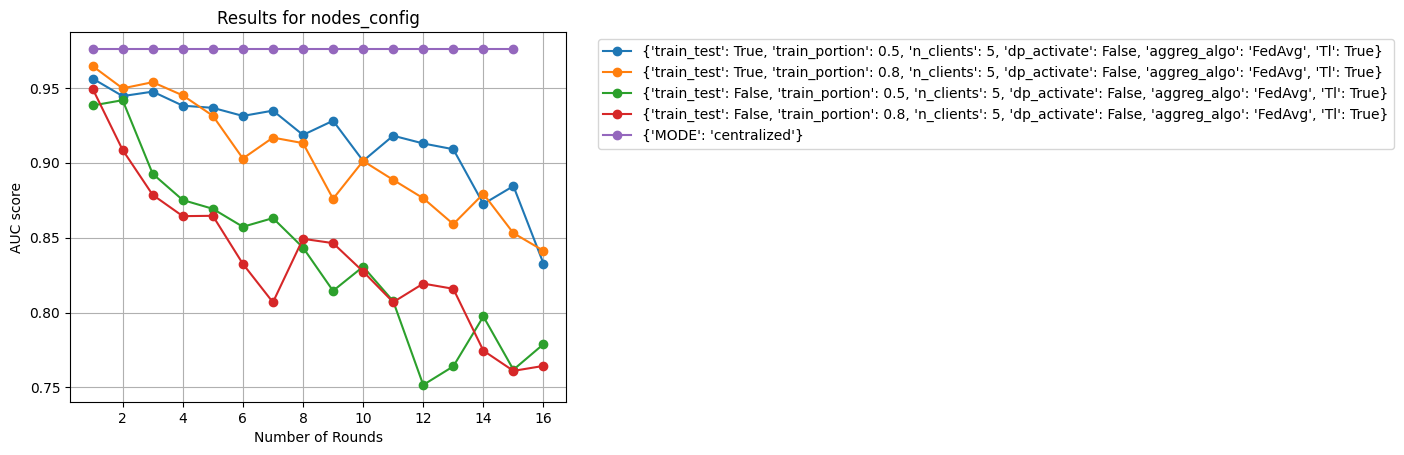

In [25]:
res  = [{'n_rounds': 15, 'config': {'train_test': True, 'train_portion': 0.5, 'n_clients': 5, 'dp_activate': False, 'aggreg_algo': 'FedAvg', 'Tl': True}, 'results': [0.9562410587805471, 0.9444989956280279, 0.9474807709284907, 0.9381050162913346, 0.9366619632993383, 0.9312559122581371, 0.9347978914753109, 0.9185640446152127, 0.9280505846273366, 0.9012311735148221, 0.9180512050879125, 0.912868276513994, 0.9090212987070606, 0.8724875108823942, 0.8844248706223121, 0.8326876059095192], 'test_results': [{'node_name': 'hospital_1', 'classification_report': "{'confusion matrix': {'TP': 0, 'FP': 0, 'FN': 183, 'TN': 1817}, 'Accuracy': 0.908, 'Sensitivity/Recall': 0.0, 'Specificity': 1.0, 'PPV/Precision': 0.0, 'NPV': 0.908, 'F1-score': 0.0, 'False positive rate': 0.0, 'True positive rate': 0.0, 'auc': 0.8316732378778445}"}, {'node_name': 'hospital_2', 'classification_report': "{'confusion matrix': {'TP': 0, 'FP': 0, 'FN': 151, 'TN': 1849}, 'Accuracy': 0.924, 'Sensitivity/Recall': 0.0, 'Specificity': 1.0, 'PPV/Precision': 0.0, 'NPV': 0.924, 'F1-score': 0.0, 'False positive rate': 0.0, 'True positive rate': 0.0, 'auc': 0.8489106336340746}"}, {'node_name': 'hospital_3', 'classification_report': "{'confusion matrix': {'TP': 0, 'FP': 0, 'FN': 168, 'TN': 1832}, 'Accuracy': 0.916, 'Sensitivity/Recall': 0.0, 'Specificity': 1.0, 'PPV/Precision': 0.0, 'NPV': 0.916, 'F1-score': 0.0, 'False positive rate': 0.0, 'True positive rate': 0.0, 'auc': 0.8320856726970265}"}, {'node_name': 'hospital_44', 'classification_report': "{'confusion matrix': {'TP': 0, 'FP': 0, 'FN': 804, 'TN': 9196}, 'Accuracy': 0.92, 'Sensitivity/Recall': 0.0, 'Specificity': 1.0, 'PPV/Precision': 0.0, 'NPV': 0.92, 'F1-score': 0.0, 'False positive rate': 0.0, 'True positive rate': 0.0, 'auc': 0.828156547622912}"}, {'node_name': 'hospital_45', 'classification_report': "{'confusion matrix': {'TP': 0, 'FP': 0, 'FN': 872, 'TN': 9128}, 'Accuracy': 0.913, 'Sensitivity/Recall': 0.0, 'Specificity': 1.0, 'PPV/Precision': 0.0, 'NPV': 0.913, 'F1-score': 0.0, 'False positive rate': 0.0, 'True positive rate': 0.0, 'auc': 0.8426444818443501}"}]}, {'n_rounds': 15, 'config': {'train_test': True, 'train_portion': 0.8, 'n_clients': 5, 'dp_activate': False, 'aggreg_algo': 'FedAvg', 'Tl': True}, 'results': [0.9645439700784528, 0.9496658456486042, 0.9537921912059844, 0.9449796569968985, 0.9313617952928297, 0.902824849480022, 0.9167882685641306, 0.9131023535851122, 0.8759151614668857, 0.9011678525816458, 0.8885663200145959, 0.8762962050720671, 0.8590204342273308, 0.8792526911147601, 0.8529970808246671, 0.8412588031381136], 'test_results': [{'node_name': 'hospital_1', 'classification_report': "{'confusion matrix': {'TP': 0, 'FP': 0, 'FN': 181, 'TN': 1819}, 'Accuracy': 0.91, 'Sensitivity/Recall': 0.0, 'Specificity': 1.0, 'PPV/Precision': 0.0, 'NPV': 0.91, 'F1-score': 0.0, 'False positive rate': 0.0, 'True positive rate': 0.0, 'auc': 0.8113984066286193}"}, {'node_name': 'hospital_2', 'classification_report': "{'confusion matrix': {'TP': 0, 'FP': 0, 'FN': 161, 'TN': 1839}, 'Accuracy': 0.92, 'Sensitivity/Recall': 0.0, 'Specificity': 1.0, 'PPV/Precision': 0.0, 'NPV': 0.92, 'F1-score': 0.0, 'False positive rate': 0.0, 'True positive rate': 0.0, 'auc': 0.8574366976381304}"}, {'node_name': 'hospital_3', 'classification_report': "{'confusion matrix': {'TP': 0, 'FP': 0, 'FN': 160, 'TN': 1840}, 'Accuracy': 0.92, 'Sensitivity/Recall': 0.0, 'Specificity': 1.0, 'PPV/Precision': 0.0, 'NPV': 0.92, 'F1-score': 0.0, 'False positive rate': 0.0, 'True positive rate': 0.0, 'auc': 0.8513043478260871}"}, {'node_name': 'hospital_4', 'classification_report': "{'confusion matrix': {'TP': 0, 'FP': 0, 'FN': 165, 'TN': 1835}, 'Accuracy': 0.918, 'Sensitivity/Recall': 0.0, 'Specificity': 1.0, 'PPV/Precision': 0.0, 'NPV': 0.918, 'F1-score': 0.0, 'False positive rate': 0.0, 'True positive rate': 0.0, 'auc': 0.8409974403434893}"}, {'node_name': 'hospital_5', 'classification_report': "{'confusion matrix': {'TP': 0, 'FP': 0, 'FN': 186, 'TN': 1814}, 'Accuracy': 0.907, 'Sensitivity/Recall': 0.0, 'Specificity': 1.0, 'PPV/Precision': 0.0, 'NPV': 0.907, 'F1-score': 0.0, 'False positive rate': 0.0, 'True positive rate': 0.0, 'auc': 0.8640635558558878}"}]}, {'n_rounds': 15, 'config': {'train_test': False, 'train_portion': 0.5, 'n_clients': 5, 'dp_activate': False, 'aggreg_algo': 'FedAvg', 'Tl': True}, 'results': [0.9382354744090007, 0.9417661876602366, 0.8926024037244839, 0.875095936160545, 0.8692462386794052, 0.8572319346976373, 0.8630323463837554, 0.8433526707571944, 0.8144656902957793, 0.8305971091728415, 0.8075675210204317, 0.7516445966659168, 0.7640351119341663, 0.797345847086763, 0.7618237196653029, 0.7788684343643558], 'test_results': [{'node_name': 'hospital_1', 'classification_report': "{'confusion matrix': {'TP': 0, 'FP': 0, 'FN': 171, 'TN': 1829}, 'Accuracy': 0.914, 'Sensitivity/Recall': 0.0, 'Specificity': 1.0, 'PPV/Precision': 0.0, 'NPV': 0.914, 'F1-score': 0.0, 'False positive rate': 0.0, 'True positive rate': 0.0, 'auc': 0.8262432096278604}"}, {'node_name': 'hospital_2', 'classification_report': "{'confusion matrix': {'TP': 0, 'FP': 0, 'FN': 167, 'TN': 1833}, 'Accuracy': 0.916, 'Sensitivity/Recall': 0.0, 'Specificity': 1.0, 'PPV/Precision': 0.0, 'NPV': 0.916, 'F1-score': 0.0, 'False positive rate': 0.0, 'True positive rate': 0.0, 'auc': 0.8238057436681466}"}, {'node_name': 'hospital_3', 'classification_report': "{'confusion matrix': {'TP': 0, 'FP': 0, 'FN': 190, 'TN': 1810}, 'Accuracy': 0.905, 'Sensitivity/Recall': 0.0, 'Specificity': 1.0, 'PPV/Precision': 0.0, 'NPV': 0.905, 'F1-score': 0.0, 'False positive rate': 0.0, 'True positive rate': 0.0, 'auc': 0.8382233207327712}"}, {'node_name': 'hospital_4', 'classification_report': "{'confusion matrix': {'TP': 0, 'FP': 0, 'FN': 174, 'TN': 1826}, 'Accuracy': 0.913, 'Sensitivity/Recall': 0.0, 'Specificity': 1.0, 'PPV/Precision': 0.0, 'NPV': 0.913, 'F1-score': 0.0, 'False positive rate': 0.0, 'True positive rate': 0.0, 'auc': 0.8088749984263071}"}, {'node_name': 'hospital_5', 'classification_report': "{'confusion matrix': {'TP': 0, 'FP': 0, 'FN': 181, 'TN': 1819}, 'Accuracy': 0.91, 'Sensitivity/Recall': 0.0, 'Specificity': 1.0, 'PPV/Precision': 0.0, 'NPV': 0.91, 'F1-score': 0.0, 'False positive rate': 0.0, 'True positive rate': 0.0, 'auc': 0.8448847190035201}"}]}, {'n_rounds': 15, 'config': {'train_test': False, 'train_portion': 0.8, 'n_clients': 5, 'dp_activate': False, 'aggreg_algo': 'FedAvg', 'Tl': True}, 'results': [0.9495029898005427, 0.9085397884774971, 0.8785420102288845, 0.8643402192912759, 0.8645695099198991, 0.8324776883191789, 0.80680869396331, 0.8492254150702427, 0.846317828157094, 0.82737565254751, 0.8069063421438284, 0.8193021729022841, 0.8158330949732507, 0.7745336852822947, 0.7610297214424021, 0.7643449040968509], 'test_results': [{'node_name': 'hospital_1', 'classification_report': "{'confusion matrix': {'TP': 0, 'FP': 0, 'FN': 182, 'TN': 1818}, 'Accuracy': 0.909, 'Sensitivity/Recall': 0.0, 'Specificity': 1.0, 'PPV/Precision': 0.0, 'NPV': 0.909, 'F1-score': 0.0, 'False positive rate': 0.0, 'True positive rate': 0.0, 'auc': 0.8323087803285824}"}, {'node_name': 'hospital_2', 'classification_report': "{'confusion matrix': {'TP': 0, 'FP': 0, 'FN': 167, 'TN': 1833}, 'Accuracy': 0.916, 'Sensitivity/Recall': 0.0, 'Specificity': 1.0, 'PPV/Precision': 0.0, 'NPV': 0.916, 'F1-score': 0.0, 'False positive rate': 0.0, 'True positive rate': 0.0, 'auc': 0.8282289757636936}"}, {'node_name': 'hospital_3', 'classification_report': "{'confusion matrix': {'TP': 0, 'FP': 0, 'FN': 154, 'TN': 1846}, 'Accuracy': 0.923, 'Sensitivity/Recall': 0.0, 'Specificity': 1.0, 'PPV/Precision': 0.0, 'NPV': 0.923, 'F1-score': 0.0, 'False positive rate': 0.0, 'True positive rate': 0.0, 'auc': 0.838647268224733}"}, {'node_name': 'hospital_4', 'classification_report': "{'confusion matrix': {'TP': 0, 'FP': 0, 'FN': 157, 'TN': 1843}, 'Accuracy': 0.922, 'Sensitivity/Recall': 0.0, 'Specificity': 1.0, 'PPV/Precision': 0.0, 'NPV': 0.922, 'F1-score': 0.0, 'False positive rate': 0.0, 'True positive rate': 0.0, 'auc': 0.7899056854823381}"}, {'node_name': 'hospital_5', 'classification_report': "{'confusion matrix': {'TP': 0, 'FP': 0, 'FN': 172, 'TN': 1828}, 'Accuracy': 0.914, 'Sensitivity/Recall': 0.0, 'Specificity': 1.0, 'PPV/Precision': 0.0, 'NPV': 0.914, 'F1-score': 0.0, 'False positive rate': 0.0, 'True positive rate': 0.0, 'auc': 0.8406919495191084}"}]}, {'config': {'MODE': 'centralized'}, 'results': [0.976, 0.976, 0.976, 0.976, 0.976, 0.976, 0.976, 0.976, 0.976,
       0.976, 0.976, 0.976, 0.976, 0.976, 0.976]}]
plot_benchmarks_results(benchmarks_results=res , categ="nodes_config" )

[{'n_rounds': 15, 'config': {'train_test': True, 'train_portion': 0.5, 'n_clients': 5, 'dp_activate': False, 'aggreg_algo': 'FedAvg', 'Tl': True}, 'results': [0.9562410587805471, 0.9444989956280279, 0.9474807709284907, 0.9381050162913346, 0.9366619632993383, 0.9312559122581371, 0.9347978914753109, 0.9185640446152127, 0.9280505846273366, 0.9012311735148221, 0.9180512050879125, 0.912868276513994, 0.9090212987070606, 0.8724875108823942, 0.8844248706223121, 0.8326876059095192], 'test_results': [{'node_name': 'hospital_1', 'classification_report': "{'confusion matrix': {'TP': 0, 'FP': 0, 'FN': 183, 'TN': 1817}, 'Accuracy': 0.908, 'Sensitivity/Recall': 0.0, 'Specificity': 1.0, 'PPV/Precision': 0.0, 'NPV': 0.908, 'F1-score': 0.0, 'False positive rate': 0.0, 'True positive rate': 0.0, 'auc': 0.8316732378778445}"}, {'node_name': 'hospital_2', 'classification_report': "{'confusion matrix': {'TP': 0, 'FP': 0, 'FN': 151, 'TN': 1849}, 'Accuracy': 0.924, 'Sensitivity/Recall': 0.0, 'Specificity': 1.0

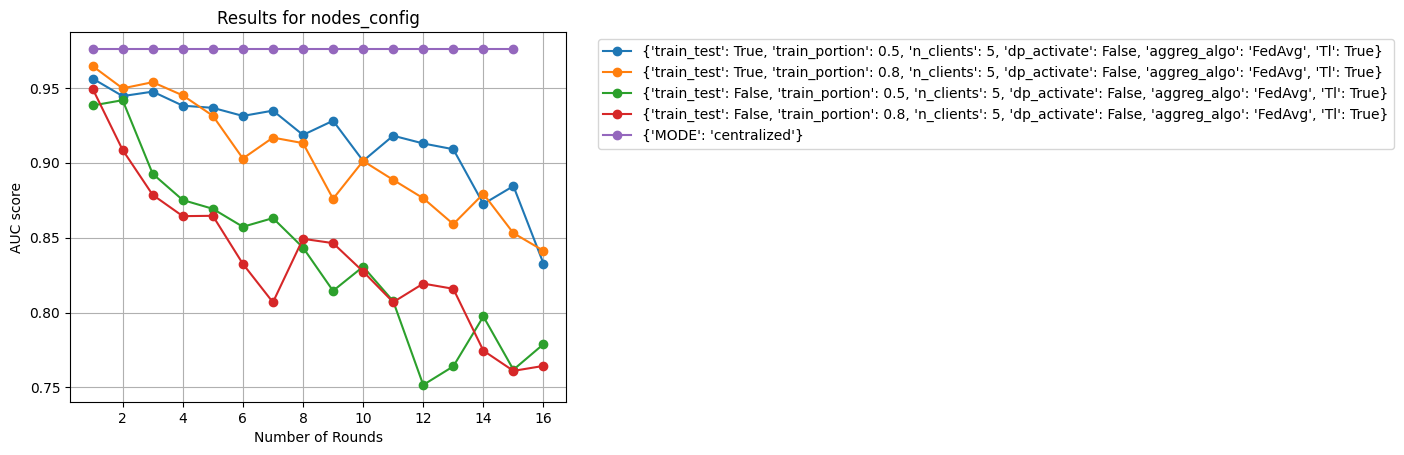

In [24]:
plot_benchmarks_results(benchmarks_results=benchmarks_results , categ="nodes_config" )

[{'n_rounds': 15, 'config': {'train_test': True, 'train_portion': 0.5, 'n_clients': 10, 'dp_activate': False, 'aggreg_algo': 'FedAvg', 'Tl': True}, 'results': [0.9775442057410447, 0.9666647539005715, 0.9570129484455587, 0.9687924732163702, 0.9639876170465714, 0.9600691563033981, 0.9339355971655748, 0.9366582603049047, 0.9301413374747171, 0.9123672466762011, 0.9271488946173781, 0.9199299253236498, 0.9208965220517408, 0.9060942505684348, 0.9050217957244283, 0.8953716945930518], 'test_results': [{'node_name': 'hospital_1', 'classification_report': "{'confusion matrix': {'TP': 0, 'FP': 0, 'FN': 74, 'TN': 926}, 'Accuracy': 0.926, 'Sensitivity/Recall': 0.0, 'Specificity': 1.0, 'PPV/Precision': 0.0, 'NPV': 0.926, 'F1-score': 0.0, 'False positive rate': 0.0, 'True positive rate': 0.0, 'auc': 0.846433366411768}"}, {'node_name': 'hospital_2', 'classification_report': "{'confusion matrix': {'TP': 0, 'FP': 0, 'FN': 95, 'TN': 905}, 'Accuracy': 0.905, 'Sensitivity/Recall': 0.0, 'Specificity': 1.0, '

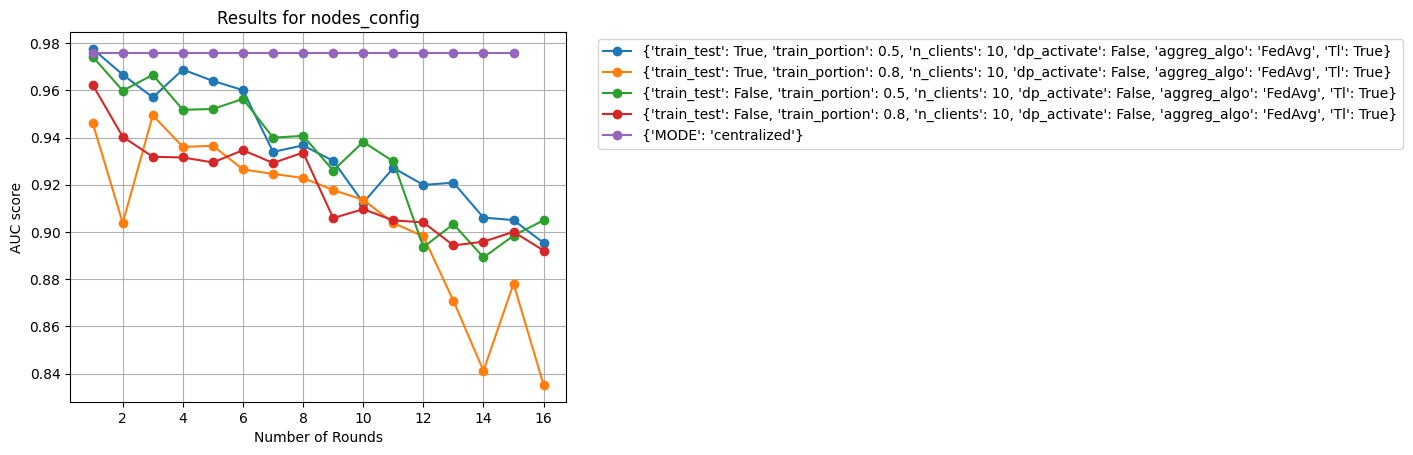

In [50]:
plot_benchmarks_results(benchmarks_results=benchmarks_results , categ="nodes_config" )

[{'n_rounds': 50, 'config': {'train_test': False, 'train_portion': 0.5, 'n_clients': 10, 'dp_activate': False, 'aggreg_algo': 'FedAdagrad', 'Tl': True}, 'results': [0.8171805046805047, 0.6615613553113553, 0.6387311762311763, 0.4951923076923077, 0.6540928978428979, 0.49056267806267806, 0.49056267806267806, 0.6480031542531542, 0.4951923076923077, 0.5, 0.49056267806267806, 0.48609839234839236, 0.49056267806267806, 0.49056267806267806, 0.48609839234839236, 0.6319317256817256, 0.6721179283679284, 0.6769256206756207, 0.6248422873422874, 0.6753230565730566, 0.6531669719169719, 0.654769536019536, 0.654769536019536, 0.643195461945462, 0.62746743996744, 0.643195461945462, 0.643195461945462, 0.6640287952787953, 0.6480031542531542, 0.6480031542531542, 0.6480031542531542, 0.6480031542531542, 0.6480031542531542, 0.6480031542531542, 0.6480031542531542, 0.6480031542531542, 0.6480031542531542, 0.6480031542531542, 0.6480031542531542, 0.6480031542531542, 0.6480031542531542, 0.6480031542531542, 0.64800315

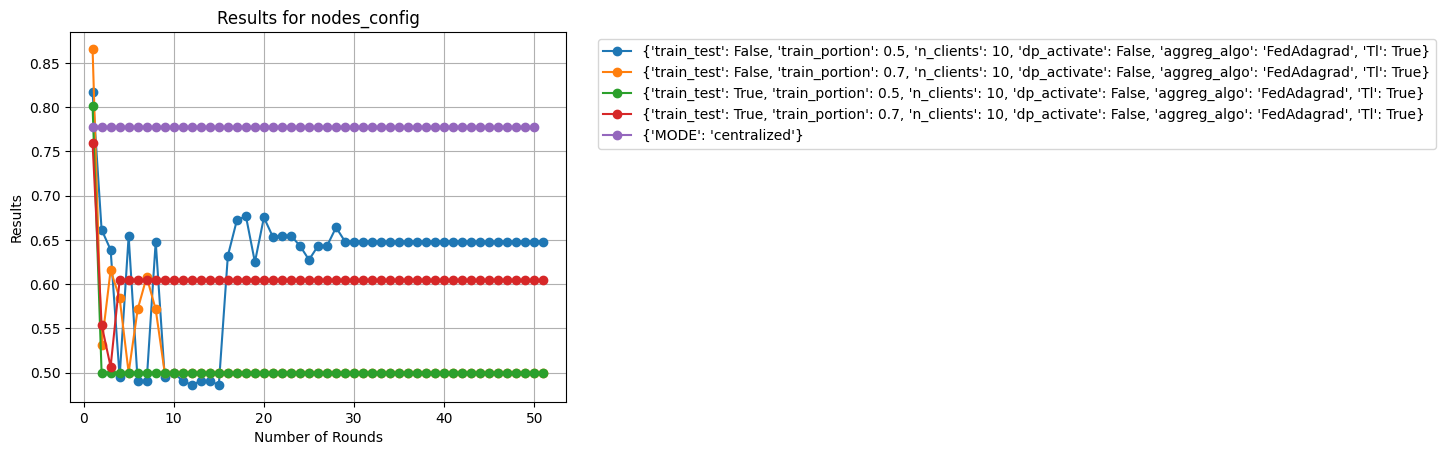

In [ ]:
plot_benchmarks_results(benchmarks_results=benchmarks_results , categ="nodes_config" )

# The new tests 

[{'n_rounds': 50, 'config': {'aggreg_algo': 'FedAdagrad', 'train_test': True, 'train_portion': 0.7, 'n_clients': 10, 'dp_activate': False, 'Tl': True}, 'results': [0.5423251488095239, 0.5441071428571429, 0.5301785714285714, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5], 'test_results': [{'node_name': 'hospital_1', 'classification_report': "{'confusion matrix': {'TP': 0, 'FP': 0, 'FN': 51, 'TN': 203}, 'Accuracy': 0.799, 'Sensitivity/Recall': 0.0, 'Specificity': 1.0, 'PPV/Precision': 0.0, 'NPV': 0.799, 'F1-score': 0.0, 'False positive rate': 0.0, 'True positive rate': 0.0, 'auc': 0.5}"}, {'node_name': 'hospital_2', 'classification_report': "{'confusion matrix': {'TP': 0, 'FP': 0, 'FN': 52, 'TN': 202}, 'Accuracy': 0.795, 'Sensitivity/Recall': 0.0, 'Specificity': 1.0, 'PPV/Precision': 0.0, 'NPV': 0.

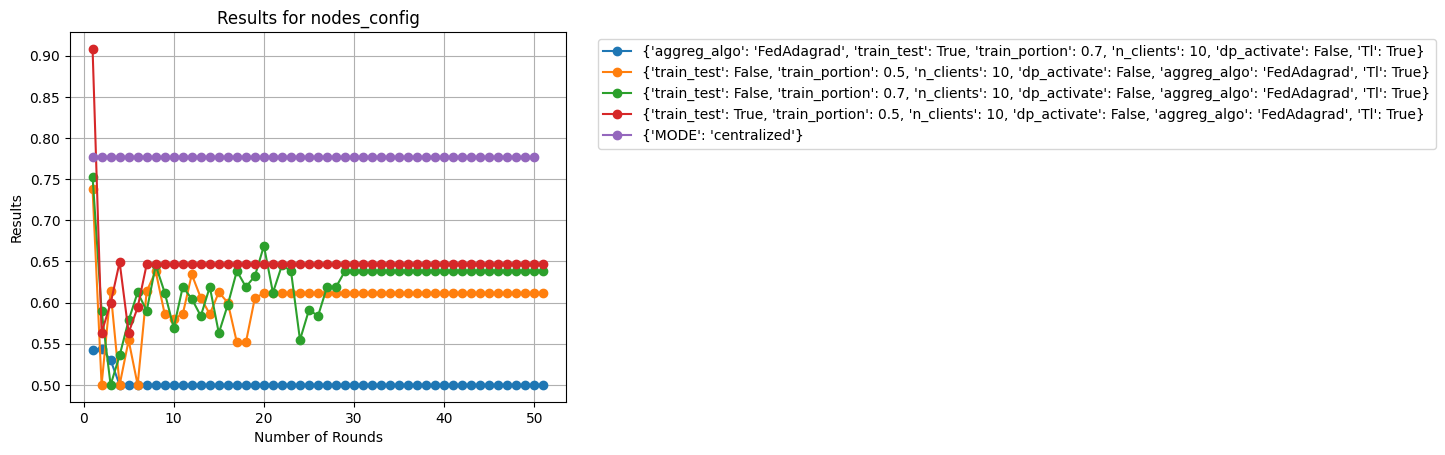

In [ ]:
plot_benchmarks_results(benchmarks_results=benchmarks_results , categ="nodes_config" )

[{'n_rounds': 50, 'config': {'aggreg_algo': 'FedYogi', 'train_test': True, 'train_portion': 0.7, 'n_clients': 10, 'dp_activate': False, 'Tl': True}, 'results': [0.7935096304661522, 0.787340799297321, 0.7762433339607253, 0.7607633791329443, 0.7437696844218583, 0.7337449024405546, 0.7216287094547964, 0.678408620365142, 0.6525522303783173, 0.6346950875211745, 0.6341269057029927, 0.6392405420666291, 0.5142405420666291, 0.5142405420666291, 0.5142405420666291, 0.5142405420666291, 0.5192405420666291, 0.5192405420666291, 0.5192405420666291, 0.5192405420666291, 0.5192405420666291, 0.5192405420666291, 0.5192405420666291, 0.5192405420666291, 0.5192405420666291, 0.5192405420666291, 0.5192405420666291, 0.5192405420666291, 0.5192405420666291, 0.5192405420666291, 0.5192405420666291, 0.5192405420666291, 0.5192405420666291, 0.5192405420666291, 0.5192405420666291, 0.5192405420666291, 0.5192405420666291, 0.5192405420666291, 0.6335587238848108, 0.6335587238848108, 0.6335587238848108, 0.6335587238848108, 0

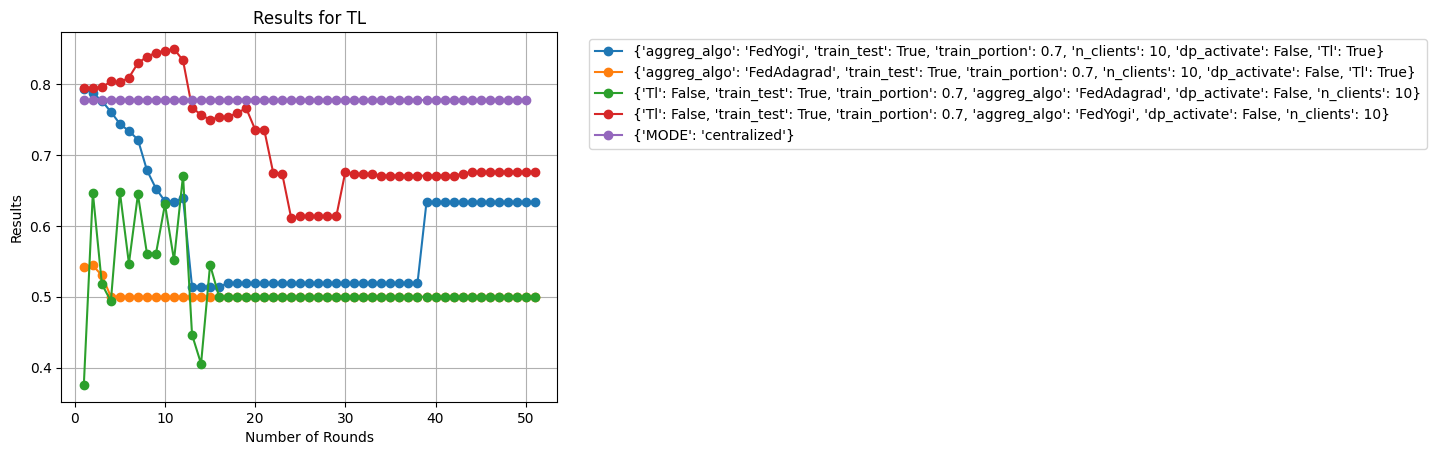

In [ ]:
plot_benchmarks_results(benchmarks_results=benchmarks_results , categ="TL" )

[{'n_rounds': 10, 'config': {'train_test': False, 'train_portion': 0.5, 'n_clients': 10, 'dp_activate': False, 'aggreg_algo': 'FedAdagrad', 'Tl': True}, 'results': [0.6193376068376069, 0.5, 0.5801282051282051, 0.5, 0.516025641025641, 0.5, 0.5, 0.516025641025641, 0.5897435897435898, 0.5849358974358974, 0.5576923076923077], 'test_results': [{'node_name': 'hospital_1', 'classification_report': "{'confusion matrix': {'TP': 9, 'FP': 9, 'FN': 44, 'TN': 192}, 'Accuracy': 0.791, 'Sensitivity/Recall': 0.17, 'Specificity': 0.955, 'PPV/Precision': 0.5, 'NPV': 0.814, 'F1-score': 0.254, 'False positive rate': 0.045, 'True positive rate': 0.17, 'auc': 0.5625176006758659}"}, {'node_name': 'hospital_2', 'classification_report': "{'confusion matrix': {'TP': 11, 'FP': 6, 'FN': 46, 'TN': 191}, 'Accuracy': 0.795, 'Sensitivity/Recall': 0.193, 'Specificity': 0.97, 'PPV/Precision': 0.647, 'NPV': 0.806, 'F1-score': 0.297, 'False positive rate': 0.03, 'True positive rate': 0.193, 'auc': 0.5812628016742364}"}, 

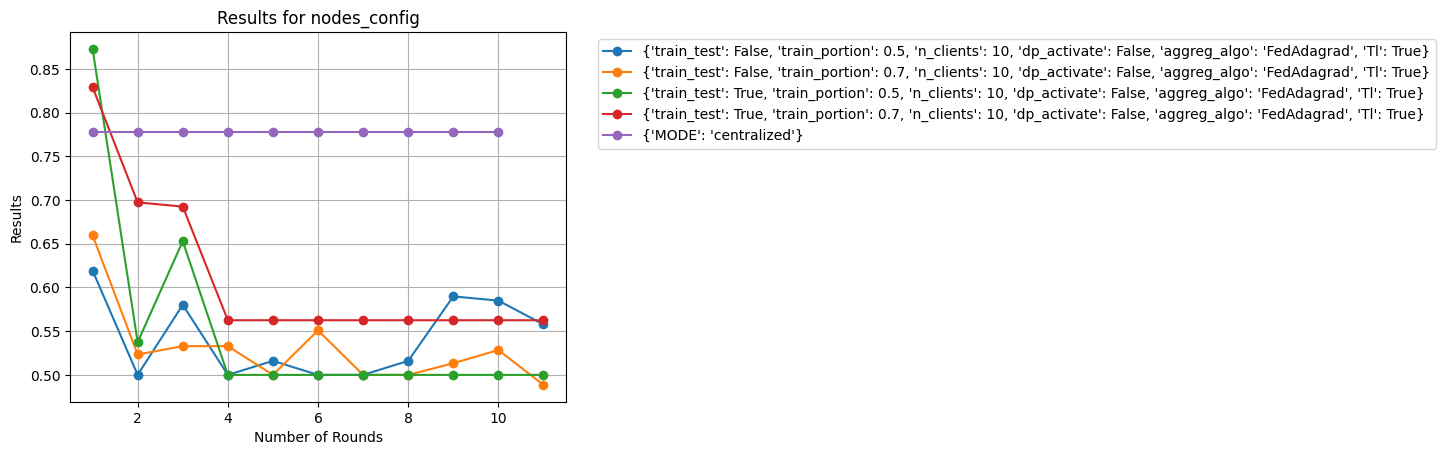

In [ ]:
plot_benchmarks_results(benchmarks_results=benchmarks_results , categ="nodes_config" )

[{'n_rounds': 10, 'config': {'aggreg_algo': 'FedYogi', 'train_test': True, 'train_portion': 0.7, 'n_clients': 10, 'dp_activate': False, 'Tl': True}, 'results': [0.7557715201465202, 0.7492954441391941, 0.7516466346153845, 0.7490373168498169, 0.6860027472527472, 0.5168927426739927, 0.5065685096153847, 0.5065104166666666, 0.5110677083333334, 0.5110677083333334, 0.515625], 'test_results': [{'node_name': 'hospital_1', 'classification_report': "{'confusion matrix': {'TP': 7, 'FP': 3, 'FN': 43, 'TN': 201}, 'Accuracy': 0.819, 'Sensitivity/Recall': 0.14, 'Specificity': 0.985, 'PPV/Precision': 0.7, 'NPV': 0.824, 'F1-score': 0.233, 'False positive rate': 0.015, 'True positive rate': 0.14, 'auc': 0.5626470588235295}"}, {'node_name': 'hospital_2', 'classification_report': "{'confusion matrix': {'TP': 7, 'FP': 1, 'FN': 38, 'TN': 208}, 'Accuracy': 0.846, 'Sensitivity/Recall': 0.156, 'Specificity': 0.995, 'PPV/Precision': 0.875, 'NPV': 0.846, 'F1-score': 0.264, 'False positive rate': 0.005, 'True posi

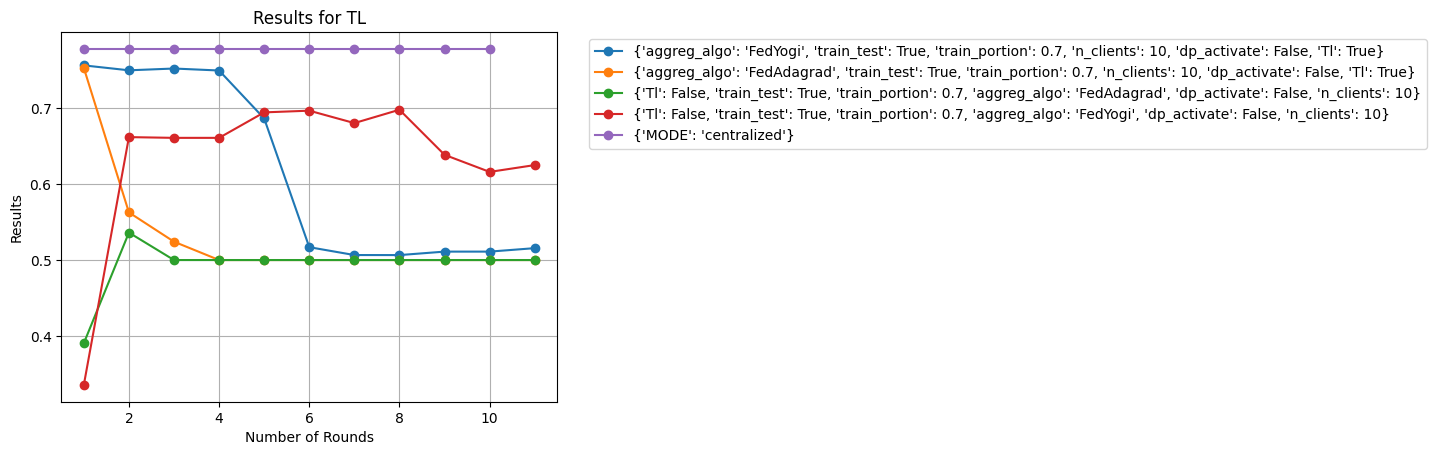

In [ ]:
plot_benchmarks_results(benchmarks_results=benchmarks_results , categ="TL" )

[{'n_rounds': 10, 'config': {'aggreg_algo': 'FedYogi', 'train_test': True, 'train_portion': 0.7, 'n_clients': 10, 'dp_activate': False, 'Tl': True}, 'results': [0.7557715201465202, 0.7492954441391941, 0.7516466346153845, 0.7490373168498169, 0.6860027472527472, 0.5168927426739927, 0.5065685096153847, 0.5065104166666666, 0.5110677083333334, 0.5110677083333334, 0.515625], 'test_results': [{'node_name': 'hospital_1', 'classification_report': "{'confusion matrix': {'TP': 7, 'FP': 3, 'FN': 43, 'TN': 201}, 'Accuracy': 0.819, 'Sensitivity/Recall': 0.14, 'Specificity': 0.985, 'PPV/Precision': 0.7, 'NPV': 0.824, 'F1-score': 0.233, 'False positive rate': 0.015, 'True positive rate': 0.14, 'auc': 0.5626470588235295}"}, {'node_name': 'hospital_2', 'classification_report': "{'confusion matrix': {'TP': 7, 'FP': 1, 'FN': 38, 'TN': 208}, 'Accuracy': 0.846, 'Sensitivity/Recall': 0.156, 'Specificity': 0.995, 'PPV/Precision': 0.875, 'NPV': 0.846, 'F1-score': 0.264, 'False positive rate': 0.005, 'True posi

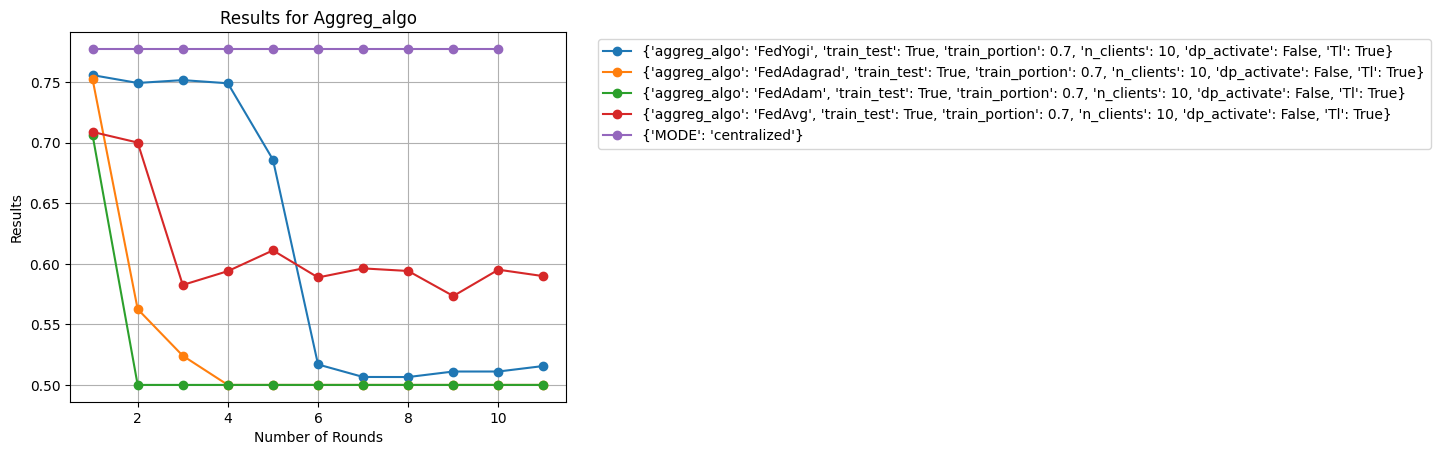

In [ ]:
plot_benchmarks_results(benchmarks_results=benchmarks_results , categ="Aggreg_algo" )

[{'n_rounds': 10, 'config': {'aggreg_algo': 'FedYogi', 'train_test': True, 'train_portion': 0.7, 'n_clients': 10, 'dp_activate': False, 'Tl': False}, 'results': [0.67744708994709, 0.6775297619047619, 0.6793816137566138, 0.6816964285714286, 0.6881779100529102, 0.6841765873015873, 0.6518105158730159, 0.5954034391534392, 0.6108300264550264, 0.6032407407407407, 0.5184193121693121], 'test_results': [{'node_name': 'hospital_1', 'classification_report': "{'confusion matrix': {'TP': 10, 'FP': 8, 'FN': 41, 'TN': 195}, 'Accuracy': 0.807, 'Sensitivity/Recall': 0.196, 'Specificity': 0.961, 'PPV/Precision': 0.556, 'NPV': 0.826, 'F1-score': 0.29, 'False positive rate': 0.039, 'True positive rate': 0.196, 'auc': 0.6149908239157732}"}, {'node_name': 'hospital_2', 'classification_report': "{'confusion matrix': {'TP': 17, 'FP': 13, 'FN': 42, 'TN': 182}, 'Accuracy': 0.783, 'Sensitivity/Recall': 0.288, 'Specificity': 0.933, 'PPV/Precision': 0.567, 'NPV': 0.812, 'F1-score': 0.382, 'False positive rate': 0.

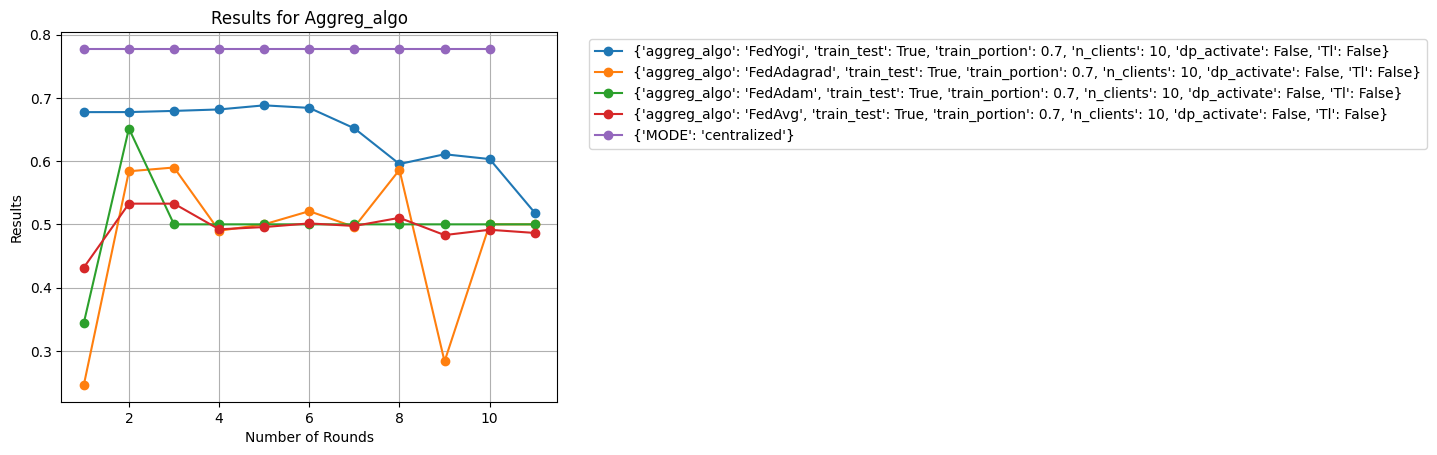

In [ ]:
plot_benchmarks_results(benchmarks_results=benchmarks_results , categ="Aggreg_algo" )

[{'n_rounds': 10, 'config': {'aggreg_algo': 'FedAdagrad', 'train_test': True, 'train_portion': 0.7, 'n_clients': 10, 'dp_activate': False, 'Tl': False}, 'results': [0.24606401662853272, 0.5839285714285714, 0.5898809523809524, 0.4898809523809524, 0.5, 0.5208333333333334, 0.49583333333333335, 0.5861712883890303, 0.28318422169228624, 0.5, 0.5], 'test_results': [{'node_name': 'hospital_1', 'classification_report': "{'confusion matrix': {'TP': 0, 'FP': 0, 'FN': 48, 'TN': 206}, 'Accuracy': 0.811, 'Sensitivity/Recall': 0.0, 'Specificity': 1.0, 'PPV/Precision': 0.0, 'NPV': 0.811, 'F1-score': 0.0, 'False positive rate': 0.0, 'True positive rate': 0.0, 'auc': 0.5}"}, {'node_name': 'hospital_2', 'classification_report': "{'confusion matrix': {'TP': 0, 'FP': 0, 'FN': 54, 'TN': 200}, 'Accuracy': 0.787, 'Sensitivity/Recall': 0.0, 'Specificity': 1.0, 'PPV/Precision': 0.0, 'NPV': 0.787, 'F1-score': 0.0, 'False positive rate': 0.0, 'True positive rate': 0.0, 'auc': 0.5}"}, {'node_name': 'hospital_3', '

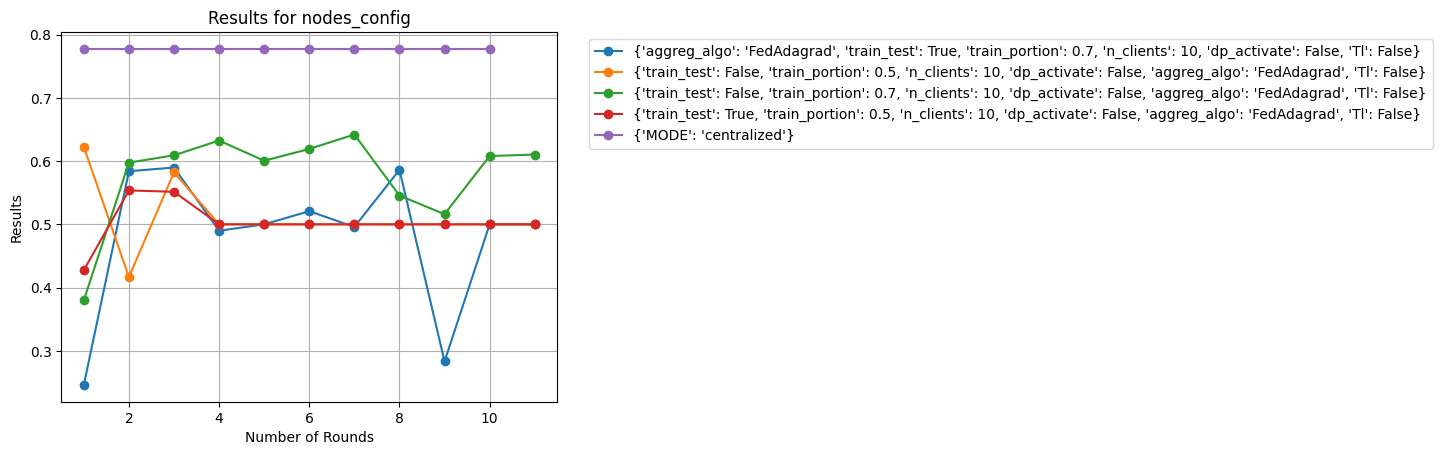

In [ ]:
plot_benchmarks_results(benchmarks_results=benchmarks_results , categ="nodes_config" )

[{'n_rounds': 50, 'config': {'aggreg_algo': 'FedYogi', 'train_test': True, 'train_portion': 0.7, 'n_clients': 10, 'dp_activate': False, 'Tl': False}, 'results': [0.48537950575994054, 0.510508117335563, 0.5084163647342995, 0.5116214929394277, 0.5143142070791527, 0.5153100032515794, 0.4630996551003344, 0.49074098267372723, 0.5264038403474545, 0.5314147563638053, 0.5231900025548124, 0.5240028973894463, 0.5207977691843181, 0.5154776628112225, 0.48241606860832403, 0.44919552443329613, 0.45542578270159795, 0.45602964743589747, 0.4487121423262727, 0.5103992474916388, 0.5112121423262728, 0.5126085795243404, 0.5100073160535117, 0.5090086166852471, 0.506604770531401, 0.5061039692493496, 0.5048962397807506, 0.5032936756781865, 0.5032936756781865, 0.5045928558156819, 0.5090144230769231, 0.4514396948160535, 0.4519637216648086, 0.5058709877833519, 0.5096124814195466, 0.4954376277406169, 0.4819631700575994, 0.49265055973615757, 0.496356489223337, 0.4724682680694909, 0.47887852447974727, 0.48799310781

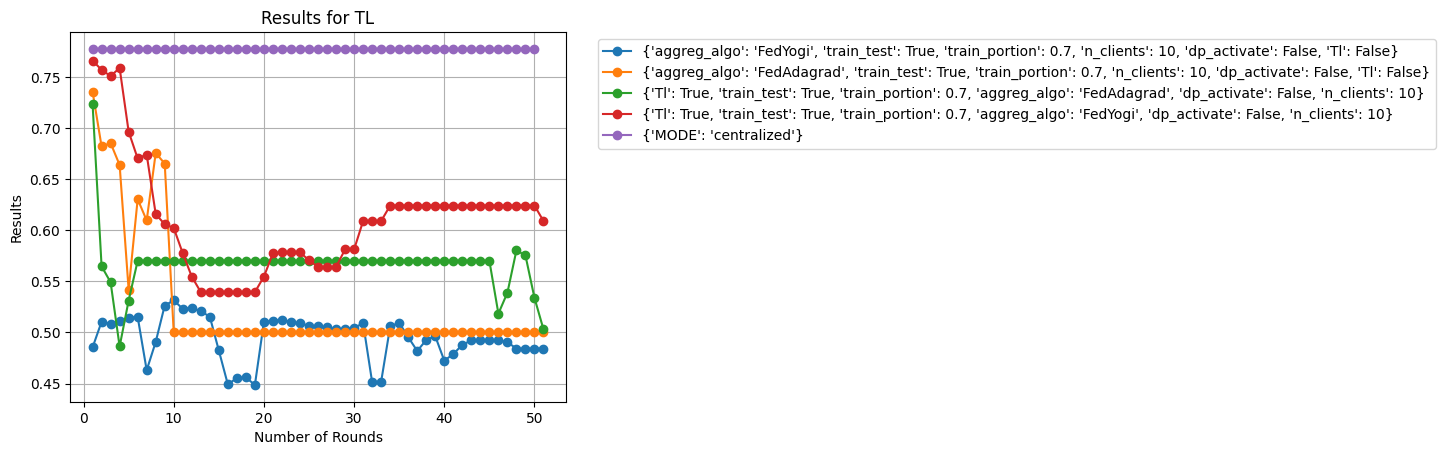

In [ ]:
plot_benchmarks_results(benchmarks_results=benchmarks_results , categ="TL" )

[{'n_rounds': 50, 'config': {'aggreg_algo': 'FedYogi', 'train_test': True, 'train_portion': 0.7, 'n_clients': 10, 'dp_activate': False, 'Tl': False}, 'results': [0.48537950575994054, 0.510508117335563, 0.5084163647342995, 0.5116214929394277, 0.5143142070791527, 0.5153100032515794, 0.4630996551003344, 0.49074098267372723, 0.5264038403474545, 0.5314147563638053, 0.5231900025548124, 0.5240028973894463, 0.5207977691843181, 0.5154776628112225, 0.48241606860832403, 0.44919552443329613, 0.45542578270159795, 0.45602964743589747, 0.4487121423262727, 0.5103992474916388, 0.5112121423262728, 0.5126085795243404, 0.5100073160535117, 0.5090086166852471, 0.506604770531401, 0.5061039692493496, 0.5048962397807506, 0.5032936756781865, 0.5032936756781865, 0.5045928558156819, 0.5090144230769231, 0.4514396948160535, 0.4519637216648086, 0.5058709877833519, 0.5096124814195466, 0.4954376277406169, 0.4819631700575994, 0.49265055973615757, 0.496356489223337, 0.4724682680694909, 0.47887852447974727, 0.48799310781

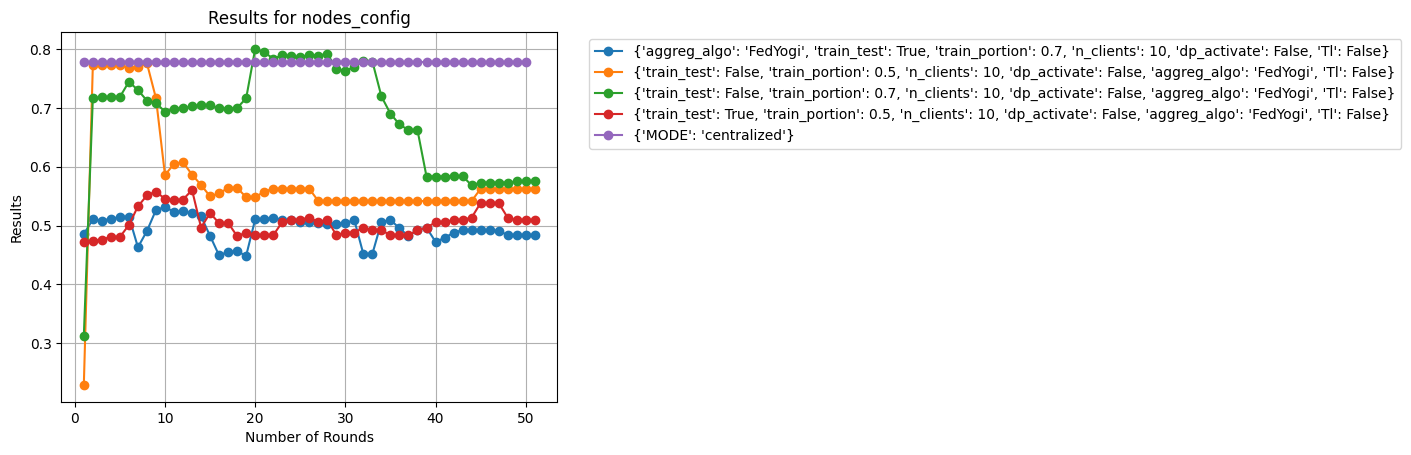

In [ ]:
plot_benchmarks_results(benchmarks_results=benchmarks_results , categ="nodes_config" )

[{'n_rounds': 50, 'config': {'aggreg_algo': 'FedYogi', 'train_test': True, 'train_portion': 0.7, 'n_clients': 10, 'dp_activate': False, 'Tl': False}, 'results': [0.48537950575994054, 0.510508117335563, 0.5084163647342995, 0.5116214929394277, 0.5143142070791527, 0.5153100032515794, 0.4630996551003344, 0.49074098267372723, 0.5264038403474545, 0.5314147563638053, 0.5231900025548124, 0.5240028973894463, 0.5207977691843181, 0.5154776628112225, 0.48241606860832403, 0.44919552443329613, 0.45542578270159795, 0.45602964743589747, 0.4487121423262727, 0.5103992474916388, 0.5112121423262728, 0.5126085795243404, 0.5100073160535117, 0.5090086166852471, 0.506604770531401, 0.5061039692493496, 0.5048962397807506, 0.5032936756781865, 0.5032936756781865, 0.5045928558156819, 0.5090144230769231, 0.4514396948160535, 0.4519637216648086, 0.5058709877833519, 0.5096124814195466, 0.4954376277406169, 0.4819631700575994, 0.49265055973615757, 0.496356489223337, 0.4724682680694909, 0.47887852447974727, 0.48799310781

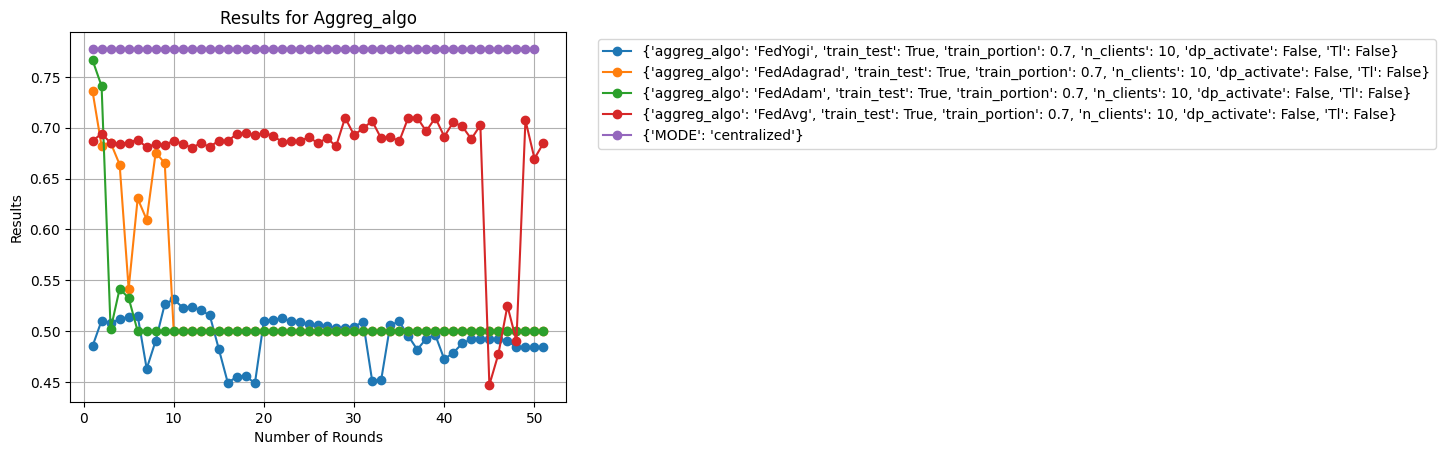

In [ ]:
plot_benchmarks_results(benchmarks_results=benchmarks_results , categ="Aggreg_algo" )

[{'n_rounds': 50, 'config': {'aggreg_algo': 'FedYogi', 'train_test': True, 'train_portion': 0.7, 'n_clients': 10, 'dp_activate': False, 'Tl': False}, 'results': [0.48537950575994054, 0.510508117335563, 0.5084163647342995, 0.5116214929394277, 0.5143142070791527, 0.5153100032515794, 0.4630996551003344, 0.49074098267372723, 0.5264038403474545, 0.5314147563638053, 0.5231900025548124, 0.5240028973894463, 0.5207977691843181, 0.5154776628112225, 0.48241606860832403, 0.44919552443329613, 0.45542578270159795, 0.45602964743589747, 0.4487121423262727, 0.5103992474916388, 0.5112121423262728, 0.5126085795243404, 0.5100073160535117, 0.5090086166852471, 0.506604770531401, 0.5061039692493496, 0.5048962397807506, 0.5032936756781865, 0.5032936756781865, 0.5045928558156819, 0.5090144230769231, 0.4514396948160535, 0.4519637216648086, 0.5058709877833519, 0.5096124814195466, 0.4954376277406169, 0.4819631700575994, 0.49265055973615757, 0.496356489223337, 0.4724682680694909, 0.47887852447974727, 0.48799310781

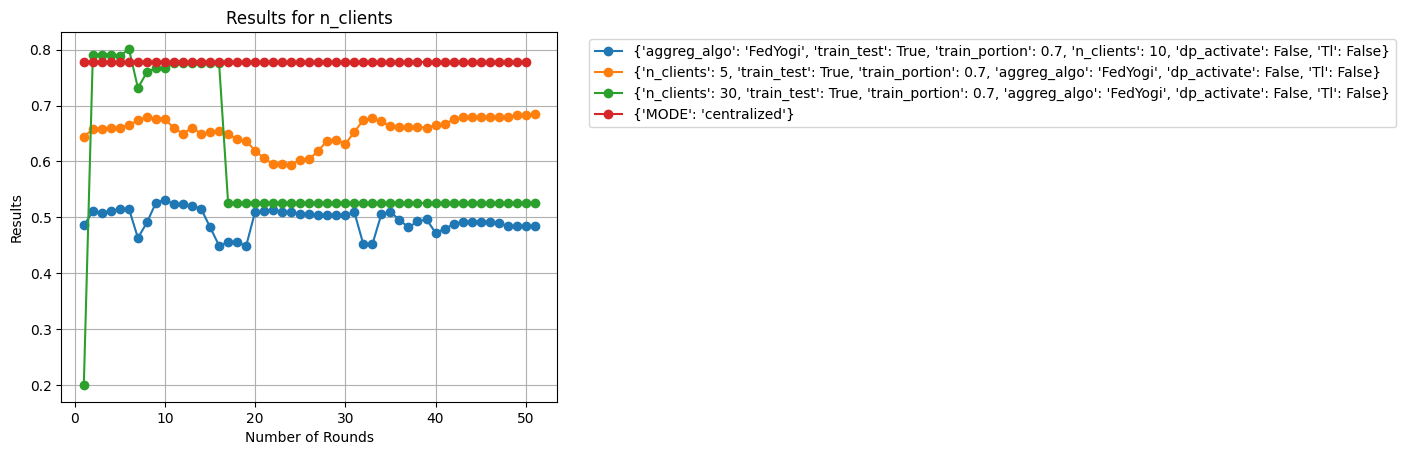

In [ ]:
plot_benchmarks_results(benchmarks_results=benchmarks_results , categ="n_clients" )

[{'n_rounds': 15, 'config': {'aggreg_algo': 'FedYogi', 'train_test': True, 'train_portion': 0.7, 'n_clients': 5, 'dp_activate': False, 'Tl': False}, 'results': [0.8135253622839468, 0.20152331522876088, 0.19533991702887094, 0.19286400851847968, 0.36051200154007623, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5], 'test_results': [{'node_name': 'hospital_1', 'classification_report': "{'confusion matrix': {'TP': 0, 'FP': 0, 'FN': 163, 'TN': 1837}, 'Accuracy': 0.918, 'Sensitivity/Recall': 0.0, 'Specificity': 1.0, 'PPV/Precision': 0.0, 'NPV': 0.918, 'F1-score': 0.0, 'False positive rate': 0.0, 'True positive rate': 0.0, 'auc': 0.5}"}, {'node_name': 'hospital_2', 'classification_report': "{'confusion matrix': {'TP': 0, 'FP': 0, 'FN': 164, 'TN': 1836}, 'Accuracy': 0.918, 'Sensitivity/Recall': 0.0, 'Specificity': 1.0, 'PPV/Precision': 0.0, 'NPV': 0.918, 'F1-score': 0.0, 'False positive rate': 0.0, 'True positive rate': 0.0, 'auc': 0.5}"}, {'node_name': 'hospital_3', 'classification_repo

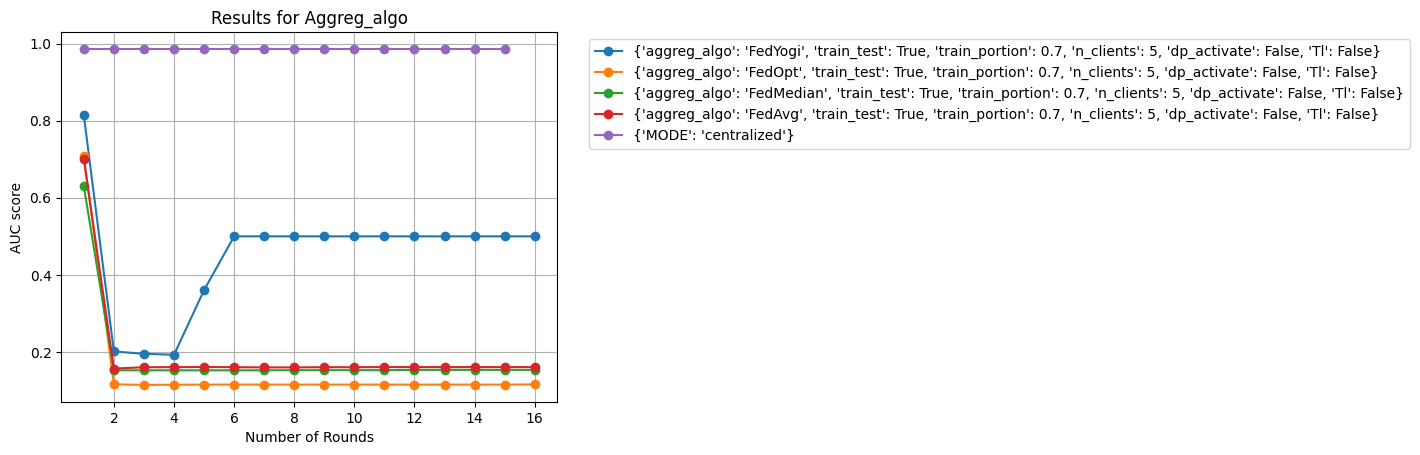

In [23]:
plot_benchmarks_results(benchmarks_results=benchmarks_results , categ="Aggreg_algo" )